# TODO

In [1]:
# Modify area_multiple_buffer function to calc geodesic area instead?

# Func to go thru levles and delete lines that have a redundant level at a larger within_area_multiple

# # Saved geojson's behave differently: 
# # evolving_outlines_gdfs have midcyc_datetime open as timestamp whereas 
# # compare_evolving_stationary_outlines_gdfs have midcyc_datetime open as string
# evolving_outlines_gdf = gpd.read_file(os.path.join(os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(SF18_lake_gdf['name'].values[0])))
# print(type(evolving_outlines_gdf['midcyc_datetime'][0]))
# geom_calcs_df = pd.read_csv(os.path.join(
#     os.getcwd(), 'output/lake_outlines/compare_evolving_stationary_outlines/{}.csv'.format(SF18_lake_gdf['name'].values[0])))
# print(type(geom_calcs_df['midcyc_datetime'][0]))
# Is this an issue? perhaps save geom_calcs_df as geojson instead of csv?

Code to do data analysis of re-examined active subglacial lakes and create Fig. S1 in Sauthoff and others, 202X, _Journal_.

Written 2023-07-11 by W. Sauthoff (wsauthoff.github.io).

# Set up computing environment

This code runs continental-scale operations on multiple datasets and requires a ~32 GB server or local memory.

In [2]:
%pip install openpyxl --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install opencv-python --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import libraries
import cv2
import datetime
import earthaccess
import fiona
import gc
import geopandas as gpd
import glob
from IPython.display import clear_output
import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
from os import path
import pandas as pd
from pyproj import CRS, Geod, Transformer
import re
import rioxarray
from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import box, MultiPolygon, Point, Polygon
from shapely.ops import unary_union
from shapely.validation import make_valid
import shutil
from skimage import measure
import time
import traceback
import xarray as xr

# Magic functions
%matplotlib widget
# %matplotlib inline

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    OUTPUT_DIR = '/home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods.ipynb'
    OUTPUT_DIR_GIT = '/home/jovyan/1_evolving_lakes/Sauthoff-202X-evolving-lakes/output'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = Geod(ellps="WGS84") # Create a Geod object for calculating area on the WGS84 ellipsoid

# Change default font to increase font size
plt.rcParams.update({'font.size': 8})

# Define functions

In [5]:
def date_to_quarter_year(date):
    """Convert datetime64 to year.quarter."""
    if isinstance(date, np.datetime64):
        date = pd.Timestamp(date)
    
    return date.year + (date.quarter - 1) * 0.25

In [6]:
def area_multiple_buffer(ref_polygon, area_multiple, precision=100):
    '''
    This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
    is approximately the specified multiple the area of the original polygon.

    Inputs
    * param polygon: Shapely Polygon object
    * param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
    * param precision: Precision for the iterative process to find the buffer distance
    * return: Buffered Polygon

    Note: this function relies on polygon.area, which is the planar area (not geodesic area), which is
    adequate here, but in lake_locations notebook we calculate geodesic area

    # Example usage
    # Define a simple square polygon
    square = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
    # Apply the function to find the buffered polygon area and bounds
    area_multiple_buffer = area_multiple_buffer(square, 2)
    '''
    original_area = ref_polygon.area
    target_area = area_multiple * original_area
    buffer_distance = 0
    area_multiple_polygon = ref_polygon

    while area_multiple_polygon.area < target_area:
        buffer_distance += precision
        area_multiple_polygon = ref_polygon.buffer(buffer_distance)
    
    return area_multiple_polygon

In [7]:
# def filter_gdf_by_folder_contents(gdf, folder_path, exclude=True):
#     '''
#     Filter the GeoDataFrame based on whether the 'name' is in the folder_path directories or files.
    
#     Args:
#     gdf: GeoDataFrame to be filtered.
#     folder_path: Path to the directory containing files and/or subdirectories.
#     exclude: If True, excludes rows where the 'name' is in the folder_path directories or files.
#              If False, includes only rows where the 'name' is in the folder_path directories or files.

#     Returns:
#     GeoDataFrame filtered based on the presence of 'name' in folder_path.
#     '''
#     names_in_folder = {os.path.splitext(name)[0].lower().strip() for name in os.listdir(folder_path)}

#     # Filter without adding and then dropping a new column
#     gdf_filtered = gdf[gdf['name'].str.lower().str.strip().apply(lambda x: (x not in names_in_folder) if exclude else (x in names_in_folder))]

#     return gdf_filtered.reset_index(drop=True)

In [8]:
# def filter_gdf_by_folder_contents(gdf, folder_path, exclude=True, prefix=None, suffix=None, suffix_pattern=None):
#     '''
#     Filter the GeoDataFrame based on processed lake names from the folder contents.
    
#     Args:
#     gdf: GeoDataFrame to be filtered.
#     folder_path: Path to the directory containing files and/or subdirectories.
#     exclude: If True, excludes rows where the 'name' is in the folder_path directories or files.
#              If False, includes only rows where the 'name' is in the folder_path directories or files.
#     prefix: Optional string to remove from the beginning of filenames.
#     suffix: Optional string to remove from the end of filenames.
#     suffix_pattern: Optional regex pattern to remove from the end of filenames.
#                    Takes precedence over suffix if both are provided.
    
#     Returns:
#     GeoDataFrame filtered based on the presence of 'name' in folder_path.
#     '''
#     def process_name(name):
#         """Helper function to remove prefix and suffix from a name"""
#         processed_name = name
#         if prefix and processed_name.startswith(prefix):
#             processed_name = processed_name[len(prefix):]
#         if suffix_pattern:
#             # Use regex to remove the suffix pattern if it exists
#             processed_name = re.sub(suffix_pattern + '$', '', processed_name)
#         elif suffix and processed_name.endswith(suffix):
#             processed_name = processed_name[:-len(suffix)]
#         return processed_name.lower().strip()
    
#     # Process filenames to get lake names
#     names_in_folder = {
#         process_name(name)
#         for name in os.listdir(folder_path)
#     }
    
#     # Filter without adding and then dropping a new column
#     gdf_filtered = gdf[gdf['name'].str.lower().str.strip().apply(
#         lambda x: (x not in names_in_folder) if exclude else (x in names_in_folder)
#     )]
    
#     return gdf_filtered.reset_index(drop=True)

In [9]:
def filter_gdf_by_folder_contents(gdf, folder_path, exclude=True, prefix=None, suffix=None, suffix_pattern=None, file_extension=None):
    '''
    Filter the GeoDataFrame based on processed lake names from the folder contents.
    
    Args:
    gdf: GeoDataFrame to be filtered.
    folder_path: Path to the directory containing files and/or subdirectories.
    exclude: If True, excludes rows where the 'name' is in the folder_path directories or files.
             If False, includes only rows where the 'name' is in the folder_path directories or files.
    prefix: Optional string to remove from the beginning of filenames.
    suffix: Optional string to remove from the end of filenames.
    suffix_pattern: Optional regex pattern to remove from the end of filenames.
    file_extension: Optional string specifying the file extension to filter (e.g., 'png', 'txt').
    
    Returns:
    GeoDataFrame filtered based on the presence of 'name' in folder_path.

    # Example usage:
    remaining_lakes = filter_gdf_by_folder_contents(
        stationary_lakes_gdf, 
        folder_path,
        prefix='plot_evolving_outlines_', 
        suffix_pattern=r'\d+\.\d+m-level_\d+x-with',
        file_extension='txt'
    )
    '''
    def process_name(name):
        """Helper function to remove prefix and suffix from a name"""
        processed_name = name
        
        # First strip the file extension if it exists
        processed_name = os.path.splitext(processed_name)[0]
        
        if prefix and processed_name.startswith(prefix):
            processed_name = processed_name[len(prefix):]
            
        if suffix_pattern:
            processed_name = re.sub(suffix_pattern + '$', '', processed_name)
        elif suffix and processed_name.endswith(suffix):
            processed_name = processed_name[:-len(suffix)]
            
        return processed_name.lower().strip()
    
    # Get all files and filter by extension if specified
    all_files = os.listdir(folder_path)
    if file_extension:
        clean_extension = file_extension.lstrip('.')
        all_files = [f for f in all_files if f.lower().endswith(f'.{clean_extension.lower()}')]
    
    # Process filenames to get lake names
    names_in_folder = {
        process_name(name)
        for name in all_files
    }
    
    # Filter without adding and then dropping a new column
    gdf_filtered = gdf[gdf['name'].str.lower().str.strip().apply(
        lambda x: (x not in names_in_folder) if exclude else (x in names_in_folder)
    )]
    
    return gdf_filtered.reset_index(drop=True)

In [10]:
def plot_data_counts(lake_gdf, dataset1, dataset2): 
    '''
    Create planview plots of counts going into gridded ice-surface height change (dh/dt) products
    
    Inputs:
    * lake_gdf: geodataframe of lake to be analyzed
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs:
    * Sequence of planview data count visuals of lake around surrounding area
    '''
    # Define lake name and polygon
    lake_name = lake_gdf['name'].iloc[0]
    lake_poly = lake_gdf['geometry'].iloc[0]
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    search_extent_poly = area_multiple_buffer(lake_poly, 15)
    
    # Establish x_min, x_max, y_min, y_max
    # x_min, y_min, x_max, y_max = search_extent_poly.iloc[0].geometry.bounds
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    x_buffer = abs(x_max-x_min)*0.5
    y_buffer = abs(y_max-y_min)*0.5

    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
    
    # Make output folders
    os.makedirs(OUTPUT_DIR + '/{}'.format('plot_data_counts'), exist_ok=True)
    os.makedirs(OUTPUT_DIR + '/plot_data_counts/{}'.format(lake_name), exist_ok=True)
    print('Now creating/saving plots...')

    # Create lines for legend
    stationary_lakes_color = 'turquoise'
    stationary_lakes_line = plt.Line2D([], [], color=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)
    search_extent_line = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(mid_cyc_dates)):
        # For mid_cyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            count_subset = dataset1_subset['data_count'][idx,:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)

        # For mid_cyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            count_subset = dataset2_subset['data_count'][(idx-33),:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)
            
        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(count_subset)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(count_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer], 
                origin='lower', cmap='viridis')

            # Plot buffered polygons
            gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(ax=ax, edgecolor='r', facecolor='none', linewidth=2)
            
            # Overlay published active lake outlines for visual comparison and grounding line
            stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)          
            
            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [km]', size=15)
            ax.set_ylabel('y [km]', size=15) 
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

            # Plot inset map
            axIns = ax.inset_axes([0.01, 0.01, 0.2, 0.2]) # [left, bottom, width, height] (fractional axes coordinates)
            axIns.set_aspect('equal')
            moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
            moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
            axIns.axis('off')

            # Plot red star to indicate location
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('data counts', size=15)

            # Add legend
            ax.legend([Smith2009, 
                       SiegfriedFricker2018, 
                       stationary_lakes_line,
                       search_extent_line                       
                      ],
                ['stationary outline (S09)', 
                 'stationary outline (SF18)', 
                 'other',
                 'search extent'
                ], 
                loc='upper center')
            
            # Set a title for the axes
            ax.set_title('Data counts from from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))
            
            # Save and close fig
            plt.savefig(OUTPUT_DIR + 
                '/plot_data_counts/{}/plot_data_counts_{}_{}-{}.png'
                .format(lake_name, lake_name, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
            plt.close()
    print('Complete')
        
# # Example usage
# plot_data_counts(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh): 

In [11]:
def plot_height_changes(lake_gdf, dataset1, dataset2): 
    '''
    Create planview plots of ice surface height changes (dh/dt)
    
    Inputs:
    * lake_gdf: geodataframe of lake to be analyzed
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of lake around surrounding area
    '''
    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    stationary_outline = lake_gdf.iloc[0].geometry
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    search_extent_poly = area_multiple_buffer(stationary_outline, 15)

    # Establish x_min, x_max, y_min, y_max
    # x_min, y_min, x_max, y_max = search_extent_poly.iloc[0].geometry.bounds
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    x_buffer = abs(x_max-x_min)*0.2
    y_buffer = abs(y_max-y_min)*0.2
    
    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
    
    # Find magnitude of ice surface deformation in bounding box to create appropriate color map scale
    # Create empty lists to store data
    height_anom_pos = []
    height_anom_neg = []
    for idx in range(len(mid_cyc_dates)):
        if idx <= 32:
            dhdt_subset = dataset1_subset.delta_h[idx+1,:,:]-dataset1_subset.delta_h[idx,:,:]
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            dhdt_subset = dataset2_subset.delta_h[(idx-33)+1,:,:]-dataset2_subset.delta_h[(idx-33),:,:]
        if np.any(~np.isnan(dhdt_subset)):       
            pos = np.nanmax(dhdt_subset)
            neg = np.nanmin(dhdt_subset)
            height_anom_pos += [pos]
            height_anom_neg += [neg]
    
    # Store max pos/neg height anomalies from all cycles to create colorbar bounds later
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    
    # Establish diverging colorbar
    divnorm=colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
   
    # Make output folders
    os.makedirs(OUTPUT_DIR + '/{}'.format('plot_height_changes'), exist_ok=True)
    os.makedirs(OUTPUT_DIR + '/plot_height_changes/{}'.format(lake_name), exist_ok=True)
    print('Now creating/saving plots...')

    # Create lines for legend
    stationary_lakes_color = 'turquoise'
    stationary_lakes_line = plt.Line2D([], [], color=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)
    search_extent_line = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(mid_cyc_dates)):
        # For mid_cyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 era (2010-08-17 to 2018-08-17)
        if idx <= 32:
            dhdt_subset = dataset1_subset.delta_h[idx+1,:,:]-dataset1_subset.delta_h[idx,:,:]
            # dhdt_subset.rio.write_crs("epsg:3031", inplace=True)

        # For mid_cyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to reset idx to zero for new dataset
            dhdt_subset = dataset2_subset.delta_h[(idx-33)+1,:,:]-dataset2_subset.delta_h[(idx-33),:,:]
            # dhdt_subset.rio.write_crs("epsg:3031", inplace=True)

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(dhdt_subset)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(dhdt_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer],
                origin='lower', cmap='coolwarm_r', 
                norm=divnorm)

            # Plot buffered polygons
            gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
            
            # Overlay published active lake outlines for visual comparison and grounding line
            S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
            SF18_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
            stationary_lakes_gdf_postSF18.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)          
            
            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [km]', size=15)
            ax.set_ylabel('y [km]', size=15) 
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

            # Plot inset map
            axIns = ax.inset_axes([0.01, 0.01, 0.2, 0.2]) # [left, bottom, width, height] (fractional axes coordinates)
            axIns.set_aspect('equal')
            moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
            moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
            axIns.axis('off')

            # Plot red star to indicate location
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

            # Add legend
            ax.legend([stationary_lakes_line,
                       search_extent_line
                      ],
                ['stationary outline',
                 'search extent'
                ], 
                loc='upper center')
            
            # Set a title for the axes
            ax.set_title('Height change from from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))
            
            # Save and close fig
            plt.savefig(OUTPUT_DIR + 
                '/plot_height_changes/{}/plot_height_changes_{}_{}-{}.png'
                .format(lake_name, lake_name, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
            plt.close()
    print('Complete')
        
# # Example usage
# plot_height_changes(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh): 

In [12]:
# def find_search_extents_and_levels(stationary_lakes_gdf):
#     '''
#     Analyze and determine the search extents and level increments for stationary lakes using evolving outlines.

#     This function iterates through each lake in the given GeoDataFrame, `stationary_lakes_gdf`, to identify the
#     appropriate search extents and level increments for analyzing lake dynamics. The process involves checking
#     various area multiples and incrementing levels until a target fraction of the evolving outlines falls within
#     the search extent boundary.

#     Parameters:
#     stationary_lakes_gdf (GeoDataFrame): A GeoDataFrame containing stationary lakes with relevant attributes such as
#                                          'CS2_SARIn_time_period' and 'geometry'. Each row represents a different lake.

#     Returns:
#     None: The results are saved as CSV files in the 'output/levels/' directory with filenames corresponding
#           to the lake names.

#     Process:
#     1. Iterate through each lake in the GeoDataFrame.
#     2. For each lake, determine the appropriate temporal subset of the CryoSat-2 data set to use based on the 'CS2_SARIn_time_period'.
#     3. Initialize a DataFrame to store results for search extents and levels.
#     4. For each area multiple (from 2 to 15), reset the level and level increment variables.
#     5. Calculate the evolving outlines for the current level and area multiple search extent.
#     6. Buffer the stationary lake outline by the current area multiple search extent.
#     7. Calculate the fraction of evolving outlines within the area multiple search extent.
#     8. Store results if the within fraction exceeds the target within percentage; otherwise increase the level by the specified increment.
#     9. After trying all the search extents, save the results for each lake as a CSV file in the specified directory.
#     10. Clear the output for the next iteration.
    
#     Example:
#     >>> stationary_lakes_gdf = gpd.read_file('path_to_stationary_lakes.geojson')
#     >>> find_search_extents_and_levels(stationary_lakes_gdf)
#     '''
#     for idx, row in stationary_lakes_gdf.iterrows():

#         # Define parameters of search extents and levels
#         within_area_multiples = range(2, 3)  # From 2 to 15 inclusive
#         initial_level = 0.01
#         level_increment = 0.01
#         within_fraction_target = 0.95
   
#         # Assign dataset; during CS2 era, assign based on SARIn coverage time period
#         CS2_SARIn_time_period = stationary_lakes_gdf['CS2_SARIn_time_period'][idx]
#         dataset1 = None
#         dataset1_doi = None
        
#         if not pd.isna(CS2_SARIn_time_period) and CS2_SARIn_time_period != '<NA>':
#             if CS2_SARIn_time_period == '2013.75-2018.75':
#                 dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
#                 dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
#             elif CS2_SARIn_time_period == '2010.5-2018.75':
#                 dataset1 = CS2_Smith2017
#                 dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
                
#         dataset2 = ATL15_dh
#         dataset2_doi = dataset2.attrs.get('identifier_product_DOI', 'Unknown')

#         # Select lake
#         lake_gdf = stationary_lakes_gdf.loc[idx]
#         print('Finding optimal levels at search extents for', lake_gdf['name'])
    
#         # Initialize DataFrame to store results
#         levels_df = pd.DataFrame(columns=['within_area_multiple', 'level', 'dataset_dois'])
    
#         for within_area_multiple in within_area_multiples:
#             # Mask data sets
#             lake_poly = lake_gdf['geometry']
#             search_extent_poly = area_multiple_buffer(lake_poly, within_area_multiple+1)
#             x_min, y_min, x_max, y_max = search_extent_poly.bounds
            
#             dataset1_masked = None
#             if dataset1 is not None:
#                 dataset1_search_extent_poly_sub = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#                 dataset1_mask = np.array([[search_extent_poly.contains(Point(x, y)) for x in dataset1_search_extent_poly_sub['x'].values] for y in dataset1_search_extent_poly_sub['y'].values])
#                 dataset1_mask_da = xr.DataArray(dataset1_mask, coords=[dataset1_search_extent_poly_sub.y, dataset1_search_extent_poly_sub.x], dims=["y", "x"])
#                 dataset1_masked = dataset1.where(dataset1_mask_da, drop=True)
            
#             dataset2_search_extent_poly_sub = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#             dataset2_mask = np.array([[search_extent_poly.contains(Point(x, y)) for x in dataset2_search_extent_poly_sub['x'].values] for y in dataset2_search_extent_poly_sub['y'].values])
#             dataset2_mask_da = xr.DataArray(dataset2_mask, coords=[dataset2_search_extent_poly_sub.y, dataset2_search_extent_poly_sub.x], dims=["y", "x"])
#             dataset2_masked = dataset2.where(dataset2_mask_da, drop=True)

#             # Reset level and within_fraction for each within_area_multiple iteration
#             level = initial_level
#             within_fraction = 0.0

#             while within_fraction < within_fraction_target and level <= 2.0:
#                 # Find evolving outlines
#                 outlines_gdf = find_evolving_outlines(
#                     lake_gdf=lake_gdf, 
#                     within_area_multiple=within_area_multiple, 
#                     level=level, 
#                     dataset1_masked=dataset1_masked,
#                     dataset2_masked=dataset2_masked,
#                     search_extent_poly=search_extent_poly,
#                     plot=False
#                 )
    
#                 # Define lake polygon and buffered geodataframe as before
#                 stationary_outline = lake_gdf['geometry']
#                 buffered_stationary_outline = area_multiple_buffer(polygon=stationary_outline, 
#                     area_multiple=within_area_multiple+1)
#                 buffered_lake_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries([buffered_stationary_outline]), crs=3031)

#                 # Ensure geometries are valid and not empty
#                 outlines_gdf = outlines_gdf[outlines_gdf.is_valid & ~outlines_gdf.is_empty]
#                 buffered_lake_gdf = buffered_lake_gdf[buffered_lake_gdf.is_valid & ~buffered_lake_gdf.is_empty]

#                 # Convert to Shapely object before spatial join
#                 outlines_gdf['geometry'] = outlines_gdf['geometry'].apply(lambda geom: geom if isinstance(geom, Polygon) else Polygon())
#                 buffered_lake_gdf['geometry'] = buffered_lake_gdf['geometry'].apply(lambda geom: geom if isinstance(geom, Polygon) else Polygon())

#                 # Check which evolving outlines are within or overlap
#                 within = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='within')
#                 overlaps = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='overlaps')
    
#                 # Calculate within_fraction
#                 if (len(within) + len(overlaps)) > 0:
#                     within_fraction = np.round((len(within) / (len(within) + len(overlaps))), 2)
#                 else:
#                     print('No outlines found at this level')
#                     break
    
#                 print(f"Extent: {within_area_multiple}, Level: {level}, Within: {round(within_fraction*100)}%")

#                 # Once within_fraction is greater specified percent
#                 if within_fraction >= within_fraction_target:
            
#                     # Clean up outlines to remove any that are off-lake
#                     onlake_outlines = extract_intersecting_polygons_recursive(outlines_gdf, lake_gdf['geometry'])
                        
#                     # Save results and plot
#                     if not onlake_outlines.empty:
#                         # Prepare dataset DOIs
#                         dois = [doi for doi in [dataset1_doi, dataset2_doi] if doi is not None]
#                         dois_str = ', '.join(dois)
                        
#                         # Create new row
#                         new_row = pd.DataFrame({
#                             'within_area_multiple': [within_area_multiple],
#                             'level': [level],
#                             'within_percent': [within_fraction * 100],
#                             'dataset_dois': [dois_str]
#                         })
                        
#                         # Check if new_row has any non-NA values before concatenating
#                         if not new_row.isna().all().all():
#                             levels_df = pd.concat(
#                                 [df for df in [levels_df, new_row] if not df.empty],
#                                 ignore_index=True)
                            
#                     break  # Exit loop if condition is met

#                 # Increment level if within_fraction not met
#                 level += level_increment
#                 level = np.round(level, 2)

#                 # Clear memory
#                 del outlines_gdf, buffered_lake_gdf, within, overlaps
#                 gc.collect()
    
#         # Store the DataFrame as geojson file for later use only if it's not empty
#         if not levels_df.empty:
#             levels_df.to_csv(OUTPUT_DIR + '/levels/{}.csv'.format(lake_gdf['name']), index=False)
#         else:
#             # Write no outlines found file
#             filepath = OUTPUT_DIR + '/levels/{}.txt'.format(lake_gdf['name'])
#             write_no_outlines(filepath)
#             filepath = OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines/{}.txt'.format(lake_gdf['name'])
#             write_no_outlines(filepath)
            
#         # Clear memory
#         del dataset1, dataset2
#         gc.collect()
    
#         # Clear the output of each index
#         clear_output(wait=True)

# def write_no_outlines(filepath):
#     """Write file indicating no outlines found"""
#     with open(filepath, 'w') as f:
#         f.write("There are no evolving outlines for this lake.")

In [13]:
# def find_search_extents_and_levels(stationary_lakes_gdf):
#     '''
#     Analyze and determine the search extents and level increments for stationary lakes using evolving outlines.

#     This function iterates through each lake in the given GeoDataFrame, `stationary_lakes_gdf`, to identify the
#     appropriate search extents and level increments for analyzing lake dynamics. The process involves checking
#     various area multiples and incrementing levels until a target fraction of the evolving outlines falls within
#     the search extent boundary.

#     Parameters:
#     stationary_lakes_gdf (GeoDataFrame): A GeoDataFrame containing stationary lakes with relevant attributes such as
#                                          'CS2_SARIn_time_period' and 'geometry'. Each row represents a different lake.

#     Returns:
#     None: The results are saved as CSV files in the 'output/levels/' directory with filenames corresponding
#           to the lake names.

#     Process:
#     1. Iterate through each lake in the GeoDataFrame.
#     2. For each lake, determine the appropriate temporal subset of the CryoSat-2 data set to use based on the 'CS2_SARIn_time_period'.
#     3. Initialize a DataFrame to store results for search extents and levels.
#     4. For each area multiple (from 2 to 15), begin with the intial level.
#     5. Calculate the evolving outlines for the current level and area multiple search extent.
#     6. Buffer the stationary lake outline by the current area multiple search extent to be the search extent boundary.
#     7. Calculate the fraction of evolving outlines within the area multiple search extent (vs. intersecting it).
#     8. Store results if the within fraction exceeds the target within percentage; otherwise increase the level by the specified increment.
#     9. After trying all the search extents, save the results for each lake as a CSV file in the specified directory if conditions were met.
    
#     Example:
#     >>> stationary_lakes_gdf = gpd.read_file('path_to_stationary_lakes.geojson')
#     >>> find_search_extents_and_levels(stationary_lakes_gdf)
#     '''
#     for idx, row in stationary_lakes_gdf.iterrows():
#         # Define parameters
#         within_area_multiples = range(2, 16)  # From 2 to 15 inclusive
#         initial_level = 0.01
#         level_increment = 0.01
#         within_fraction_target = 0.95
   
#         # Assign data sets and related variables
#         CS2_SARIn_time_period = stationary_lakes_gdf['CS2_SARIn_time_period'][idx]
#         dataset1 = None
#         dataset1_doi = None
        
#         if not pd.isna(CS2_SARIn_time_period) and CS2_SARIn_time_period != '<NA>':
#             if CS2_SARIn_time_period == '2013.75-2018.75':
#                 dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
#                 dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
#             elif CS2_SARIn_time_period == '2010.5-2018.75':
#                 dataset1 = CS2_Smith2017
#                 dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
                
#         dataset2 = ATL15_dh
#         dataset2_doi = dataset2.attrs.get('identifier_product_DOI', 'Unknown')

#         # Select lake
#         lake_gdf = stationary_lakes_gdf.loc[idx]
#         print('Finding optimal levels at search extents for', lake_gdf['name'])
    
#         # Initialize DataFrame
#         levels_df = pd.DataFrame(
#             columns=['within_area_multiple', 'level', 'within_percent', 'dataset_dois'])
    
#         try:
#             for within_area_multiple in within_area_multiples:
#                 try:
#                     # Mask datasets
#                     lake_poly = lake_gdf['geometry']
#                     search_extent_poly = area_multiple_buffer(lake_poly, within_area_multiple+1)
#                     x_min, y_min, x_max, y_max = search_extent_poly.bounds
                    
#                     dataset1_masked = None
#                     if dataset1 is not None:
#                         dataset1_search_extent_poly_sub = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#                         dataset1_mask = np.array([[search_extent_poly.contains(Point(x, y)) 
#                                                 for x in dataset1_search_extent_poly_sub['x'].values] 
#                                                 for y in dataset1_search_extent_poly_sub['y'].values])
#                         dataset1_mask_da = xr.DataArray(dataset1_mask, 
#                                                     coords=[dataset1_search_extent_poly_sub.y, dataset1_search_extent_poly_sub.x], 
#                                                     dims=["y", "x"])
#                         dataset1_masked = dataset1.where(dataset1_mask_da, drop=True)
                    
#                     dataset2_search_extent_poly_sub = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#                     dataset2_mask = np.array([[search_extent_poly.contains(Point(x, y)) 
#                                             for x in dataset2_search_extent_poly_sub['x'].values] 
#                                             for y in dataset2_search_extent_poly_sub['y'].values])
#                     dataset2_mask_da = xr.DataArray(dataset2_mask, 
#                                                 coords=[dataset2_search_extent_poly_sub.y, dataset2_search_extent_poly_sub.x], 
#                                                 dims=["y", "x"])
#                     dataset2_masked = dataset2.where(dataset2_mask_da, drop=True)

#                     # Reset level and within_fraction
#                     level = initial_level
#                     within_fraction = 0.0

#                     while within_fraction < within_fraction_target and level <= 2.0:
#                         try:
#                             # Find evolving outlines
#                             outlines_gdf = find_evolving_outlines(
#                                 lake_gdf=lake_gdf, 
#                                 within_area_multiple=within_area_multiple, 
#                                 level=level, 
#                                 dataset1_masked=dataset1_masked,
#                                 dataset2_masked=dataset2_masked,
#                                 search_extent_poly=search_extent_poly,
#                                 plot=False
#                             )
                            
#                             # Check if outlines_gdf has entries
#                             if outlines_gdf is None or outlines_gdf.empty:
#                                 print(f'No outlines found at level:{level} m')
#                                 break  # Break this loop iteration to abort finding outlines at this search_extent and try next
        
#                             # Process geometries
#                             stationary_outline = lake_gdf['geometry']
#                             buffered_stationary_outline = area_multiple_buffer(
#                                 polygon=stationary_outline, 
#                                 area_multiple=within_area_multiple+1)
#                             buffered_lake_gdf = gpd.GeoDataFrame(
#                                 geometry=gpd.GeoSeries([buffered_stationary_outline]), 
#                                 crs=3031)

#                             # Validate geometries with proper copying
#                             valid_outlines = outlines_gdf.loc[outlines_gdf.is_valid & ~outlines_gdf.is_empty].copy()
#                             valid_buffer = buffered_lake_gdf.loc[buffered_lake_gdf.is_valid & ~buffered_lake_gdf.is_empty].copy()
                            
#                             if valid_outlines.empty or valid_buffer.empty:
#                                 print(f'No valid outlines found at level:{level} m')
#                                 break

#                             # Convert geometries using .loc
#                             valid_outlines.loc[:, 'geometry'] = valid_outlines['geometry'].apply(
#                                 lambda geom: geom if isinstance(geom, Polygon) else Polygon())
#                             valid_buffer.loc[:, 'geometry'] = valid_buffer['geometry'].apply(
#                                 lambda geom: geom if isinstance(geom, Polygon) else Polygon())

#                             # Spatial analysis
#                             within = gpd.sjoin(valid_outlines, valid_buffer, predicate='within')
#                             overlaps = gpd.sjoin(valid_outlines, valid_buffer, predicate='overlaps')
        
#                             # Calculate within fraction
#                             if (len(within) + len(overlaps)) > 0:
#                                 within_fraction = np.round((len(within) / (len(within) + len(overlaps))), 2)
#                                 print(f"Extent: {within_area_multiple}, Level: {level}, Within: {round(within_fraction*100)}%")
#                             else:
#                                 print(f'No valid intersections at level {level}')
#                                 break
        
#                             # Process if target reached
#                             if within_fraction >= within_fraction_target:
#                                 onlake_outlines = extract_intersecting_polygons_recursive(
#                                     valid_outlines, lake_gdf['geometry'])
                                    
#                                 if not onlake_outlines.empty:
#                                     # Prepare DOIs
#                                     dois = [doi for doi in [dataset1_doi, dataset2_doi] if doi is not None]
#                                     dois_str = ', '.join(dois)
                                    
#                                     # Create new row
#                                     new_row = pd.DataFrame({
#                                         'within_area_multiple': [within_area_multiple],
#                                         'level': [level],
#                                         'within_percent': [within_fraction * 100],
#                                         'dataset_dois': [dois_str]
#                                     })
                                    
#                                     levels_df = pd.concat(
#                                         [levels_df, new_row],
#                                         ignore_index=True)
                                    
#                                 break

#                             # Increment level
#                             level += level_increment
#                             level = np.round(level, 2)
                            
#                         except Exception as e:
#                             print(f"Error at level {level}: {str(e)}")
#                             level += level_increment
#                             level = np.round(level, 2)
#                             continue
                            
#                 except Exception as e:
#                     print(f"Error at extent {within_area_multiple}: {str(e)}")
#                     continue
                    
#             # Save results
#             os.makedirs(OUTPUT_DIR + '/levels', exist_ok=True)
            
#             if not levels_df.empty:
#                 levels_df.to_csv(
#                     OUTPUT_DIR + '/levels/{}.csv'.format(lake_gdf['name']), 
#                     index=False)
#                 print(f"Saved results for {lake_gdf['name']}")
#             else:
#                 print(f"No outlines found for {lake_gdf['name']}")
#                 # Write no outlines found files
#                 write_no_outlines(OUTPUT_DIR + '/levels/{}.txt'.format(lake_gdf['name']))
#                 write_no_outlines(OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines/{}.txt'.format(lake_gdf['name']))
                
#         except Exception as e:
#             print(f"Error processing lake {lake_gdf['name']}: {str(e)}")
#         finally:
#             # Cleanup
#             if 'dataset1' in locals(): del dataset1
#             if 'dataset2' in locals(): del dataset2
#             gc.collect()
#             clear_output(wait=True)

# def write_no_outlines(filepath):
#     """Write file indicating no outlines found"""
#     with open(filepath, 'w') as f:
#         f.write("There are no evolving outlines for this lake.")

In [14]:
# # change: moving data masking out of for loop to only be done once; making much bigger to deal with issues of 
# # outlines being prematurely cut off
# def find_search_extents_and_levels(stationary_lakes_gdf):
#     '''
#     Analyze and determine the search extents and level increments for stationary lakes using evolving outlines.

#     This function iterates through each lake in the given GeoDataFrame, `stationary_lakes_gdf`, to identify the
#     appropriate search extents and level increments for analyzing lake dynamics. The process involves checking
#     various area multiples and incrementing levels until a target fraction of the evolving outlines falls within
#     the search extent boundary.

#     Parameters:
#     stationary_lakes_gdf (GeoDataFrame): A GeoDataFrame containing stationary lakes with relevant attributes such as
#                                          'CS2_SARIn_time_period' and 'geometry'. Each row represents a different lake.

#     Returns:
#     None: The results are saved as CSV files in the 'output/levels/' directory with filenames corresponding
#           to the lake names.

#     Process:
#     1. Iterate through each lake in the GeoDataFrame.
#     2. For each lake, determine the appropriate temporal subset of the CryoSat-2 data set to use based on the 'CS2_SARIn_time_period'.
#     3. Initialize a DataFrame to store results for search extents and levels.
#     4. For each area multiple (from 2 to 15), begin with the intial level.
#     5. Calculate the evolving outlines for the current level and area multiple search extent.
#     6. Buffer the stationary lake outline by the current area multiple search extent to be the search extent boundary.
#     7. Calculate the fraction of evolving outlines within the area multiple search extent (vs. intersecting it).
#     8. Store results if the within fraction exceeds the target within percentage; otherwise increase the level by the specified increment.
#     9. After trying all the search extents, save the results for each lake as a CSV file in the specified directory if conditions were met.
    
#     Example:
#     >>> stationary_lakes_gdf = gpd.read_file('path_to_stationary_lakes.geojson')
#     >>> find_search_extents_and_levels(stationary_lakes_gdf)
#     '''
#     for idx, row in stationary_lakes_gdf.iterrows():
#         # Define parameters
#         within_area_multiples = range(2, 16)  # From 2 to 15 inclusive
#         initial_level = 0.01
#         level_increment = 0.01
#         within_fraction_target = 0.95
   
#         # Assign data sets and related variables
#         CS2_SARIn_time_period = stationary_lakes_gdf['CS2_SARIn_time_period'][idx]
#         dataset1 = None
#         dataset1_doi = None
        
#         if not pd.isna(CS2_SARIn_time_period) and CS2_SARIn_time_period != '<NA>':
#             if CS2_SARIn_time_period == '2013.75-2018.75':
#                 dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
#                 dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
#             elif CS2_SARIn_time_period == '2010.5-2018.75':
#                 dataset1 = CS2_Smith2017
#                 dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
                
#         dataset2 = ATL15_dh
#         dataset2_doi = dataset2.attrs.get('identifier_product_DOI', 'Unknown')

#         # Select lake
#         lake_gdf = stationary_lakes_gdf.loc[idx]
#         print('Finding optimal levels at search extents for', lake_gdf['name'])
    
#         # Initialize DataFrame
#         levels_df = pd.DataFrame(
#             columns=['within_area_multiple', 'level', 'within_percent', 'dataset_dois'])

#         # Mask datasets
#         lake_poly = lake_gdf['geometry']
#         search_extent_poly = area_multiple_buffer(lake_poly, 20)
#         x_min, y_min, x_max, y_max = search_extent_poly.bounds
        
#         dataset1_masked = None
#         if dataset1 is not None:
#             dataset1_search_extent_poly_sub = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#             dataset1_mask = np.array([[search_extent_poly.contains(Point(x, y)) 
#                                     for x in dataset1_search_extent_poly_sub['x'].values] 
#                                     for y in dataset1_search_extent_poly_sub['y'].values])
#             dataset1_mask_da = xr.DataArray(dataset1_mask, 
#                                         coords=[dataset1_search_extent_poly_sub.y, dataset1_search_extent_poly_sub.x], 
#                                         dims=["y", "x"])
#             dataset1_masked = dataset1.where(dataset1_mask_da, drop=True)
        
#         dataset2_search_extent_poly_sub = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#         dataset2_mask = np.array([[search_extent_poly.contains(Point(x, y)) 
#                                 for x in dataset2_search_extent_poly_sub['x'].values] 
#                                 for y in dataset2_search_extent_poly_sub['y'].values])
#         dataset2_mask_da = xr.DataArray(dataset2_mask, 
#                                     coords=[dataset2_search_extent_poly_sub.y, dataset2_search_extent_poly_sub.x], 
#                                     dims=["y", "x"])
#         dataset2_masked = dataset2.where(dataset2_mask_da, drop=True)
    
#         try:
#             for within_area_multiple in within_area_multiples:
#                 try:

#                     # Reset level and within_fraction
#                     level = initial_level
#                     within_fraction = 0.0

#                     while within_fraction < within_fraction_target and level <= 2.0:
#                         try:
#                             # Find evolving outlines
#                             outlines_gdf = find_evolving_outlines(
#                                 lake_gdf=lake_gdf, 
#                                 within_area_multiple=within_area_multiple, 
#                                 level=level, 
#                                 dataset1_masked=dataset1_masked,
#                                 dataset2_masked=dataset2_masked,
#                                 search_extent_poly=search_extent_poly,
#                                 plot=False
#                             )
                            
#                             # Check if outlines_gdf has entries
#                             if outlines_gdf is None or outlines_gdf.empty:
#                                 print(f'No outlines found at level:{level} m')
#                                 break  # Break this loop iteration to abort finding outlines at this search_extent and try next
        
#                             # Process geometries
#                             stationary_outline = lake_gdf['geometry']
#                             buffered_stationary_outline = area_multiple_buffer(
#                                 polygon=stationary_outline, 
#                                 area_multiple=within_area_multiple+1)
#                             buffered_lake_gdf = gpd.GeoDataFrame(
#                                 geometry=gpd.GeoSeries([buffered_stationary_outline]), 
#                                 crs=3031)

#                             # Validate geometries with proper copying
#                             valid_outlines = outlines_gdf.loc[outlines_gdf.is_valid & ~outlines_gdf.is_empty].copy()
#                             valid_buffer = buffered_lake_gdf.loc[buffered_lake_gdf.is_valid & ~buffered_lake_gdf.is_empty].copy()
                            
#                             if valid_outlines.empty or valid_buffer.empty:
#                                 print(f'No valid outlines found at level:{level} m')
#                                 break

#                             # Convert geometries using .loc
#                             valid_outlines.loc[:, 'geometry'] = valid_outlines['geometry'].apply(
#                                 lambda geom: geom if isinstance(geom, Polygon) else Polygon())
#                             valid_buffer.loc[:, 'geometry'] = valid_buffer['geometry'].apply(
#                                 lambda geom: geom if isinstance(geom, Polygon) else Polygon())

#                             # Spatial analysis
#                             within = gpd.sjoin(valid_outlines, valid_buffer, predicate='within')
#                             overlaps = gpd.sjoin(valid_outlines, valid_buffer, predicate='overlaps')
        
#                             # Calculate within fraction
#                             if (len(within) + len(overlaps)) > 0:
#                                 within_fraction = np.round((len(within) / (len(within) + len(overlaps))), 2)
#                                 print(f"Extent: {within_area_multiple}, Level: {level}, Within: {round(within_fraction*100)}%")
#                             else:
#                                 print(f'No valid intersections at level {level}')
#                                 break
        
#                             # Process if target reached
#                             if within_fraction >= within_fraction_target:
#                                 onlake_outlines = extract_intersecting_polygons_recursive(
#                                     valid_outlines, lake_gdf['geometry'])
                                    
#                                 if not onlake_outlines.empty:
#                                     # Prepare DOIs
#                                     dois = [doi for doi in [dataset1_doi, dataset2_doi] if doi is not None]
#                                     dois_str = ', '.join(dois)
                                    
#                                     # Create new row
#                                     new_row = pd.DataFrame({
#                                         'within_area_multiple': [within_area_multiple],
#                                         'level': [level],
#                                         'within_percent': [within_fraction * 100],
#                                         'dataset_dois': [dois_str]
#                                     })
                                    
#                                     levels_df = pd.concat(
#                                         [levels_df, new_row],
#                                         ignore_index=True)
                                    
#                                 break

#                             # Increment level
#                             level += level_increment
#                             level = np.round(level, 2)
                            
#                         except Exception as e:
#                             print(f"Error at level {level}: {str(e)}")
#                             level += level_increment
#                             level = np.round(level, 2)
#                             continue
                            
#                 except Exception as e:
#                     print(f"Error at extent {within_area_multiple}: {str(e)}")
#                     continue
                    
#             # Save results
#             os.makedirs(OUTPUT_DIR + '/levels', exist_ok=True)
            
#             if not levels_df.empty:
#                 levels_df.to_csv(
#                     OUTPUT_DIR + '/levels/{}.csv'.format(lake_gdf['name']), 
#                     index=False)
#                 print(f"Saved results for {lake_gdf['name']}")
#             else:
#                 print(f"No outlines found for {lake_gdf['name']}")
#                 # Write no outlines found files
#                 write_no_outlines(OUTPUT_DIR + '/levels/{}.txt'.format(lake_gdf['name']))
#                 write_no_outlines(OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines/{}.txt'.format(lake_gdf['name']))
                
#         except Exception as e:
#             print(f"Error processing lake {lake_gdf['name']}: {str(e)}")
#         finally:
#             # Cleanup
#             if 'dataset1' in locals(): del dataset1
#             if 'dataset2' in locals(): del dataset2
#             gc.collect()
#             clear_output(wait=True)

# def write_no_outlines(filepath):
#     """Write file indicating no outlines found"""
#     with open(filepath, 'w') as f:
#         f.write("There are no evolving outlines for this lake.")        dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')


## find_optimal_levels

In [15]:
def find_optimal_levels(stationary_lakes_gdf):
    '''
    Find and save optimal levels for each lake at various within evaluation boundaries.
    '''
    for idx, lake_gdf in stationary_lakes_gdf.iterrows():
        results = find_optimal_parameters(lake_gdf)
        save_search_results(lake_gdf, results)
    clear_output(wait=True)
        
def find_optimal_parameters(lake_gdf, 
                          within_area_multiples=range(2, 16),
                          initial_level=0.01,
                          level_increment=0.01,
                          within_fraction_target=0.90):
    '''
    Find optimal search extent and level parameters for a lake.     
    
    This function iterates through each lake in the given GeoDataFrame, `stationary_lakes_gdf`, to identify the
    appropriate search extents and level increments for analyzing lake dynamics. The process involves checking
    various area multiples and incrementing levels until a target fraction of the evolving outlines falls within
    the search extent boundary.

    Process:
    1. Iterate through each lake in the GeoDataFrame.
    2. For each lake, determine the appropriate temporal subset of the CryoSat-2 data set to use based on the 'CS2_SARIn_time_period'.
    3. Initialize a DataFrame to store results for search extents and levels.
    4. For each area multiple (from 2 to 15), begin with the intial level.
    5. Calculate the evolving outlines for the current level and area multiple search extent.
    6. Buffer the stationary lake outline by the current area multiple search extent to be the search extent boundary.
    7. Calculate the fraction of evolving outlines within the area multiple search extent (vs. intersecting it).
    8. Store results if the within fraction exceeds the target within percentage; otherwise increase the level by the specified increment.
   
    Parameters:
    -----------
    lake_gdf : GeoDataFrame row
        Single lake record containing name, geometry and CryoSat-2 time period
    within_area_multiples : range, optional
        Range of area multiples to test
    initial_level : float, optional
        Starting level value
    level_increment : float, optional
        How much to increment level each iteration
    within_fraction_target : float, optional
        Target fraction of outlines that should be within search extent
        
    Returns:
    --------
    DataFrame
        Results containing valid parameter combinations, sorted by level and search extent
    '''
    print('Finding optimal levels at search extents for', lake_gdf['name'])

    # Initialize results DataFrame
    results_df = pd.DataFrame(
        columns=['within_area_multiple', 'level', 'within_percent', 'dataset_dois'])

    # Prepare datasets - using larger buffer for initial masking
    dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)
    
    try:
        for area_multiple in within_area_multiples:
            level = initial_level
            within_fraction = 0.0

            while within_fraction < within_fraction_target and level <= 2.0:
                outlines_gdf = find_evolving_outlines(
                    lake_gdf=lake_gdf,
                    within_area_multiple=area_multiple,
                    level=level,
                    dataset1_masked=dataset1_masked,
                    dataset2_masked=dataset2_masked, 
                    search_extent_poly=search_extent_poly,
                    plot=False
                )

                # Check if outlines_gdf has entries
                if outlines_gdf is None or outlines_gdf.empty:
                    print(f'No outlines found at level:{level} m')
                    break
                
                if outlines_gdf is not None and not outlines_gdf.empty:
                    within_fraction = calculate_within_fraction(
                        outlines_gdf, lake_gdf['geometry'], area_multiple
                    )
                    print(f"Extent: {area_multiple}, Level: {level}, Within: {round(within_fraction*100)}%")
                    
                    if within_fraction >= within_fraction_target:
                        onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                            outlines_gdf, lake_gdf['geometry']
                        )
                        
                        if not onlake_outlines.empty:
                            # Add result
                            dois = [doi for doi in [dataset1_doi, dataset2_doi] if doi is not None]
                            results_df.loc[len(results_df)] = {
                                'within_area_multiple': area_multiple,
                                'level': level,
                                'within_percent': within_fraction * 100,
                                'dataset_dois': ', '.join(dois)
                            }
                            break
                
                level = round(level + level_increment, 2)
                
    except Exception as e:
        print(f"Error processing lake {lake_gdf['name']}: {str(e)}")
        return pd.DataFrame()
    finally:
        gc.collect()

    # Sort the DataFrame
    results_df = results_df.sort_values(
        by=['level', 'within_area_multiple'], 
        ascending=[True, True])

    results_df = remove_higher_duplicates(results_df)
        
    return results_df

def calculate_within_fraction(evolving_outlines_gdf, stationary_outline, area_multiple):
    """
    Calculate fraction of evolving outlines that fall within the search extent.
    
    Parameters:
    -----------
    evolving_outlines_gdf : GeoDataFrame
        The evolving outlines to analyze
    stationary_outline : Geometry
        The original lake outline
    area_multiple : int
        Area multiple for within evaluation boundary
        
    Returns:
    --------
    float
        Fraction of outlines that are within the search extent (0.0 to 1.0)
    """
    # Create search extent boundary
    within_evaluation_poly = area_multiple_buffer(
        polygon=stationary_outline, 
        area_multiple=area_multiple)
    within_evaluation_gdf = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries([within_evaluation_poly]), 
        crs=3031)

    # Validate geometries
    valid_outlines = evolving_outlines_gdf.loc[
        evolving_outlines_gdf.is_valid & ~evolving_outlines_gdf.is_empty
    ].copy()
    valid_within_evaluation_poly = within_evaluation_poly.loc[
        search_extent_gdf.is_valid & ~search_extent_gdf.is_empty
    ].copy()
    
    if valid_outlines.empty or valid_search_extent.empty:
        return 0.0

    # Convert geometries to ensure they're polygons
    valid_outlines.loc[:, 'geometry'] = valid_outlines['geometry'].apply(
        lambda geom: geom if isinstance(geom, Polygon) else Polygon())
    valid_search_extent.loc[:, 'geometry'] = valid_search_extent['geometry'].apply(
        lambda geom: geom if isinstance(geom, Polygon) else Polygon())

    # Perform spatial analysis
    within = gpd.sjoin(valid_outlines, valid_search_extent, predicate='within')
    overlaps = gpd.sjoin(valid_outlines, valid_search_extent, predicate='overlaps')

    # Calculate fraction that are within
    total = len(within) + len(overlaps)
    if total > 0:
        return round(len(within) / total, 2)
    return 0.0

def remove_higher_duplicates(df):
    """
    Remove rows that have duplicate 'level' values at higher 'within_area_multiple' values.
    Assumes the dataframe is already sorted by 'level' and 'within_area_multiple'.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with 'level' and 'within_area_multiple' columns
    
    Returns:
    pandas.DataFrame: DataFrame with duplicates removed
    """
    # Keep track of levels we've seen
    seen_levels = set()
    # Create a boolean mask for rows to keep
    mask = []
    
    for _, row in df.iterrows():
        # If we haven't seen this level before, keep the row
        if row['level'] not in seen_levels:
            mask.append(True)
            seen_levels.add(row['level'])
        else:
            # If we have seen this level, don't keep the row
            mask.append(False)
    
    # Return filtered dataframe
    return df[mask]

def save_search_results(lake_gdf, results_df):
    '''
    Save search results to files. Creates appropriate files for lakes with no results.
    
    Parameters:
    -----------
    lake_gdf : GeoDataFrame row
        Single lake record containing name
    results_df : DataFrame  
        Results from find_optimal_parameters, may be empty
    '''
    os.makedirs(OUTPUT_DIR + '/levels', exist_ok=True)
    
    if not results_df.empty:
        results_df.to_csv(
            OUTPUT_DIR + f'/levels/{lake_gdf["name"]}.csv',
            index=False
        )
        print(f"Saved results for {lake_gdf['name']}")
    else:
        print(f"No outlines found for {lake_gdf['name']}")
        write_no_outlines(OUTPUT_DIR + f'/levels/{lake_gdf["name"]}.txt')
        write_no_outlines(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{lake_gdf["name"]}.txt')

def write_no_outlines(filepath):
    """Write file indicating no outlines found"""
    try:
        # Ensure directory exists
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        # Write file
        with open(filepath, 'w') as f:
            f.write("There are no evolving outlines for this lake.")
    except Exception as e:
        print(f"Error writing no outlines file to {filepath}: {str(e)}")
        traceback.print_exc()

def prepare_datasets(lake_gdf, area_multiple):
    """Prepare masked datasets based on lake parameters"""
    CS2_SARIn_time_period = lake_gdf['CS2_SARIn_time_period']
    
    # Initialize dataset1
    if pd.isna(CS2_SARIn_time_period) or CS2_SARIn_time_period == '<NA>':
        dataset1 = None
        dataset1_doi = None
    elif CS2_SARIn_time_period == '2013.75-2018.75':
        dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
        dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
    elif CS2_SARIn_time_period == '2010.5-2018.75':
        dataset1 = CS2_Smith2017
        dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
    
    dataset2 = ATL15_dh
    dataset2_doi = dataset2.attrs.get('identifier_product_DOI', 'Unknown')
    
    # Mask datasets
    search_extent_poly = area_multiple_buffer(lake_gdf['geometry'], area_multiple)
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    
    return dataset1_doi, dataset2_doi, search_extent_poly, mask_datasets(dataset1, dataset2, search_extent_poly, x_min, x_max, y_min, y_max)

def mask_datasets(dataset1, dataset2, search_extent_poly, x_min, x_max, y_min, y_max):
    """Apply masks to both datasets"""
    dataset1_masked = None
    if dataset1 is not None:
        dataset1_masked = apply_mask_to_dataset(dataset1, search_extent_poly, x_min, x_max, y_min, y_max)
    
    dataset2_masked = apply_mask_to_dataset(dataset2, search_extent_poly, x_min, x_max, y_min, y_max)
    return dataset1_masked, dataset2_masked

def apply_mask_to_dataset(dataset, search_extent_poly, x_min, x_max, y_min, y_max):
    """Apply mask to a single dataset"""
    dataset_sub = dataset.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    mask = np.array([[search_extent_poly.contains(Point(x, y)) 
                     for x in dataset_sub['x'].values] 
                     for y in dataset_sub['y'].values])
    mask_da = xr.DataArray(mask, coords=[dataset_sub.y, dataset_sub.x], dims=["y", "x"])
    return dataset.where(mask_da, drop=True)

In [16]:
# def find_evolving_outlines(lake_gdf, within_area_multiple, level, dataset1_masked, dataset2_masked, search_extent_poly, plot=False): 
#     '''
#     Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
#     If plot=True, create planview dh/dt plots of ice surface height changes with evolving outlines found,
#     along with a subplot showing data counts.

#     Inputs:
#     * lake_gdf: GeoDataFrame containing lake information
#     * within_area_multiple: Factor to multiply lake area for search extent
#     * level: vertical distance in meters to delineate ice surface deformation contour
#     * dataset1_masked: masked dataset1 to be analyzed
#     * dataset2_masked: masked dataset2 to be analyzed
#     * search_extent_poly: buffered polygon defining the search extent
#     * plot: boolean, if True, create and save plots
    
#     Outputs: 
#     * geopandas geodataframe of polygons created at each step
#     * If plot=True, sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
#     deformation contours plotted to delineate evolving lake boundaries, along with data count subplots.

#     # Example usage
#     >>> outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, within_area_multiple=2, level=0.1, 
#         dataset1_masked=dataset1_masked, dataset2_masked=dataset2_masked, plot=False)
#     '''    
#     # Define lake name and polygon
#     lake_name = lake_gdf['name']
#     lake_poly = lake_gdf['geometry']

#     # Establish x_min, x_max, y_min, y_max
#     x_min, y_min, x_max, y_max = search_extent_poly.bounds
#     x_buffer = abs(x_max-x_min)*0.2
#     y_buffer = abs(y_max-y_min)*0.2
    
#     # Create empty lists to store polygons, areas, dh's, dvol's and dates
#     polys = []
#     areas = []
#     dhs = []
#     dvols =[]
#     midcyc_datetimes = []

#     # Only proceed with plotting if plot=True
#     if plot:
#         # Find magnitude of ice surface deformation and maximum data counts to create appropriate color map scales
#         height_anom_pos = []
#         height_anom_neg = []
#         max_counts = []
        
#         for idx in range(len(mid_cyc_dates)-1):
#             if lake_gdf['CS2_SARIn_time_period'] == '2013.75-2018.75' and 20 <= idx <= 32:
#                 continue
#             if idx <= 32:
#                 if dataset1_masked is not None:
#                     dhdt_masked = dataset1_masked['delta_h'][idx+1,:,:]-dataset1_masked['delta_h'][idx,:,:]
#                     count_masked = dataset1_masked['data_count'][idx,:,:]
#                 else:
#                     continue
#             elif idx > 32:
#                 dhdt_masked = dataset2_masked['delta_h'][(idx-33)+1,:,:]-dataset2_masked['delta_h'][(idx-33),:,:]
#                 count_masked = dataset2_masked['data_count'][(idx-33),:,:]
            
#             if np.any(~np.isnan(dhdt_masked)):       
#                 pos = np.nanmax(dhdt_masked)
#                 neg = np.nanmin(dhdt_masked)
#                 height_anom_pos += [pos]
#                 height_anom_neg += [neg]
                
#                 # Find maximum data count for this cycle
#                 max_count = np.nanmax(count_masked)
#                 max_counts += [max_count]

#         # Maximum pos/neg dh anomalies and data_counts across all cycles
#         max_height_anom_pos = max(height_anom_pos)
#         max_height_anom_neg = min(height_anom_neg)
#         max_count_overall = max(max_counts)

#         # Add checks for empty sequences
#         if not height_anom_pos or not height_anom_neg or not max_counts:
#             print(f"No valid data found for {lake_gdf['name']}")
#             return None

#         divnorm = colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
#         countnorm = colors.Normalize(vmin=0, vmax=max_count_overall)  # Normalize counts from 0 to max

#         # Create lines for legend
#         stationary_lakes_color = 'darkturquoise'
#         stationary_lakes_line = plt.Line2D([], [], color=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)
#         uplift = plt.Line2D([], [], color='blue', linestyle=(0, (3, 5, 1, 5)), linewidth=2)
#         subsidence = plt.Line2D([], [], color='red', linestyle=(0, (3, 5, 1, 5, 1, 5)), linewidth=2)
#         search_extent_line = plt.Line2D([], [], color='magenta', linestyle='solid', linewidth=2)
    
#     # Calculate cycle-to-cycle dh at each cycle of the spliced data sets
#     for idx in range(len(mid_cyc_dates)-1):
#         if lake_gdf['CS2_SARIn_time_period'] == '2013.75-2018.75' and 20 <= idx <= 32:
#             continue
        
#         if idx <= 32:
#             if dataset1_masked is not None:
#                 dhdt_masked = dataset1_masked['delta_h'][idx+1,:,:]-dataset1_masked['delta_h'][idx,:,:]
#                 dhdt_masked.rio.write_crs("epsg:3031", inplace=True)
#                 count_masked = dataset1_masked['data_count'][idx,:,:]
#             else:
#                 continue
#         elif idx > 32:
#             dhdt_masked = dataset2_masked['delta_h'][(idx-33)+1,:,:]-dataset2_masked['delta_h'][(idx-33),:,:]
#             dhdt_masked.rio.write_crs("epsg:3031", inplace=True)
#             count_masked = dataset2_masked['data_count'][(idx-33),:,:]

#         count_masked.rio.write_crs("epsg:3031", inplace=True)

#         x_conv = (x_max-x_min)/dhdt_masked.shape[1]
#         y_conv = (y_max-y_min)/dhdt_masked.shape[0]

#         if np.any(~np.isnan(dhdt_masked)):
#             if plot:
#                 # Create fig with two subplots
#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#                 # Plot data counts
#                 img1 = ax1.imshow(count_masked, extent=[x_min, x_max, y_min, y_max], 
#                     origin='lower', cmap='Greys', norm=countnorm)

#                 # Plot height change
#                 img2 = ax2.imshow(dhdt_masked, extent=[x_min, x_max, y_min, y_max], 
#                     origin='lower', cmap='coolwarm_r', 
#                     norm=divnorm)

#                 # Plot the boundary of the evolving outline search extent on both subplots
#                 gpd.GeoSeries(search_extent_poly).boundary.plot(ax=ax1, color='magenta')
#                 gpd.GeoSeries(search_extent_poly).boundary.plot(ax=ax2, color='magenta')

#             # Create contours and plot them (only on the height change subplot)
#             contours_pos = []
#             contours_neg = []

#             if np.any(~np.isnan(count_masked)): #TESTING
#                 contour_pos = measure.find_contours(dhdt_masked.values, level)
#                 if len(contour_pos) > 0: 
#                     contours_pos += [contour_pos]
#                 contour_neg = measure.find_contours(dhdt_masked.values, -level)
#                 if len(contour_neg) > 0: 
#                     contours_neg += [contour_neg]

#             for i in range(len(contours_pos)): 
#                 for j in range(len(contours_pos[i])):
#                     x = x_min+contours_pos[i][j][:,1]*x_conv
#                     y = y_min+contours_pos[i][j][:,0]*y_conv
#                     if plot:
#                         ax1.plot(x, y, color='blue', linestyle='dashdot', linewidth=1, label=level)
#                         ax2.plot(x, y, color='blue', linestyle='dashdot', linewidth=1, label=level)

#                     if len(contours_pos[i][j][:,1]) > 2: 
#                         poly = Polygon(list(zip(x, y)))
#                         try:
#                             dhdt_poly = dhdt_masked.rio.clip([poly])   
#                             lon, lat = XY_TO_LL.transform(x,y)
#                             poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
#                             if np.any(~np.isnan(dhdt_poly)):
#                                 poly_dh = np.nanmean(dhdt_poly)
#                                 poly_dvol = poly_dh*poly_area
#                                 polys += [poly]
#                                 areas += [poly_area]
#                                 dhs += [poly_dh]
#                                 dvols += [poly_dvol]
#                                 midcyc_datetimes += [mid_cyc_dates[idx]]
#                         except NoDataInBounds:
#                             pass
#                         except Exception as e:
#                             raise

#             for i in range(len(contours_neg)): 
#                 for j in range(len(contours_neg[i])):
#                     x = x_min+contours_neg[i][j][:,1]*x_conv
#                     y = y_min+contours_neg[i][j][:,0]*y_conv
#                     if plot:
#                         ax1.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-level)
#                         ax2.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-level)

#                     if len(contours_neg[i][j][:,1]) > 2: 
#                         poly = Polygon(list(zip(x, y)))
#                         try:
#                             dhdt_poly = dhdt_masked.rio.clip([poly]) 
#                             lon, lat = XY_TO_LL.transform(x,y)
#                             poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
#                             if np.any(~np.isnan(dhdt_poly)):
#                                 poly_dh = np.nanmean(dhdt_poly)
#                                 poly_dvol = poly_dh*poly_area
#                                 polys += [poly]
#                                 areas += [poly_area]
#                                 dhs += [poly_dh]
#                                 dvols += [poly_dvol]
#                                 midcyc_datetimes += [mid_cyc_dates[idx]]
#                         except NoDataInBounds:
#                             pass
#                         except Exception as e:
#                             raise

#             if plot:
#                 # Common plotting for both subplots
#                 for ax in [ax1, ax2]:
#                     stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)          

#                     km_scale = 1e3
#                     ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#                     ax.xaxis.set_major_formatter(ticks_x)
#                     ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#                     ax.yaxis.set_major_formatter(ticks_y)  

#                     ax.set_xlabel('x [km]', size=15)
#                     ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

#                 # Plotting for ax1
#                 ax1.set_ylabel('y [km]', size=15)

#                 axIns = ax1.inset_axes([0.01, 0.01, 0.2, 0.2])
#                 axIns.set_aspect('equal')
#                 moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#                 moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
#                 axIns.axis('off')

#                 axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
#                     linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

#                 # Add colorbars
#                 divider1 = make_axes_locatable(ax1)
#                 cax1 = divider1.append_axes('right', size='5%', pad=0.2)
#                 fig.colorbar(img1, cax=cax1).set_label('data counts', size=15)

#                 divider2 = make_axes_locatable(ax2)
#                 cax2 = divider2.append_axes('right', size='5%', pad=0.2)
#                 fig.colorbar(img2, cax=cax2).set_label('height change (dh) [m]', size=15)

#                 # Add legend to height change subplot
#                 ax1.legend([stationary_lakes_line,
#                            uplift, 
#                            subsidence,
#                            search_extent_line],
#                     ['stationary outline ',
#                      ('+ '+str(level)+' m evolving outline'), 
#                      ('– '+str(level)+' m evolving outline'),
#                      'search extent ('+str(within_area_multiple)+'x)'], 
#                     loc='upper left')

#                 ax2.legend([stationary_lakes_line,
#                            uplift, 
#                            subsidence,
#                            search_extent_line],
#                     ['stationary outline ', 
#                      ('+ '+str(level)+' m evolving outline'), 
#                      ('– '+str(level)+' m evolving outline'),
#                      'search extent ('+str(within_area_multiple)+'x)'], 
#                     loc='upper left')

#                 # Set titles for subplots
#                 ax1.set_title('Data counts')
#                 ax2.set_title('Height change and evolving outlines')

#                 # Set a common title for both subplots
#                 fig.suptitle('From {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), fontsize=16)

#                 # Adjust layout and save figure
#                 plt.tight_layout()
#                 plt.savefig(OUTPUT_DIR + 
#                     '/find_evolving_outlines/{}/find_evolving_outlines_{}_{}x-search-extent_{}m-level_{}-{}.png'
#                     .format(lake_name, lake_name, within_area_multiple, level, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
#                 plt.close()

#     # Store optimal search extent and level information
#     within_area_multiples = [within_area_multiple for _ in range(len(polys))]
#     levels = [level for _ in range(len(polys))]

#     # Store polygons in geopandas geodataframe for further analysis
#     d = {'within_area_multiple': within_area_multiples,
#          'level': levels,
#          'geometry': polys, 
#          'area (m^2)': areas, 
#          'dh (m)': dhs, 
#          'vol (m^3)': dvols,
#          'midcyc_datetime': midcyc_datetimes}
#     gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")

#     return gdf

In [17]:
# def find_evolving_outlines(lake_gdf, within_area_multiple, level, dataset1_masked, dataset2_masked, search_extent_poly, plot=False): 
#     '''
#     Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
#     If plot=True, create planview dh/dt plots of ice surface height changes with evolving outlines found,
#     along with a subplot showing data counts.

#     Inputs:
#     * lake_gdf: GeoDataFrame containing lake information
#     * within_area_multiple: Factor to multiply lake area for search extent
#     * level: vertical distance in meters to delineate ice surface deformation contour
#     * dataset1_masked: masked dataset1 to be analyzed
#     * dataset2_masked: masked dataset2 to be analyzed
#     * search_extent_poly: buffered polygon defining the search extent
#     * plot: boolean, if True, create and save plots
    
#     Outputs: 
#     * geopandas geodataframe of polygons created at each step
#     * If plot=True, sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
#     deformation contours plotted to delineate evolving lake boundaries, along with data count subplots.

#     # Example usage
#     >>> outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, within_area_multiple=2, level=0.1, 
#         dataset1_masked=dataset1_masked, dataset2_masked=dataset2_masked, plot=False)
#     '''    
#     # Define lake name and polygon
#     lake_name = lake_gdf['name']
#     lake_poly = lake_gdf['geometry']

#     # Establish x_min, x_max, y_min, y_max
#     x_min, y_min, x_max, y_max = search_extent_poly.bounds
#     x_buffer = abs(x_max-x_min)*0.2
#     y_buffer = abs(y_max-y_min)*0.2

#     # Initialize lists
#     height_anom_pos = []
#     height_anom_neg = []
#     max_counts = []
#     polys = []
#     areas = []
#     dhs = []
#     dvols = []
#     midcyc_datetimes = []

#     # First pass to collect data for plotting
#     data_found = False
#     for idx in range(len(mid_cyc_dates)-1):
#         if lake_gdf['CS2_SARIn_time_period'] == '2013.75-2018.75' and 20 <= idx <= 32:
#             continue
            
#         # Get data from appropriate dataset
#         dhdt_masked = None
#         count_masked = None
        
#         if idx <= 32:
#             if dataset1_masked is not None:
#                 dhdt_masked = dataset1_masked['delta_h'][idx+1,:,:]-dataset1_masked['delta_h'][idx,:,:]
#                 count_masked = dataset1_masked['data_count'][idx,:,:]
#         elif idx > 32:
#             if dataset2_masked is not None:
#                 dhdt_masked = dataset2_masked['delta_h'][(idx-33)+1,:,:]-dataset2_masked['delta_h'][(idx-33),:,:]
#                 count_masked = dataset2_masked['data_count'][(idx-33),:,:]

#         if dhdt_masked is not None and count_masked is not None and np.any(~np.isnan(dhdt_masked)):
#             pos = np.nanmax(dhdt_masked)
#             neg = np.nanmin(dhdt_masked)
#             height_anom_pos.append(pos)
#             height_anom_neg.append(neg)
#             max_counts.append(np.nanmax(count_masked))
#             data_found = True

#     # Check if we found any valid data
#     if not data_found or not height_anom_pos or not height_anom_neg or not max_counts:
#         print(f"No valid data found at this search_extent")
#         return None

#     # Now that we know we have data, set up plotting parameters
#     if plot:
#         max_height_anom_pos = max(height_anom_pos)
#         max_height_anom_neg = min(height_anom_neg)
#         max_count_overall = max(max_counts)
        
#         divnorm = colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
#         countnorm = colors.Normalize(vmin=0, vmax=max_count_overall)
        
#         # Create lines for legend
#         stationary_lakes_color = 'darkturquoise'
#         stationary_lakes_line = plt.Line2D([], [], color=stationary_lakes_color, linestyle='solid', linewidth=2)
#         uplift = plt.Line2D([], [], color='blue', linestyle=(0, (3, 5, 1, 5)), linewidth=2)
#         subsidence = plt.Line2D([], [], color='red', linestyle=(0, (3, 5, 1, 5, 1, 5)), linewidth=2)
#         search_extent_line = plt.Line2D([], [], color='magenta', linestyle='solid', linewidth=2)
    
#     # Calculate cycle-to-cycle dh at each cycle of the spliced data sets
#     for idx in range(len(mid_cyc_dates)-1):
#         if lake_gdf['CS2_SARIn_time_period'] == '2013.75-2018.75' and 20 <= idx <= 32:
#             continue
        
#         if idx <= 32:
#             if dataset1_masked is not None:
#                 dhdt_masked = dataset1_masked['delta_h'][idx+1,:,:]-dataset1_masked['delta_h'][idx,:,:]
#                 dhdt_masked.rio.write_crs("epsg:3031", inplace=True)
#                 count_masked = dataset1_masked['data_count'][idx,:,:]
#             else:
#                 continue
#         elif idx > 32:
#             dhdt_masked = dataset2_masked['delta_h'][(idx-33)+1,:,:]-dataset2_masked['delta_h'][(idx-33),:,:]
#             dhdt_masked.rio.write_crs("epsg:3031", inplace=True)
#             count_masked = dataset2_masked['data_count'][(idx-33),:,:]

#         count_masked.rio.write_crs("epsg:3031", inplace=True)

#         x_conv = (x_max-x_min)/dhdt_masked.shape[1]
#         y_conv = (y_max-y_min)/dhdt_masked.shape[0]

#         if np.any(~np.isnan(dhdt_masked)):
#             if plot:
#                 # Create fig with two subplots
#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#                 # Plot data counts
#                 img1 = ax1.imshow(count_masked, extent=[x_min, x_max, y_min, y_max], 
#                     origin='lower', cmap='Greys', norm=countnorm)

#                 # Plot height change
#                 img2 = ax2.imshow(dhdt_masked, extent=[x_min, x_max, y_min, y_max], 
#                     origin='lower', cmap='coolwarm_r', 
#                     norm=divnorm)

#                 # Plot the boundary of the evolving outline search extent on both subplots
#                 gpd.GeoSeries(search_extent_poly).boundary.plot(ax=ax1, color='magenta')
#                 gpd.GeoSeries(search_extent_poly).boundary.plot(ax=ax2, color='magenta')

#             # Create contours and plot them (only on the height change subplot)
#             contours_pos = []
#             contours_neg = []

#             if np.any(~np.isnan(count_masked)): #TESTING
#                 contour_pos = measure.find_contours(dhdt_masked.values, level)
#                 if len(contour_pos) > 0: 
#                     contours_pos += [contour_pos]
#                 contour_neg = measure.find_contours(dhdt_masked.values, -level)
#                 if len(contour_neg) > 0: 
#                     contours_neg += [contour_neg]

#             for i in range(len(contours_pos)): 
#                 for j in range(len(contours_pos[i])):
#                     x = x_min+contours_pos[i][j][:,1]*x_conv
#                     y = y_min+contours_pos[i][j][:,0]*y_conv
#                     if plot:
#                         ax1.plot(x, y, color='blue', linestyle='dashdot', linewidth=1, label=level)
#                         ax2.plot(x, y, color='blue', linestyle='dashdot', linewidth=1, label=level)

#                     if len(contours_pos[i][j][:,1]) > 2: 
#                         poly = Polygon(list(zip(x, y)))
#                         try:
#                             dhdt_poly = dhdt_masked.rio.clip([poly])   
#                             lon, lat = XY_TO_LL.transform(x,y)
#                             poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
#                             if np.any(~np.isnan(dhdt_poly)):
#                                 poly_dh = np.nanmean(dhdt_poly)
#                                 poly_dvol = poly_dh*poly_area
#                                 polys += [poly]
#                                 areas += [poly_area]
#                                 dhs += [poly_dh]
#                                 dvols += [poly_dvol]
#                                 midcyc_datetimes += [mid_cyc_dates[idx]]
#                         except NoDataInBounds:
#                             pass
#                         except Exception as e:
#                             raise

#             for i in range(len(contours_neg)): 
#                 for j in range(len(contours_neg[i])):
#                     x = x_min+contours_neg[i][j][:,1]*x_conv
#                     y = y_min+contours_neg[i][j][:,0]*y_conv
#                     if plot:
#                         ax1.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-level)
#                         ax2.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-level)

#                     if len(contours_neg[i][j][:,1]) > 2: 
#                         poly = Polygon(list(zip(x, y)))
#                         try:
#                             dhdt_poly = dhdt_masked.rio.clip([poly]) 
#                             lon, lat = XY_TO_LL.transform(x,y)
#                             poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
#                             if np.any(~np.isnan(dhdt_poly)):
#                                 poly_dh = np.nanmean(dhdt_poly)
#                                 poly_dvol = poly_dh*poly_area
#                                 polys += [poly]
#                                 areas += [poly_area]
#                                 dhs += [poly_dh]
#                                 dvols += [poly_dvol]
#                                 midcyc_datetimes += [mid_cyc_dates[idx]]
#                         except NoDataInBounds:
#                             pass
#                         except Exception as e:
#                             raise

#             if plot:
#                 # Common plotting for both subplots
#                 for ax in [ax1, ax2]:
#                     stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle='solid', linewidth=2)          

#                     km_scale = 1e3
#                     ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#                     ax.xaxis.set_major_formatter(ticks_x)
#                     ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#                     ax.yaxis.set_major_formatter(ticks_y)  

#                     ax.set_xlabel('x [km]', size=15)
#                     ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

#                 # Plotting for ax1
#                 ax1.set_ylabel('y [km]', size=15)

#                 axIns = ax1.inset_axes([0.01, 0.01, 0.2, 0.2])
#                 axIns.set_aspect('equal')
#                 moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#                 moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
#                 axIns.axis('off')

#                 axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
#                     linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

#                 # Add colorbars
#                 divider1 = make_axes_locatable(ax1)
#                 cax1 = divider1.append_axes('right', size='5%', pad=0.2)
#                 fig.colorbar(img1, cax=cax1).set_label('data counts', size=15)

#                 divider2 = make_axes_locatable(ax2)
#                 cax2 = divider2.append_axes('right', size='5%', pad=0.2)
#                 fig.colorbar(img2, cax=cax2).set_label('height change (dh) [m]', size=15)

#                 # Add legend to height change subplot
#                 ax1.legend([stationary_lakes_line,
#                            uplift, 
#                            subsidence,
#                            search_extent_line],
#                     ['stationary outline ',
#                      ('+ '+str(level)+' m evolving outline'), 
#                      ('– '+str(level)+' m evolving outline'),
#                      'search extent ('+str(int(within_area_multiple))+'x)'], 
#                     loc='upper left')

#                 ax2.legend([stationary_lakes_line,
#                            uplift, 
#                            subsidence,
#                            search_extent_line],
#                     ['stationary outline ', 
#                      ('+ '+str(level)+' m evolving outline'), 
#                      ('– '+str(level)+' m evolving outline'),
#                      'search extent ('+str(int(within_area_multiple))+'x)'], 
#                     loc='upper left')

#                 # Set titles for subplots
#                 ax1.set_title('Data counts')
#                 ax2.set_title('Height change')

#                 # Set a common title for both subplots
#                 fig.suptitle('From {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), fontsize=16)

#                 # Adjust layout and save figure
#                 plt.tight_layout()
#                 plt.savefig(OUTPUT_DIR + 
#                     '/find_evolving_outlines/{}/find_evolving_outlines_{}_{}x-search-extent_{}m-level_{}-{}.png'
#                     .format(lake_name, lake_name, int(within_area_multiple), level, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
#                 plt.close()

#     # Store optimal search extent and level information
#     within_area_multiples = [within_area_multiple for _ in range(len(polys))]
#     levels = [level for _ in range(len(polys))]

#     # At the end, check if we found any polygons
#     if not polys:
#         print(f"No outlines found at this search_extent and level")
#         return None

#     # Create GeoDataFrame
#     gdf = gpd.GeoDataFrame({
#         'within_area_multiple': within_area_multiples,
#         'level': levels,
#         'geometry': polys, 
#         'area (m^2)': areas, 
#         'dh (m)': dhs, 
#         'vol (m^3)': dvols,
#         'midcyc_datetime': midcyc_datetimes
#     }, crs="EPSG:3031")
    
#     return gdf

In [18]:
# def find_evolving_outlines(lake_gdf, within_area_multiple, level, dataset1_masked, dataset2_masked, search_extent_poly, plot=False): 
#     '''
#     Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
#     If plot=True, create planview dh/dt plots of ice surface height changes with evolving outlines found,
#     along with a subplot showing data counts.

#     Inputs:
#     * lake_gdf: GeoDataFrame containing lake information
#     * within_area_multiple: Factor to multiply lake area for search extent
#     * level: vertical distance in meters to delineate ice surface deformation contour
#     * dataset1_masked: masked dataset1 to be analyzed
#     * dataset2_masked: masked dataset2 to be analyzed
#     * search_extent_poly: buffered polygon defining the search extent
#     * plot: boolean, if True, create and save plots
    
#     Outputs: 
#     * geopandas geodataframe of polygons created at each step
#     * If plot=True, sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
#     deformation contours plotted to delineate evolving lake boundaries, along with data count subplots.

#     # Example usage
#     >>> outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, within_area_multiple=2, level=0.1, 
#         dataset1_masked=dataset1_masked, dataset2_masked=dataset2_masked, plot=False)
#     '''    
#     # Define lake name and polygon
#     lake_name = lake_gdf['name']
#     lake_poly = lake_gdf['geometry']

#     # Establish x_min, x_max, y_min, y_max
#     x_min, y_min, x_max, y_max = search_extent_poly.bounds
#     x_buffer = abs(x_max-x_min)*0.2
#     y_buffer = abs(y_max-y_min)*0.2
    
#     # Create empty lists to store polygons, areas, dh's, dvol's and dates
#     polys = []
#     areas = []
#     dhs = []
#     dvols = []
#     midcyc_datetimes = []

#     # Only proceed with plotting if plot=True
#     if plot:
#         # Find magnitude of ice surface deformation and maximum data counts
#         height_anom_pos = []
#         height_anom_neg = []
#         max_counts = []
        
#         for idx in range(len(mid_cyc_dates)-1):
#             # Get time period and check if we should skip
#             time_period = lake_gdf['CS2_SARIn_time_period'].iloc[0] if isinstance(lake_gdf['CS2_SARIn_time_period'], pd.Series) else lake_gdf['CS2_SARIn_time_period']
#             if pd.notna(time_period) and time_period == '2013.75-2018.75' and 20 <= idx <= 32:
#                 continue

#             if idx <= 32:
#                 if dataset1_masked is not None:
#                     dhdt_masked = dataset1_masked['delta_h'][idx+1,:,:]-dataset1_masked['delta_h'][idx,:,:]
#                     count_masked = dataset1_masked['data_count'][idx,:,:]
#                 else:
#                     continue
#             elif idx > 32:
#                 dhdt_masked = dataset2_masked['delta_h'][(idx-33)+1,:,:]-dataset2_masked['delta_h'][(idx-33),:,:]
#                 count_masked = dataset2_masked['data_count'][(idx-33),:,:]
            
#             if np.any(~np.isnan(dhdt_masked)):       
#                 pos = np.nanmax(dhdt_masked)
#                 neg = np.nanmin(dhdt_masked)
#                 height_anom_pos += [pos]
#                 height_anom_neg += [neg]
                
#                 # Find maximum data count for this cycle
#                 max_count = np.nanmax(count_masked)
#                 max_counts += [max_count]

#         max_height_anom_pos = max(height_anom_pos)
#         max_height_anom_neg = min(height_anom_neg)
#         max_count_overall = max(max_counts)

#         divnorm = colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
#         countnorm = colors.Normalize(vmin=0, vmax=max_count_overall)

#         # Create lines for legend
#         stationary_lakes_color = 'darkturquoise'
#         stationary_lakes_line = plt.Line2D([], [], color=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)
#         uplift = plt.Line2D([], [], color='mediumblue', linestyle=(0, (3, 5, 1, 5)), linewidth=2)
#         subsidence = plt.Line2D([], [], color='maroon', linestyle=(0, (3, 5, 1, 5, 1, 5)), linewidth=2)
#         search_extent_line = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)
    
#     # Calculate cycle-to-cycle dh at each cycle of the spliced data sets
#     for idx in range(len(mid_cyc_dates)-1):
#         # Get time period and check if we should skip
#         time_period = lake_gdf['CS2_SARIn_time_period'].iloc[0] if isinstance(lake_gdf['CS2_SARIn_time_period'], pd.Series) else lake_gdf['CS2_SARIn_time_period']
#         if pd.notna(time_period) and time_period == '2013.75-2018.75' and 20 <= idx <= 32:
#             continue
        
#         if idx <= 32:
#             if dataset1_masked is not None:
#                 dhdt_masked = dataset1_masked['delta_h'][idx+1,:,:]-dataset1_masked['delta_h'][idx,:,:]
#                 dhdt_masked.rio.write_crs("epsg:3031", inplace=True)
#                 count_masked = dataset1_masked['data_count'][idx,:,:]
#             else:
#                 continue
#         elif idx > 32:
#             dhdt_masked = dataset2_masked['delta_h'][(idx-33)+1,:,:]-dataset2_masked['delta_h'][(idx-33),:,:]
#             dhdt_masked.rio.write_crs("epsg:3031", inplace=True)
#             count_masked = dataset2_masked['data_count'][(idx-33),:,:]

#         count_masked.rio.write_crs("epsg:3031", inplace=True)

#         x_conv = (x_max-x_min)/dhdt_masked.shape[1]
#         y_conv = (y_max-y_min)/dhdt_masked.shape[0]

#         if np.any(~np.isnan(dhdt_masked)):
#             if plot:
#                 # Create fig with two subplots
#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#                 # Plot data counts
#                 img1 = ax1.imshow(count_masked, extent=[x_min, x_max, y_min, y_max], 
#                     origin='lower', cmap='Greys', norm=countnorm)

#                 # Plot height change
#                 img2 = ax2.imshow(dhdt_masked, extent=[x_min, x_max, y_min, y_max], 
#                     origin='lower', cmap='coolwarm_r', 
#                     norm=divnorm)

#                 # Plot the boundary of the evolving outline search extent on both subplots
#                 gpd.GeoSeries(search_extent_poly).boundary.plot(ax=ax1, color='magenta')
#                 gpd.GeoSeries(search_extent_poly).boundary.plot(ax=ax2, color='magenta')

#             # Create contours and plot them (only on the height change subplot)
#             contours_pos = []
#             contours_neg = []

#             if np.any(~np.isnan(count_masked)):
#                 contour_pos = measure.find_contours(dhdt_masked.values, level)
#                 if len(contour_pos) > 0: 
#                     contours_pos += [contour_pos]
#                 contour_neg = measure.find_contours(dhdt_masked.values, -level)
#                 if len(contour_neg) > 0: 
#                     contours_neg += [contour_neg]

#             for i in range(len(contours_pos)): 
#                 for j in range(len(contours_pos[i])):
#                     x = x_min+contours_pos[i][j][:,1]*x_conv
#                     y = y_min+contours_pos[i][j][:,0]*y_conv
#                     if plot:
#                         ax1.plot(x, y, color='blue', linestyle='dashdot', linewidth=1, label=level)
#                         ax2.plot(x, y, color='blue', linestyle='dashdot', linewidth=1, label=level)

#                     if len(contours_pos[i][j][:,1]) > 2: 
#                         poly = Polygon(list(zip(x, y)))
#                         try:
#                             dhdt_poly = dhdt_masked.rio.clip([poly])   
#                             lon, lat = XY_TO_LL.transform(x,y)
#                             poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
#                             if np.any(~np.isnan(dhdt_poly)):
#                                 poly_dh = np.nanmean(dhdt_poly)
#                                 poly_dvol = poly_dh*poly_area
#                                 polys += [poly]
#                                 areas += [poly_area]
#                                 dhs += [poly_dh]
#                                 dvols += [poly_dvol]
#                                 midcyc_datetimes += [mid_cyc_dates[idx]]
#                         except NoDataInBounds:
#                             pass
#                         except Exception as e:
#                             raise

#             for i in range(len(contours_neg)): 
#                 for j in range(len(contours_neg[i])):
#                     x = x_min+contours_neg[i][j][:,1]*x_conv
#                     y = y_min+contours_neg[i][j][:,0]*y_conv
#                     if plot:
#                         ax1.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-level)
#                         ax2.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-level)

#                     if len(contours_neg[i][j][:,1]) > 2: 
#                         poly = Polygon(list(zip(x, y)))
#                         try:
#                             dhdt_poly = dhdt_masked.rio.clip([poly]) 
#                             lon, lat = XY_TO_LL.transform(x,y)
#                             poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
#                             if np.any(~np.isnan(dhdt_poly)):
#                                 poly_dh = np.nanmean(dhdt_poly)
#                                 poly_dvol = poly_dh*poly_area
#                                 polys += [poly]
#                                 areas += [poly_area]
#                                 dhs += [poly_dh]
#                                 dvols += [poly_dvol]
#                                 midcyc_datetimes += [mid_cyc_dates[idx]]
#                         except NoDataInBounds:
#                             pass
#                         except Exception as e:
#                             raise

#             if plot:
#                 # Common plotting for both subplots
#                 for ax in [ax1, ax2]:
#                     stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle='solid', linewidth=2)          

#                     km_scale = 1e3
#                     ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#                     ax.xaxis.set_major_formatter(ticks_x)
#                     ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#                     ax.yaxis.set_major_formatter(ticks_y)  

#                     ax.set_xlabel('x [km]', size=15)
#                     ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

#                 # Plotting for ax1
#                 ax1.set_ylabel('y [km]', size=15)

#                 axIns = ax1.inset_axes([0.01, 0.01, 0.2, 0.2])
#                 axIns.set_aspect('equal')
#                 moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#                 moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
#                 axIns.axis('off')

#                 axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
#                     linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

#                 # Add colorbars
#                 divider1 = make_axes_locatable(ax1)
#                 cax1 = divider1.append_axes('right', size='5%', pad=0.2)
#                 fig.colorbar(img1, cax=cax1).set_label('data counts', size=15)

#                 divider2 = make_axes_locatable(ax2)
#                 cax2 = divider2.append_axes('right', size='5%', pad=0.2)
#                 fig.colorbar(img2, cax=cax2).set_label('height change (dh) [m]', size=15)

#                 # Add legend to height change subplot
#                 ax1.legend([stationary_lakes_line,
#                            uplift, 
#                            subsidence,
#                            search_extent_line],
#                     ['stationary outline ',
#                      ('+ '+str(level)+' m evolving outline'), 
#                      ('– '+str(level)+' m evolving outline'),
#                      'search extent ('+str(int(within_area_multiple))+'x)'], 
#                     loc='upper left')

#                 ax2.legend([stationary_lakes_line,
#                            uplift, 
#                            subsidence,
#                            search_extent_line],
#                     ['stationary outline ', 
#                      ('+ '+str(level)+' m evolving outline'), 
#                      ('– '+str(level)+' m evolving outline'),
#                      'search extent ('+str(int(within_area_multiple))+'x)'], 
#                     loc='upper left')

#                 # Set titles for subplots
#                 ax1.set_title('Data counts')
#                 ax2.set_title('Height change')

#                 # Set a common title for both subplots
#                 fig.suptitle('From {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), fontsize=16)

#                 # Adjust layout and save figure
#                 plt.tight_layout()
#                 plt.savefig(OUTPUT_DIR + 
#                     '/find_evolving_outlines/{}/find_evolving_outlines_{}_{}x-search-extent_{}m-level_{}-{}.png'
#                     .format(lake_name, lake_name, int(within_area_multiple), level, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
#                 plt.close()

#     # Store optimal search extent and level information
#     within_area_multiples = [within_area_multiple for _ in range(len(polys))]
#     levels = [level for _ in range(len(polys))]

#     # At the end, check if we found any polygons
#     if not polys:
#         return None

#     # Create GeoDataFrame
#     gdf = gpd.GeoDataFrame({
#         'within_area_multiple': within_area_multiples,
#         'level': levels,
#         'geometry': polys, 
#         'area (m^2)': areas, 
#         'dh (m)': dhs, 
#         'vol (m^3)': dvols,
#         'midcyc_datetime': midcyc_datetimes
#     }, crs="EPSG:3031")
    
#     return gdf

# def should_skip_period(time_period, idx):
#     """
#     Determine if we should skip this time period index based on the CS2_SARIn_time_period.
#     Returns True if period should be skipped.
#     """
#     if pd.isna(time_period):
#         return False  # If no time period specified, don't skip any
#     if time_period == '2013.75-2018.75' and 20 <= idx <= 32:
#         return True
#     return False

## find_evolving_outlines

In [19]:
def find_evolving_outlines(lake_gdf, 
                           within_area_multiple, 
                           level, 
                           dataset1_masked, 
                           dataset2_masked, 
                           search_extent_poly, 
                           plot=False): 
    '''
    Create time-variable outlines using skimage contour to generate evolving outlines from surface height anomalies and optionally plot.
    If plot=True, create planview dh/dt plots of ice surface height changes with evolving outlines found,
    along with a subplot showing data counts used in the gridded dh data.

    Inputs:
    * lake_gdf: GeoDataFrame containing lake information
    * within_area_multiple: Factor used elsewhere to multiply lake area to create a polygon used to calculate the within_fraction
    * level: vertical dh in meters to delineate ice surface dh anomaly contour
    * dataset1_masked: masked dataset1 to be analyzed
    * dataset2_masked: masked dataset2 to be analyzed
    * search_extent_poly: buffered polygon that is the extent of masked data available for making outlines
    * plot: boolean, if True, create and save plots; default is False for faster production when searching for optimal levels at search extents
    using find_optimal_levels func
    
    Outputs: 
    * geopandas geodataframe of polygons created at each step
    * If plot=True, sequence of planview dh visuals with variable ice surface dh contours 
    plotted to delineate evolving lake boundaries, along with data count subplot.

    # Example usage
    >>> outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, within_area_multiple=2, level=0.1, 
        dataset1_masked=dataset1_masked, dataset2_masked=dataset2_masked, plot=False)
    '''    
    # Define lake name and polygon
    lake_name = lake_gdf['name']
    lake_poly = lake_gdf['geometry']

    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    x_buffer = abs(x_max-x_min)*0.05
    y_buffer = abs(y_max-y_min)*0.05
    
    # Create empty lists to store polygons, areas, dh's, dvol's and dates
    polys = []
    areas = []
    dhs = []
    dvols = []
    midcyc_datetimes = []

    # Only proceed with plotting if plot=True
    if plot:
        # Find magnitude of ice surface deformation and maximum data counts
        height_anom_pos = []
        height_anom_neg = []
        max_counts = []
        
        for idx in range(len(mid_cyc_dates)-1):
            # Get time period and check if we should skip
            time_period = lake_gdf['CS2_SARIn_time_period'].iloc[0] if isinstance(lake_gdf['CS2_SARIn_time_period'], pd.Series) else lake_gdf['CS2_SARIn_time_period']
            if pd.notna(time_period) and time_period == '2013.75-2018.75' and 20 <= idx <= 32:
                continue

            if idx <= 32:
                if dataset1_masked is not None:
                    dhdt_masked = dataset1_masked['delta_h'][idx+1,:,:]-dataset1_masked['delta_h'][idx,:,:]
                    count_masked = dataset1_masked['data_count'][idx,:,:]
                else:
                    continue
            elif idx > 32:
                dhdt_masked = dataset2_masked['delta_h'][(idx-33)+1,:,:]-dataset2_masked['delta_h'][(idx-33),:,:]
                count_masked = dataset2_masked['data_count'][(idx-33),:,:]
            
            if np.any(~np.isnan(dhdt_masked)):       
                pos = np.nanmax(dhdt_masked)
                neg = np.nanmin(dhdt_masked)
                height_anom_pos += [pos]
                height_anom_neg += [neg]
                
                # Find maximum data count for this cycle and add to list
                max_count = np.nanmax(count_masked)
                max_counts += [max_count]

        # Find max height anomalies and counts across all time cycles
        max_height_anom_pos = max(height_anom_pos)
        max_height_anom_neg = min(height_anom_neg)
        max_count_overall = max(max_counts)

        divnorm = colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
        countnorm = colors.Normalize(vmin=0, vmax=max_count_overall)

        # Create lines for legend
        stationary_lakes_color = 'darkturquoise'
        stationary_lakes_line = plt.Line2D([], [], color=stationary_lakes_color, linestyle='solid', linewidth=2)
        uplift = plt.Line2D([], [], color='blue', linestyle=(0, (3, 5, 1, 5)), linewidth=2)
        subsidence = plt.Line2D([], [], color='red', linestyle=(0, (3, 5, 1, 5, 1, 5)), linewidth=2)
        search_extent_line = plt.Line2D([], [], color='magenta', linestyle='solid', linewidth=2)
    
    # Calculate cycle-to-cycle dh at each cycle of the spliced data sets
    for idx in range(len(mid_cyc_dates)-1):
        # Get time period and check if we should skip
        time_period = lake_gdf['CS2_SARIn_time_period'].iloc[0] if isinstance(lake_gdf['CS2_SARIn_time_period'], pd.Series) else lake_gdf['CS2_SARIn_time_period']
        if pd.notna(time_period) and time_period == '2013.75-2018.75' and 20 <= idx <= 32:
            continue
        
        if idx <= 32:
            if dataset1_masked is not None:
                dhdt_masked = dataset1_masked['delta_h'][idx+1,:,:]-dataset1_masked['delta_h'][idx,:,:]
                dhdt_masked.rio.write_crs("epsg:3031", inplace=True)
                count_masked = dataset1_masked['data_count'][idx,:,:]
            else:
                continue
        elif idx > 32:
            dhdt_masked = dataset2_masked['delta_h'][(idx-33)+1,:,:]-dataset2_masked['delta_h'][(idx-33),:,:]
            dhdt_masked.rio.write_crs("epsg:3031", inplace=True)
            count_masked = dataset2_masked['data_count'][(idx-33),:,:]

        count_masked.rio.write_crs("epsg:3031", inplace=True)

        x_conv = (x_max-x_min)/dhdt_masked.shape[1]
        y_conv = (y_max-y_min)/dhdt_masked.shape[0]

        if np.any(~np.isnan(dhdt_masked)):
            if plot:
                # Create fig with two subplots
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

                # Plot data counts
                img1 = ax1.imshow(count_masked, extent=[x_min, x_max, y_min, y_max], 
                    origin='lower', cmap='Greys', norm=countnorm)

                # Plot height change
                img2 = ax2.imshow(dhdt_masked, extent=[x_min, x_max, y_min, y_max], 
                    origin='lower', cmap='coolwarm_r', 
                    norm=divnorm)

                # Plot the boundary of the evolving outline search extent on both subplots
                gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple)).boundary.plot(ax=ax1, color='magenta')
                gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple)).boundary.plot(ax=ax2, color='magenta')
                
            # Create contours and plot them
            # Create empty lists to store contours
            contours_pos = []
            contours_neg = []

            if np.any(~np.isnan(count_masked)):
                contour_pos = measure.find_contours(dhdt_masked.values, level)
                if len(contour_pos) > 0: 
                    contours_pos += [contour_pos]
                contour_neg = measure.find_contours(dhdt_masked.values, -level)
                if len(contour_neg) > 0: 
                    contours_neg += [contour_neg]

            for i in range(len(contours_pos)): 
                for j in range(len(contours_pos[i])):
                    if not is_closed_contour(contours_pos[i][j]):
                        x = x_min+contours_pos[i][j][:,1]*x_conv+(0.5*x_conv)
                        y = y_min+contours_pos[i][j][:,0]*y_conv+(0.5*y_conv)
                        # Plot unclosed contours
                        if plot:
                            ax1.plot(x, y, color='darkblue', linestyle='dashdot', linewidth=1, label=level)
                            ax2.plot(x, y, color='darkblue', linestyle='dashdot', linewidth=1, label=level)

                    if is_closed_contour(contours_pos[i][j]):
                        x = x_min+contours_pos[i][j][:,1]*x_conv+(0.5*x_conv)
                        y = y_min+contours_pos[i][j][:,0]*y_conv+(0.5*y_conv)
                        # Plot closed contours that will become polygons
                        if plot:
                            ax1.plot(x, y, color='blue', linestyle='dashdot', linewidth=1, label=level)
                            ax2.plot(x, y, color='blue', linestyle='dashdot', linewidth=1, label=level)

                        # Make polygon and calculate geometric variables
                        poly = Polygon(list(zip(x, y)))
                        try:
                            dhdt_poly = dhdt_masked.rio.clip([poly])   
                            # # Create and apply mask for the polygon
                            # poly_mask = np.array([[poly.contains(Point(x_coord, y_coord)) 
                            #                       for x_coord in dhdt_masked.x.values] 
                            #                       for y_coord in dhdt_masked.y.values])
                            # poly_mask_da = xr.DataArray(poly_mask, 
                            #                            coords=[dhdt_masked.y, dhdt_masked.x], 
                            #                            dims=["y", "x"])
                            # dhdt_poly = dhdt_masked.where(poly_mask_da)
                            lon, lat = XY_TO_LL.transform(x,y)
                            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                            if np.any(~np.isnan(dhdt_poly)):
                                poly_dh = np.nanmean(dhdt_poly)
                                poly_dvol = poly_dh*poly_area
                                polys += [poly]
                                areas += [poly_area]
                                dhs += [poly_dh]
                                dvols += [poly_dvol]
                                midcyc_datetimes += [mid_cyc_dates[idx]]
                        except NoDataInBounds:
                            pass
                        except Exception as e:
                            raise

            for i in range(len(contours_neg)): 
                for j in range(len(contours_neg[i])):
                    if not is_closed_contour(contours_neg[i][j]):
                        x = x_min+contours_neg[i][j][:,1]*x_conv+(0.5*x_conv)
                        y = y_min+contours_neg[i][j][:,0]*y_conv+(0.5*y_conv)
                        # Plot unclosed contours
                        if plot:
                            ax1.plot(x, y, color='darkred', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=level)
                            ax2.plot(x, y, color='darkred', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=level)

                    if is_closed_contour(contours_neg[i][j]):
                        x = x_min+contours_neg[i][j][:,1]*x_conv+(0.5*x_conv)
                        y = y_min+contours_neg[i][j][:,0]*y_conv+(0.5*y_conv)
                        # Plot closed contours that will become polygons
                        if plot:
                            ax1.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=level)
                            ax2.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=level)

                        # Make polygon and calculate geometric variables
                        poly = Polygon(list(zip(x, y)))
                        try:
                            dhdt_poly = dhdt_masked.rio.clip([poly])
                            # # Create and apply mask for the polygon
                            # poly_mask = np.array([[poly.contains(Point(x_coord, y_coord)) 
                            #                       for x_coord in dhdt_masked.x.values] 
                            #                       for y_coord in dhdt_masked.y.values])
                            # poly_mask_da = xr.DataArray(poly_mask, 
                            #                            coords=[dhdt_masked.y, dhdt_masked.x], 
                            #                            dims=["y", "x"])
                            # dhdt_poly = dhdt_masked.where(poly_mask_da)
                            lon, lat = XY_TO_LL.transform(x,y)
                            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                            if np.any(~np.isnan(dhdt_poly)):
                                poly_dh = np.nanmean(dhdt_poly)
                                poly_dvol = poly_dh*poly_area
                                polys += [poly]
                                areas += [poly_area]
                                dhs += [poly_dh]
                                dvols += [poly_dvol]
                                midcyc_datetimes += [mid_cyc_dates[idx]]
                        except NoDataInBounds:
                            pass
                        except Exception as e:
                            raise

            if plot:
                # Common plotting for both subplots
                for ax in [ax1, ax2]:
                    stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle='solid', linewidth=2)          

                    km_scale = 1e3
                    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
                    ax.xaxis.set_major_formatter(ticks_x)
                    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
                    ax.yaxis.set_major_formatter(ticks_y)  

                    ax.set_xlabel('x [km]', size=15)
                    ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

                # Plotting for ax1
                ax1.set_ylabel('y [km]', size=15)

                axIns = ax1.inset_axes([0.01, 0.01, 0.2, 0.2])
                axIns.set_aspect('equal')
                moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
                moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
                axIns.axis('off')

                axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

                # Add colorbars
                divider1 = make_axes_locatable(ax1)
                cax1 = divider1.append_axes('right', size='5%', pad=0.2)
                fig.colorbar(img1, cax=cax1).set_label('data counts', size=15)

                divider2 = make_axes_locatable(ax2)
                cax2 = divider2.append_axes('right', size='5%', pad=0.2)
                fig.colorbar(img2, cax=cax2).set_label('height change (dh) [m]', size=15)

                # Add legend to height change subplot
                ax1.legend([stationary_lakes_line,
                           uplift, 
                           subsidence,
                           search_extent_line],
                    ['stationary outline ',
                     ('evolving outline (+ '+str(level)+' m)'), 
                     ('evolving outline (− '+str(level)+' m)'),
                     'within evaluation line ('+str(int(within_area_multiple))+'x)'], 
                    loc='upper left')

                ax2.legend([stationary_lakes_line,
                           uplift, 
                           subsidence,
                           search_extent_line],
                    ['stationary outline ', 
                     ('evolving outline (+ '+str(level)+' m)'), 
                     ('evolving outline (− '+str(level)+' m)'),
                     'within evaluation line ('+str(int(within_area_multiple))+'x)'], 
                    loc='upper left')

                # Set titles for subplots
                ax1.set_title('Data counts')
                ax2.set_title('Height change')

                # Set a common title for both subplots
                fig.suptitle('From {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), fontsize=16)

                # Adjust layout and save figure
                plt.tight_layout()
                plt.savefig(OUTPUT_DIR + 
                    '/find_evolving_outlines/{}/find_evolving_outlines_{}_{}x-search-extent_{}m-level_{}-{}.png'
                    .format(lake_name, lake_name, int(within_area_multiple), level, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
                plt.close()

    # Create arrays of search extent and level information for geodataframe creation
    within_area_multiples = [within_area_multiple for _ in range(len(polys))]
    levels = [level for _ in range(len(polys))]

    # At the end, check if we found any polygons
    if not polys:
        return None

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame({
        'within_area_multiple': within_area_multiples,
        'level': levels,
        'geometry': polys, 
        'area (m^2)': areas, 
        'dh (m)': dhs, 
        'vol (m^3)': dvols,
        'midcyc_datetime': midcyc_datetimes
    }, crs="EPSG:3031")
    
    return gdf

def is_closed_contour(contour, tolerance=1.0):
    """
    Check if a contour is closed by comparing its start and end points.
    
    Args:
        contour: numpy array of shape (N, 2) containing the contour points
        tolerance: maximum distance between start and end points to consider contour closed;
        default of 1.0 means start and end points must be within one pixel
        
    Returns:
        bool: True if contour is closed, False otherwise
    """
    if len(contour) < 3:
        return False
        
    # Get first and last points
    start_point = contour[0]
    end_point = contour[-1]
    
    # Calculate Euclidean distance between start and end points
    distance = np.sqrt(np.sum((start_point - end_point) ** 2))
    
    # Consider contour closed if start and end points are within tolerance
    return distance < tolerance

In [20]:
# def finalize_evolving_outlines(stationary_lakes_gdf):
#     '''
#     Finalize the evolving outlines for each stationary lake using optimal search extent and level.
#     Includes topology validation and proper error handling.
#     '''
    
#     for idx, row in stationary_lakes_gdf.iterrows():   
#         # Select lake
#         lake_gdf = stationary_lakes_gdf.loc[idx]
#         lake_name = lake_gdf['name']
#         print('Finalizing outlines for', lake_name)
    
#         try:
#             # Load search extents and levels dataframe
#             levels_df = pd.read_csv(OUTPUT_DIR + '/levels/{}.csv'.format(lake_name))
#             if levels_df.empty:
#                 write_no_outlines(lake_name)
#                 continue

#             # Sort the DataFrame
#             levels_df = levels_df.sort_values(
#                 by=['level', 'within_area_multiple'], 
#                 ascending=[True, True])
            
#             selected_row = levels_df.iloc[0]
#             print(selected_row)
        
#             # Assign dataset
#             dataset1_masked, dataset2_masked = prepare_datasets(
#                 lake_gdf, 
#                 selected_row['within_area_multiple']
#             )
            
#             # Create output folders
#             os.makedirs(OUTPUT_DIR + '/find_evolving_outlines', exist_ok=True)
#             os.makedirs(OUTPUT_DIR + f'/find_evolving_outlines/{lake_name}', exist_ok=True)
#             os.makedirs(OUTPUT_DIR + '/plot_evolving_outlines', exist_ok=True)
#             os.makedirs(OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines', exist_ok=True)

#             # Find evolving outlines
#             evolving_outlines_gdf = find_evolving_outlines(
#                 lake_gdf=lake_gdf, 
#                 within_area_multiple=selected_row['within_area_multiple'], 
#                 level=selected_row['level'], 
#                 dataset1_masked=dataset1_masked,
#                 dataset2_masked=dataset2_masked,
#                 search_extent_poly=get_search_extent_poly(lake_gdf, selected_row['within_area_multiple']),
#                 plot=True
#             )
           
#             if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
#                 write_no_outlines(lake_name)
#                 continue
            
#             # Clean geometries before filtering
#             try:
#                 print(f"Cleaning geometries for {lake_name}...")
#                 # Clean evolving outlines geometries
#                 evolving_outlines_gdf = evolving_outlines_gdf.copy()
#                 evolving_outlines_gdf.loc[:, 'geometry'] = evolving_outlines_gdf['geometry'].apply(
#                     lambda geom: make_valid(geom) if not geom.is_valid else geom
#                 )
                
#                 # Clean reference geometry
#                 reference_geometry = make_valid(lake_gdf['geometry']) if not lake_gdf['geometry'].is_valid else lake_gdf['geometry']
                
#                 # Extract intersecting polygons
#                 onlake_outlines = extract_intersecting_polygons_recursive(
#                     evolving_outlines_gdf, 
#                     reference_geometry
#                 )
                
#                 if onlake_outlines is None or onlake_outlines.empty:
#                     print(f"No valid filtered outlines found for {lake_name}")
#                     write_no_outlines(lake_name)
#                     continue
                    
#             except Exception as e:
#                 print(f"Error cleaning geometries for {lake_name}: {str(e)}")
#                 print("Attempting to continue with original geometries...")
#                 traceback.print_exc()
                
#                 try:
#                     onlake_outlines = extract_intersecting_polygons_recursive(
#                         evolving_outlines_gdf, 
#                         lake_gdf['geometry']
#                     )
                    
#                     if onlake_outlines is None or onlake_outlines.empty:
#                         print(f"No valid filtered outlines found for {lake_name}")
#                         write_no_outlines(lake_name)
#                         continue
                        
#                 except Exception as e:
#                     print(f"Error extracting polygons for {lake_name}: {str(e)}")
#                     traceback.print_exc()
#                     write_no_outlines(lake_name)
#                     continue
                
#             # Save results and plot
#             if not onlake_outlines.empty:
#                 try:
#                     # Add metadata to onlake_outlines
#                     onlake_outlines = onlake_outlines.copy()
#                     onlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
#                     onlake_outlines.loc[:, 'level'] = selected_row['level']
#                     onlake_outlines.loc[:, 'within_percent'] = selected_row['within_percent'] if 'within_percent' in selected_row else 100.0
                    
#                     # Export evolving outlines GeoDataFrame to GeoJSON
#                     output_path = 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)
#                     onlake_outlines.to_file(filename=output_path, driver='GeoJSON')
#                     print(f"Saved outlines to: {output_path}")
                    
#                     # Plot the outlines
#                     try:
#                         plot_evolving_outlines(
#                             lake_gdf=lake_gdf,
#                             evolving_outlines_gdf=onlake_outlines
#                         )
#                     except Exception as e:
#                         print(f"Error plotting outlines for {lake_name}: {str(e)}")
#                         traceback.print_exc()
#                 except Exception as e:
#                     print(f"Error saving results for {lake_name}: {str(e)}")
#                     traceback.print_exc()
#                     write_no_outlines(lake_name)
#             else:
#                 print(f"No filtered outlines to save for {lake_name}")
#                 write_no_outlines(lake_name)

#             # Clear memory
#             gc.collect()
            
#         except Exception as e:
#             print(f"Error processing {lake_name}: {str(e)}")
#             traceback.print_exc()
#             continue
            
#         finally:
#             # Clean up memory
#             for var in ['dataset1_masked', 'dataset2_masked', 'evolving_outlines_gdf', 'onlake_outlines']:
#                 if var in locals():
#                     del locals()[var]
#             gc.collect()
#             clear_output(wait=True)

# def write_no_outlines(filepath):
#     """Write file indicating no outlines found"""
#     try:
#         # Ensure directory exists
#         os.makedirs(os.path.dirname(filepath), exist_ok=True)
#         # Write file
#         with open(filepath, 'w') as f:
#             f.write("There are no evolving outlines for this lake.")
#     except Exception as e:
#         print(f"Error writing no outlines file to {filepath}: {str(e)}")
#         traceback.print_exc()

# def prepare_datasets(lake_gdf, area_multiple):
#     """Prepare masked datasets based on lake parameters"""
#     CS2_SARIn_time_period = lake_gdf['CS2_SARIn_time_period']
    
#     # Initialize dataset1
#     if pd.isna(CS2_SARIn_time_period) or CS2_SARIn_time_period == '<NA>':
#         dataset1 = None
#     elif CS2_SARIn_time_period == '2013.75-2018.75':
#         dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
#     elif CS2_SARIn_time_period == '2010.5-2018.75':
#         dataset1 = CS2_Smith2017
    
#     dataset2 = ATL15_dh
    
#     # Mask datasets
#     lake_poly = lake_gdf['geometry']
#     search_extent_poly = get_search_extent_poly(lake_gdf, area_multiple)
#     x_min, y_min, x_max, y_max = search_extent_poly.bounds
    
#     return mask_datasets(dataset1, dataset2, search_extent_poly, x_min, x_max, y_min, y_max)

# def mask_datasets(dataset1, dataset2, search_extent_poly, x_min, x_max, y_min, y_max):
#     """Apply masks to both datasets"""
#     dataset1_masked = None
#     if dataset1 is not None:
#         dataset1_masked = apply_mask_to_dataset(dataset1, search_extent_poly, x_min, x_max, y_min, y_max)
    
#     dataset2_masked = apply_mask_to_dataset(dataset2, search_extent_poly, x_min, x_max, y_min, y_max)
#     return dataset1_masked, dataset2_masked

# def apply_mask_to_dataset(dataset, search_extent_poly, x_min, x_max, y_min, y_max):
#     """Apply mask to a single dataset"""
#     dataset_sub = dataset.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#     mask = np.array([[search_extent_poly.contains(Point(x, y)) 
#                      for x in dataset_sub['x'].values] 
#                      for y in dataset_sub['y'].values])
#     mask_da = xr.DataArray(mask, coords=[dataset_sub.y, dataset_sub.x], dims=["y", "x"])
#     return dataset.where(mask_da, drop=True)

# def get_search_extent_poly(lake_gdf, area_multiple):
#     """Get buffered polygon for lake"""
#     return area_multiple_buffer(lake_gdf['geometry'], area_multiple + 1)

## finalize_evolving_outlines

In [21]:
def finalize_evolving_outlines(stationary_lakes_gdf, row_index=0):
    '''
    Finalize the evolving outlines for each stationary lake using optimal search extent and level.
    
    Parameters:
    -----------
    stationary_lakes_gdf : GeoDataFrame
        The dataset of stationary lakes
    row_index : int, optional (default=0)
        Index of the row to use from the sorted levels_df dataframe.
        0 gives the smallest level and its within_area_multiple,
        -1 gives the largest level and its within_area_multiple found using the find_optimal_levels function.
    '''
    for idx, row in stationary_lakes_gdf.iterrows():   
        # Select lake
        lake_gdf = stationary_lakes_gdf.loc[idx]
        lake_name = lake_gdf['name']
        print('Finalizing outlines for', lake_name)
    
        try:
            # Load levels dataframe
            levels_df = pd.read_csv(OUTPUT_DIR + '/levels/{}.csv'.format(lake_name))
            if levels_df.empty:
                print('levels_df empty. Skipping lake.')
                break
            
            # Select row based on provided index
            if abs(row_index) >= len(levels_df):
                print(f"Warning: row_index {row_index} out of bounds for {lake_name}. Skipping.")
                continue
            else:
                selected_row = levels_df.iloc[row_index]
            print(f"Using parameters from row {row_index}:")
            print(selected_row)
        
            # Prepare data sets
            dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

            # Create output folders
            os.makedirs(OUTPUT_DIR + '/find_evolving_outlines', exist_ok=True)
            os.makedirs(OUTPUT_DIR + f'/find_evolving_outlines/{lake_name}', exist_ok=True)
            os.makedirs(OUTPUT_DIR + '/plot_evolving_outlines', exist_ok=True)
            os.makedirs(OUTPUT_DIR + '/lake_outlines/evolving_outlines', exist_ok=True)
            os.makedirs(OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines', exist_ok=True)

            # Find evolving outlines
            evolving_outlines_gdf = find_evolving_outlines(
                lake_gdf=lake_gdf, 
                within_area_multiple=selected_row['within_area_multiple'], 
                level=selected_row['level'], 
                dataset1_masked=dataset1_masked,
                dataset2_masked=dataset2_masked,
                search_extent_poly=search_extent_poly,
                plot=True
            )
           
            if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
                print('No evovling outlines found. Skipping lake.')
                continue
            
            # Clean geometries before filtering
            try:
                print(f"Cleaning geometries for {lake_name}...")
                # Clean evolving outlines geometries
                evolving_outlines_gdf = evolving_outlines_gdf.copy()
                evolving_outlines_gdf.loc[:, 'geometry'] = evolving_outlines_gdf['geometry'].apply(
                    lambda geom: make_valid(geom) if not geom.is_valid else geom
                )
                
                # Clean reference geometry
                reference_geometry = make_valid(lake_gdf['geometry']) if not lake_gdf['geometry'].is_valid else lake_gdf['geometry']
                
                # Extract intersecting polygons
                onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                    evolving_outlines_gdf, 
                    reference_geometry
                )
                
                if onlake_outlines is None or onlake_outlines.empty:
                    print("No valid filtered outlines found this area_multiple and level")
                    continue
                    
            except Exception as e:
                print(f"Error cleaning geometries for {lake_name}: {str(e)}")
                print("Attempting to continue with original geometries...")
                traceback.print_exc()
                
                try:
                    onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                        evolving_outlines_gdf, 
                        lake_gdf['geometry']
                    )
                    
                    if onlake_outlines is None or onlake_outlines.empty:
                        print("No valid filtered outlines found this area_multiple and level")
                        continue
                        
                except Exception as e:
                    print(f"Error extracting polygons for {lake_name}: {str(e)}")
                    traceback.print_exc()
                    continue
                
            # Save results and plot
            if not onlake_outlines.empty:
                try:
                    # Add metadata to onlake_outlines
                    onlake_outlines = onlake_outlines.copy()
                    onlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
                    onlake_outlines.loc[:, 'level'] = selected_row['level']
                    # onlake_outlines.loc[:, 'within_percent'] = selected_row['within_percent'] if 'within_percent' in selected_row else 100.0

                    offlake_outlines = offlake_outlines.copy()
                    offlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
                    offlake_outlines.loc[:, 'level'] = selected_row['level']
                    
                    # Export evolving outlines GeoDataFrame to GeoJSON
                    filepath = OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)
                    onlake_outlines.to_file(filename=filepath, driver='GeoJSON')
                    filepath = OUTPUT_DIR + '/lake_outlines/evolving_outlines/{}_discarded.geojson'.format(lake_name)
                    offlake_outlines.to_file(filename=filepath, driver='GeoJSON')
                    print(f"Saved outlines to: {filepath}")
                    
                    # Plot the outlines
                    try:
                        plot_evolving_outlines(
                            lake_gdf=lake_gdf,
                            evolving_outlines_gdf=onlake_outlines,
                            offlake_outlines_gdf=offlake_outlines
                        )
                    
                    except Exception as e:
                        print(f"Error plotting outlines for {lake_name}: {str(e)}")
                        traceback.print_exc()

                    # Convert images to video
                    video_from_images(lake_gdf, output_dir=OUTPUT_DIR, row_index=row_index, fps=0.5, img_extension='png')
            
                    # Clear the output
                    clear_output(wait=True)

                except Exception as e:
                    print(f"Error saving results for {lake_name}: {str(e)}")
                    traceback.print_exc()
                    # write_no_outlines(lake_name)
            else:
                print(f"No filtered outlines to save for {lake_name}")
                # write_no_outlines(lake_name)
            
        except Exception as e:
            print(f"Error processing {lake_name}: {str(e)}")
            traceback.print_exc()
            continue
        
        finally:
            # Clean up memory
            for var in ['dataset1_masked', 'dataset2_masked', 'evolving_outlines_gdf', 'onlake_outlines']:
                if var in locals():
                    del locals()[var]
            gc.collect()

def video_from_images(lake_gdf, output_dir=OUTPUT_DIR, row_index=0, fps=0.5, img_extension='png'):
    """
    Creates a video from still images stored in a folder based on the lake_gdf input, then deletes the images.
    
    Parameters:
    - lake_gdf: GeoDataFrame containing lake information (expects a 'name' column).
    - output_dir: Base directory where the images and video are stored/created.
    - fps: Frames per second for the output video.
    - img_extension: Extension of the images to look for in the folder.

    # Example usage
    video_from_images(lake_gdf, OUTPUT_DIR, fps=0.5, img_extension='png')
    """
    lake_name = lake_gdf['name']  # Assumes single-row lake_gdf
    print('Making video for', lake_name)
    
    # Load levels dataframe
    levels_df = pd.read_csv(OUTPUT_DIR + '/levels/{}.csv'.format(lake_name))
    if levels_df.empty:
        print('levels_df empty.')
    
    # Select row based on provided index
    if abs(row_index) >= len(levels_df):
        print(f"Warning: row_index {row_index} out of bounds for {lake_name}. Using first row.")
        selected_row = levels_df.iloc[0]
    else:
        selected_row = levels_df.iloc[row_index]
    print(f"Using parameters from row {row_index}:")
    print(selected_row)

    # Derive paths based on lake_gdf
    images_folder = os.path.join(output_dir, f"find_evolving_outlines/{lake_name}")
    output_video_file = os.path.join(output_dir, 
        f"find_evolving_outlines/{lake_name}-{selected_row['level']}m-level-{selected_row['within_area_multiple']}x-within.mp4")
    
    # Get all images in the folder with the specified extension
    image_files = glob.glob(os.path.join(images_folder, f"*.{img_extension}"))
    if not image_files:
        print(f"No images found in {images_folder} with extension {img_extension}")
        return
    
    # Read the first image to determine the video size
    frame = cv2.imread(image_files[0])
    if frame is None:
        print(f"Could not read the image {image_files[0]}")
        return
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_file, fourcc, fps, (width, height))

    for image_file in sorted(image_files):
        frame = cv2.imread(image_file)
        if frame is not None:
            video.write(frame)

    # Release the VideoWriter object
    video.release()
    print(f"Video file {output_video_file} created successfully.")

    # Delete the images in the directory
    for image_file in image_files:
        os.remove(image_file)
    print(f"Deleted {len(image_files)} image(s) from {images_folder}")

    # Force delete the folder and its contents
    try:
        shutil.rmtree(images_folder)
        print(f"Deleted folder and all contents: {images_folder}")
    except Exception as e:
        print(f"Could not delete folder {images_folder}: {e}")

In [ ]:
## finalize_evolving_outlines

In [22]:
# def extract_intersecting_polygons_recursive(gdf, reference_geometry):
#     """Extract intersecting polygons using the updated union_all() method"""
#     if gdf is None or gdf.empty:
#         return gpd.GeoDataFrame(geometry=[])
        
#     # Initialize with polygons that directly intersect the reference
#     directly_intersecting = gdf[gdf.geometry.intersects(reference_geometry)]
#     if directly_intersecting.empty:
#         return gpd.GeoDataFrame(geometry=[])
        
#     already_found = directly_intersecting.copy()
#     while True:
#         # Find polygons that intersect with any previously found polygons
#         new_intersecting = gdf[gdf.geometry.intersects(already_found.geometry.union_all())]
        
#         if len(new_intersecting) == len(already_found):
#             break
            
#         already_found = gpd.GeoDataFrame(pd.concat(
#             [already_found, new_intersecting], 
#             ignore_index=True
#         ).drop_duplicates(subset='geometry'))
    
#     return already_found

In [23]:
# def extract_intersecting_polygons_recursive(gdf, reference_geometry):
#     """Extract intersecting polygons with proper copying"""
#     if gdf is None or gdf.empty:
#         return gpd.GeoDataFrame(geometry=[])
        
#     # Create copies of geodataframes
#     gdf_copy = gdf.copy()
    
#     # Initialize with polygons that directly intersect the reference
#     directly_intersecting = gdf_copy.loc[gdf_copy.geometry.intersects(reference_geometry)].copy()
#     if directly_intersecting.empty:
#         return gpd.GeoDataFrame(geometry=[])
        
#     already_found = directly_intersecting.copy()
#     while True:
#         # Find new intersecting polygons
#         new_intersecting = gdf_copy.loc[
#             gdf_copy.geometry.intersects(already_found.geometry.union_all())
#         ].copy()
        
#         if len(new_intersecting) == len(already_found):
#             break
            
#         # Combine results
#         already_found = gpd.GeoDataFrame(
#             pd.concat([already_found, new_intersecting], ignore_index=True)
#         ).drop_duplicates(subset='geometry').copy()
    
#     return already_found

In [24]:
# def extract_intersecting_polygons_recursive(gdf, reference_geometry):
#     """
#     Extract intersecting polygons with topology validation and cleaning
#     """
#     import shapely.geometry
#     from shapely.validation import make_valid
    
#     if gdf is None or gdf.empty:
#         return gpd.GeoDataFrame(geometry=[])
        
#     try:
#         # Create a copy and clean geometries
#         gdf_copy = gdf.copy()
        
#         # Clean reference geometry
#         if not reference_geometry.is_valid:
#             print("Cleaning reference geometry...")
#             reference_geometry = make_valid(reference_geometry)
            
#         # Clean all geometries in the GeoDataFrame
#         gdf_copy['geometry'] = gdf_copy['geometry'].apply(lambda geom: make_valid(geom) if not geom.is_valid else geom)
        
#         # Find directly intersecting polygons
#         try:
#             directly_intersecting = gdf_copy.loc[gdf_copy.geometry.intersects(reference_geometry)].copy()
#         except Exception as e:
#             print(f"Error in direct intersection: {str(e)}")
#             return gpd.GeoDataFrame(geometry=[])
            
#         if directly_intersecting.empty:
#             return gpd.GeoDataFrame(geometry=[])
            
#         already_found = directly_intersecting.copy()
        
#         # Recursive intersection
#         try:
#             while True:
#                 # Create union with buffer to handle small topology issues
#                 union_geom = already_found.geometry.union_all()
#                 if not union_geom.is_valid:
#                     print("Cleaning union geometry...")
#                     union_geom = make_valid(union_geom)
                
#                 # Find new intersecting polygons
#                 new_intersecting = gdf_copy.loc[gdf_copy.geometry.intersects(union_geom)].copy()
                
#                 if len(new_intersecting) == len(already_found):
#                     break
                    
#                 # Combine results with deduplication
#                 already_found = gpd.GeoDataFrame(
#                     pd.concat([already_found, new_intersecting], ignore_index=True)
#                 ).drop_duplicates(subset='geometry').copy()
                
#         except Exception as e:
#             print(f"Warning: Error in recursive intersection: {str(e)}")
#             print("Returning directly intersecting polygons only")
#             return directly_intersecting
        
#         return already_found
        
#     except Exception as e:
#         print(f"Error in extract_intersecting_polygons_recursive: {str(e)}")
#         return gpd.GeoDataFrame(geometry=[])

In [25]:
def extract_intersecting_polygons_recursive(gdf, reference_geometry):
    """
    Extract and separate intersecting and non-intersecting polygons with topology validation and cleaning.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        Input GeoDataFrame containing polygons to analyze
    reference_geometry : Geometry
        Reference geometry to check for intersections
    
    Returns:
    --------
    tuple (GeoDataFrame, GeoDataFrame)
        First GeoDataFrame contains intersecting polygons
        Second GeoDataFrame contains non-intersecting polygons
    """
    import shapely.geometry
    from shapely.validation import make_valid
    
    empty_gdf = gpd.GeoDataFrame(geometry=[], crs=gdf.crs if gdf is not None else None)
    
    if gdf is None or gdf.empty:
        return empty_gdf, empty_gdf
        
    try:
        # Create a copy and clean geometries
        gdf_copy = gdf.copy()
        
        # Clean reference geometry
        if not reference_geometry.is_valid:
            print("Cleaning reference geometry...")
            reference_geometry = make_valid(reference_geometry)
            
        # Clean all geometries in the GeoDataFrame
        gdf_copy['geometry'] = gdf_copy['geometry'].apply(lambda geom: make_valid(geom) if not geom.is_valid else geom)
        
        # Find directly intersecting polygons
        try:
            directly_intersecting = gdf_copy.loc[gdf_copy.geometry.intersects(reference_geometry)].copy()
        except Exception as e:
            print(f"Error in direct intersection: {str(e)}")
            return empty_gdf, empty_gdf
            
        if directly_intersecting.empty:
            return empty_gdf, gdf_copy
            
        already_found = directly_intersecting.copy()
        
        # Recursive intersection
        try:
            while True:
                # Create union with buffer to handle small topology issues
                union_geom = already_found.geometry.union_all()
                if not union_geom.is_valid:
                    print("Cleaning union geometry...")
                    union_geom = make_valid(union_geom)
                
                # Find new intersecting polygons
                new_intersecting = gdf_copy.loc[gdf_copy.geometry.intersects(union_geom)].copy()
                
                if len(new_intersecting) == len(already_found):
                    break
                    
                # Combine results with deduplication
                already_found = gpd.GeoDataFrame(
                    pd.concat([already_found, new_intersecting], ignore_index=True)
                ).drop_duplicates(subset='geometry').copy()
                
        except Exception as e:
            print(f"Warning: Error in recursive intersection: {str(e)}")
            print("Returning directly intersecting polygons only")
            # Get non-intersecting by using directly_intersecting instead of already_found
            non_intersecting = gdf_copy[~gdf_copy.index.isin(directly_intersecting.index)].copy()
            return directly_intersecting, non_intersecting
        
        # Get non-intersecting polygons by excluding the indices of found polygons
        non_intersecting = gdf_copy[~gdf_copy.index.isin(already_found.index)].copy()
        return already_found, non_intersecting
        
    except Exception as e:
        print(f"Error in extract_intersecting_polygons_recursive: {str(e)}")
        return empty_gdf, empty_gdf

In [26]:
# def plot_evolving_outlines(lake_gdf, evolving_outlines_gdf):
#     '''
#     Func to plot evolving outlines in aggregate
#     '''
#     try:
#         # Define lake name and polygon
#         lake_name = lake_gdf['name']
#         print(f"Starting plot for lake: {lake_name}")
        
#         stationary_outline = lake_gdf['geometry']
#         if stationary_outline is None:
#             print(f"Error: No geometry found for {lake_name}")
#             return

#         # Verify output directory exists
#         output_dir = os.path.join(OUTPUT_DIR, 'plot_evolving_outlines')
#         if not os.path.exists(output_dir):
#             print(f"Creating output directory: {output_dir}")
#             os.makedirs(output_dir, exist_ok=True)

#         # # Try to open the evolving outlines file
#         # evolving_outlines_path = os.path.join(
#         #     os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name))
        
#         # if not os.path.exists(evolving_outlines_path):
#         #     print(f"File does not exist: {evolving_outlines_path}")
#         #     return
        
#         # evolving_outlines_gdf = gpd.read_file(evolving_outlines_path)
#         # if evolving_outlines_gdf.empty:
#         #     print(f"No evolving outlines found in file for {lake_name}")
#         #     return
            
#         # print(f"Successfully loaded evolving outlines for {lake_name}")

#         # Create buffered polygon
#         search_extent = area_multiple_buffer(
#             stationary_outline, 
#             int(evolving_outlines_gdf['within_area_multiple'].iloc[0]))

#         # Create figure
#         fig, ax = plt.subplots(figsize=(5,5))
        
#         # Plot buffered polygons
#         gpd.GeoDataFrame(geometry=[search_extent]).boundary.plot(
#             ax=ax, edgecolor='magenta', facecolor='none', linewidth=1)

#         # Set up colormap
#         cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
#         norm = plt.Normalize(
#             date_to_quarter_year(mid_cyc_dates[0]), 
#             date_to_quarter_year(mid_cyc_dates[-1]))
#         m = plt.cm.ScalarMappable(cmap=cmap)
#         m.set_array(np.array([date_to_quarter_year(date) for date in mid_cyc_dates[0:-1]]))
        
#         # Add colorbar
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes('bottom', size='2.5%', pad=0.5)
#         fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=10)

#         # Plot stationary lakes
#         stationary_lake_color = 'darkturquoise'
#         stationary_lakes_gdf.boundary.plot(
#             ax=ax, facecolor=stationary_lake_color, linestyle='solid', linewidth=2, alpha=0.25)
#         stationary_lakes_gdf.boundary.plot(
#             ax=ax, edgecolor=stationary_lake_color, linestyle='solid', linewidth=2)

#         # Plot evolving outlines
#         lines = []
#         for idx, dt in enumerate(mid_cyc_dates):
#             x, y = 1, 1
#             line, = ax.plot(x, y, color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), linewidth=2)
#             lines.append(line)
            
#             evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
#             if not evolving_outlines_dt.empty:
#                 evolving_outlines_dt.boundary.plot(
#                     ax=ax, 
#                     color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), 
#                     linewidth=1)

#         # Format axes
#         km_scale = 1e3
#         ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
#         ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
#         ax.set_aspect('equal')
#         ax.set_xlabel('x [km]', size=10)
#         ax.set_ylabel('y [km]', size=10)
        
#         # Set plot bounds
#         x_min, y_min, x_max, y_max = search_extent.bounds
#         x_buffer = abs(x_max-x_min)*0.2
#         y_buffer = abs(y_max-y_min)*0.2
#         ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

#         # Add legend
#         stationary_lakes_line = plt.Line2D([],[], color=stationary_lake_color, linestyle='solid', linewidth=2)
#         search_extent = plt.Line2D([],[], color='magenta', linestyle='solid', linewidth=2)
        
#         ax.legend(
#             handles=[stationary_lakes_line, tuple(lines), search_extent],
#             labels=['stationary outline', 'evolving outline (this study)', 
#                     'search extent ({}x)'.format(int(evolving_outlines_gdf['within_area_multiple'][0]))],
#             handlelength=3,
#             handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#             loc='upper left',
#             bbox_to_anchor=(0, 1.35)
#         )

#         # Add inset map
#         axIns = ax.inset_axes([0.02, 0.01, 0.25, 0.25])
#         axIns.set_aspect('equal')
#         moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#         moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
#         axIns.scatter(
#             ((x_max+x_min)/2), ((y_max+y_min)/2),
#             marker='*', linewidth=1, edgecolor='k', facecolor='r', s=50, zorder=3
#         )
#         axIns.axis('off')

#         # Generate output filename and save
#         output_filename = os.path.join(
#             OUTPUT_DIR,
#             'plot_evolving_outlines',
#             'plot_evolving_outlines_{}_{}x-search-extent_{}m-level_{}-withing-percent.png'.format(
#                 lake_name,
#                 evolving_outlines_gdf['within_area_multiple'][0],
#                 evolving_outlines_gdf['level'][0],
#                 evolving_outlines_gdf['within_percent'][0]
#             )
#         )
        
#         plt.savefig(output_filename, dpi=300, bbox_inches='tight')
#         print(f"Successfully saved plot to: {output_filename}")
        
#         plt.close()
        
#     except Exception as e:
#         print(f"Error in plot_evolving_outlines for {lake_name}:")
#         print(f"Error message: {str(e)}")
#         print("Error traceback:")
#         import traceback
#         traceback.print_exc()
        
#         # Try to close any open figures
#         plt.close('all')
#         return

## plot_evolving_outlines

In [27]:
def plot_evolving_outlines(lake_gdf, evolving_outlines_gdf, offlake_outlines_gdf):
    '''
    Plot evolving outlines in temporal aggregate against ice-surface imagery background/
    '''
    try:
        # Define lake name and polygon
        lake_name = lake_gdf['name']
        print(f"Creating temporal aggregate plot for lake: {lake_name}")
        
        # Validate inputs
        if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
            print(f"No evolving outlines provided for {lake_name}")
            return
            
        # Reset index to ensure proper access
        evolving_outlines_gdf = evolving_outlines_gdf.reset_index(drop=True)
        
        # Get parameters using iloc
        within_area_multiple = evolving_outlines_gdf['within_area_multiple'].iloc[0]
        level = evolving_outlines_gdf['level'].iloc[0]
        
        print(f"Parameters: within_area_multiple={within_area_multiple}, level={level}")
        
        stationary_outline = lake_gdf['geometry']
        if stationary_outline is None:
            print(f"Error: No geometry found for {lake_name}")
            return

        # Create search extent and within evaluation polygons
        search_extent_poly = area_multiple_buffer(
            stationary_outline, 25)
        within_evaluation_poly = area_multiple_buffer(
            stationary_outline, within_area_multiple)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(5,5))
        
        # Plot search extent and within evaluation polygons
        gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(
            ax=ax, edgecolor='k', facecolor='none', linewidth=1)
        gpd.GeoDataFrame(geometry=[within_evaluation_poly]).boundary.plot(
            ax=ax, edgecolor='dimgray', facecolor='none', linewidth=1)
        
        # Set up colormap
        cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
        norm = plt.Normalize(
            date_to_quarter_year(mid_cyc_dates[0]), 
            date_to_quarter_year(mid_cyc_dates[-1]))
        m = plt.cm.ScalarMappable(cmap=cmap)
        m.set_array(np.array([date_to_quarter_year(date) for date in mid_cyc_dates[0:-1]]))
        
        # Add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='2.5%', pad=0.5)
        fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=10)

        # Set plot bounds
        x_min, y_min, x_max, y_max = search_extent_poly.bounds
        x_buffer = abs(x_max-x_min)*0.05
        y_buffer = abs(y_max-y_min)*0.05
        ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

        # Plot MOA surface imagery
        mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
        mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
        moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
        ax.imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

        # Plot stationary lakes
        stationary_lake_color = 'darkturquoise'
        stationary_lakes_gdf.boundary.plot(
            ax=ax, facecolor=stationary_lake_color, linestyle='solid', linewidth=2, alpha=0.25)
        stationary_lakes_gdf.boundary.plot(
            ax=ax, edgecolor=stationary_lake_color, linestyle='solid', linewidth=2)

        # Plot discarded outlines
        offlake_outlines_gdf.boundary.plot(
                    ax=ax, 
                    color='gray', 
                    linewidth=1)
        
        # Plot evolving outlines
        lines = []
        for idx, dt in enumerate(mid_cyc_dates):
            x, y = 1, 1
            line, = ax.plot(x, y, color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), linewidth=2)
            lines.append(line)
            
            evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
            if not evolving_outlines_dt.empty:
                evolving_outlines_dt.boundary.plot(
                    ax=ax, 
                    color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), 
                    linewidth=1)

        # Format axes
        km_scale = 1e3
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
        ax.set_aspect('equal')
        ax.set_xlabel('x [km]', size=10)
        ax.set_ylabel('y [km]', size=10)
        
        # Add legend
        stationary_lakes_line = plt.Line2D([],[], color=stationary_lake_color, linestyle='solid', linewidth=2)
        off_lake_outlines_line = plt.Line2D([],[], color='gray', linestyle='solid', linewidth=2)
        search_extent_line = plt.Line2D([],[], color='black', linestyle='solid', linewidth=2)
        within_area_multiple_line = plt.Line2D([],[], color='dimgray', linestyle='solid', linewidth=2)
        
        ax.legend(
            handles=[stationary_lakes_line, tuple(lines), off_lake_outlines_line, within_area_multiple_line, search_extent_line],
            labels=[
                'stationary outline', 
                f'evolving outlines ({level} m)', 
                'off-lake evolving outlines', 
                f'within evaluation boundary ({int(within_area_multiple)}x)',
                'search extent'
            ],
            handlelength=3,
            handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            loc='upper left',
            bbox_to_anchor=(0, 1.3),
        )

        # Add inset map
        axIns = ax.inset_axes([0.02, 0.01, 0.25, 0.25])
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        axIns.scatter(
            ((x_max+x_min)/2), ((y_max+y_min)/2),
            marker='*', linewidth=0.1, edgecolor='k', facecolor='r', s=50, zorder=3
        )
        axIns.axis('off')

        # Add title
        ax.set_title(f'{lake_name}', size=12, y=1.3)

        # Generate output filename and save
        output_filename = os.path.join(
            OUTPUT_DIR,
            'plot_evolving_outlines',
            # f'plot_evolving_outlines_{lake_name}_{level:.2f}m-level_{int(within_area_multiple)}x-within.png'
            f'plot_evolving_outlines_{lake_name}_{level}m-level_{int(within_area_multiple)}x-within.png'
        )
        
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Successfully saved plot to: {output_filename}")
        
        plt.close()
        
    except Exception as e:
        print(f"Error in plot_evolving_outlines for {lake_name}:")
        print(f"Error message: {str(e)}")
        print("Error traceback:")
        traceback.print_exc()
        plt.close('all')
        return

In [28]:
# def find_search_extents_and_levels_group(stationary_lakes_gdf, lake_group):
#     '''
#     Find optimal search extents and levels for a group of lakes analyzed together.
    
#     Parameters:
#     -----------
#     stationary_lakes_gdf : GeoDataFrame
#         The complete dataset of stationary lakes
#     lake_group : list
#         List of lake names to be analyzed together, e.g. ['Byrd_1', 'Byrd_2', 'Byrd_s2']
#     '''
#     try:
#         # Filter GeoDataFrame for lakes in the group
#         group_gdf = stationary_lakes_gdf[stationary_lakes_gdf['name'].isin(lake_group)].copy()
#         if group_gdf.empty:
#             print(f"No lakes found for group: {lake_group}")
#             return
            
#         print(f"Finding search extents and levels for lake group: {lake_group}")
        
#         # Create a combined name for the group
#         group_name = "_".join(lake_group)
        
#         # Create a union of all lake geometries for the group
#         group_stationary_outline = group_gdf.geometry.union_all()
#         if not group_stationary_outline.is_valid:
#             print("Cleaning group geometry...")
#             group_stationary_outline = make_valid(group_stationary_outline)
        
#         # Determine the group's time period
#         group_time_period = determine_group_time_period(group_gdf['CS2_SARIn_time_period'])
#         print(f"Group CryoSat-2 SARIn time period determined as: {group_time_period}")
        
#         # Create a GeoDataFrame for the group
#         group_single_gdf = gpd.GeoDataFrame(
#             {
#                 'name': [group_name],
#                 'geometry': [group_stationary_outline],
#                 'CS2_SARIn_time_period': [group_time_period]
#             },
#             crs=group_gdf.crs
#         )
        
#         # Define parameters of search extents and levels
#         within_area_multiples = range(5, 16)  # From 5 to 15 inclusive
#         initial_level = 0.01
#         level_increment = 0.01
#         within_fraction_target = 0.95
   
#         # Initialize DataFrame to store results
#         levels_df = pd.DataFrame(
#             columns=['within_area_multiple', 'level', 'within_percent', 'dataset_dois'])
    
#         try:
#             for within_area_multiple in within_area_multiples:
#                 try:
#                     # Mask datasets for the group
#                     lake_poly = group_stationary_outline
#                     search_extent_poly = area_multiple_buffer(lake_poly, within_area_multiple+1)
#                     x_min, y_min, x_max, y_max = search_extent_poly.bounds
                    
#                     # Assign dataset based on group time period
#                     dataset1 = None
#                     dataset1_doi = None
                    
#                     if pd.notna(group_time_period):
#                         if group_time_period == '2013.75-2018.75':
#                             dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
#                             dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
#                         elif group_time_period == '2010.5-2018.75':
#                             dataset1 = CS2_Smith2017
#                             dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
                    
#                     dataset2 = ATL15_dh
#                     dataset2_doi = dataset2.attrs.get('identifier_product_DOI', 'Unknown')
                    
#                     dataset1_masked, dataset2_masked = prepare_datasets(
#                         group_single_gdf.iloc[0], 
#                         within_area_multiple
#                     )

#                     # Reset level and within_fraction for each within_area_multiple iteration
#                     level = initial_level
#                     within_fraction = 0.0

#                     while within_fraction < within_fraction_target and level <= 2.0:
#                         # Find evolving outlines
#                         outlines_gdf = find_evolving_outlines(
#                             lake_gdf=group_single_gdf.iloc[0], 
#                             within_area_multiple=within_area_multiple, 
#                             level=level, 
#                             dataset1_masked=dataset1_masked,
#                             dataset2_masked=dataset2_masked,
#                             search_extent_poly=search_extent_poly,
#                             plot=False
#                         )
    
#                         if outlines_gdf is None or outlines_gdf.empty:
#                             print(f'No outlines found at level {level}')
#                             break
                            
#                         # Process geometries
#                         try:
#                             # Clean geometries
#                             outlines_gdf = outlines_gdf.copy()
#                             outlines_gdf.loc[:, 'geometry'] = outlines_gdf['geometry'].apply(
#                                 lambda geom: make_valid(geom) if not geom.is_valid else geom
#                             )
                            
#                             buffered_group_outline = area_multiple_buffer(
#                                 group_stationary_outline, 
#                                 within_area_multiple+1)
                            
#                             buffered_lake_gdf = gpd.GeoDataFrame(
#                                 geometry=gpd.GeoSeries([buffered_group_outline]), 
#                                 crs=group_gdf.crs
#                             )

#                             # Ensure geometries are valid
#                             valid_outlines = outlines_gdf[outlines_gdf.is_valid & ~outlines_gdf.is_empty].copy()
#                             valid_buffer = buffered_lake_gdf[buffered_lake_gdf.is_valid & ~buffered_lake_gdf.is_empty].copy()

#                             # Spatial analysis
#                             within = gpd.sjoin(valid_outlines, valid_buffer, predicate='within')
#                             overlaps = gpd.sjoin(valid_outlines, valid_buffer, predicate='overlaps')
            
#                             # Calculate fraction
#                             if (len(within) + len(overlaps)) > 0:
#                                 within_fraction = np.round((len(within) / (len(within) + len(overlaps))), 2)
#                                 print(f"Extent: {within_area_multiple}, Level: {level}, Within: {round(within_fraction*100)}%")
#                             else:
#                                 print('No valid intersections at this level')
#                                 level += level_increment
#                                 level = np.round(level, 2)
#                                 continue
            
#                             # Store results if target reached
#                             if within_fraction >= within_fraction_target:
#                                 dois = [doi for doi in [dataset1_doi, dataset2_doi] if doi is not None]
#                                 dois_str = ', '.join(dois)
                                
#                                 new_row = pd.DataFrame({
#                                     'within_area_multiple': [within_area_multiple],
#                                     'level': [level],
#                                     'within_percent': [within_fraction * 100],
#                                     'dataset_dois': [dois_str]
#                                 })
                                
#                                 levels_df = pd.concat(
#                                     [levels_df, new_row],
#                                     ignore_index=True
#                                 )
#                                 break
                                
#                         except Exception as e:
#                             print(f"Error processing geometries: {str(e)}")
#                             traceback.print_exc()
#                             level += level_increment
#                             level = np.round(level, 2)
#                             continue

#                         # Increment level if needed
#                         level += level_increment
#                         level = np.round(level, 2)
                        
#                 except Exception as e:
#                     print(f"Error processing extent {within_area_multiple}: {str(e)}")
#                     traceback.print_exc()
#                     continue
                    
#             # Save results
#             os.makedirs(OUTPUT_DIR + '/levels', exist_ok=True)
            
#             if not levels_df.empty:
#                 output_path = OUTPUT_DIR + f'/levels/{group_name}.csv'
#                 levels_df.to_csv(output_path, index=False)
#                 print(f"Saved search extents and levels for group {group_name}")
#                 return True
#             else:
#                 print(f"No valid results found for group {group_name}")
#                 return False
                
#         except Exception as e:
#             print(f"Error in analysis loop: {str(e)}")
#             traceback.print_exc()
#             return False
            
#     except Exception as e:
#         print(f"Error in find_search_extents_and_levels_group: {str(e)}")
#         traceback.print_exc()
#         return False

#     # Clear the output of each index
#     clear_output(wait=True)
        

# def determine_group_time_period(time_periods):
#     '''
#     Determine the most exclusive time period for a group of lakes.
    
#     Rules:
#     - If any lake has <NA>, group gets <NA>
#     - If all lakes have '2010.5-2018.75', group gets '2010.5-2018.75'
#     - If all lakes have either '2013.75-2018.75' or '2010.5-2018.75', group gets '2013.75-2018.75'
#     - Otherwise, group gets <NA>
    
#     Parameters:
#     -----------
#     time_periods : Series
#         Series of time periods from the group of lakes
        
#     Returns:
#     --------
#     str or pd.NA
#         The determined time period for the group
#     '''
#     # If any lake has NA, group gets NA
#     if time_periods.isna().any():
#         return pd.NA
        
#     # Convert to list and remove any NA values
#     periods = [p for p in time_periods if pd.notna(p)]
    
#     # If all lakes have '2010.5-2018.75'
#     if all(p == '2010.5-2018.75' for p in periods):
#         return '2010.5-2018.75'
        
#     # If all lakes have either '2013.75-2018.75' or '2010.5-2018.75'
#     valid_periods = {'2013.75-2018.75', '2010.5-2018.75'}
#     if all(p in valid_periods for p in periods):
#         return '2013.75-2018.75'
        
#     # Default to NA for any other case
#     return pd.NA


# def finalize_evolving_outlines_group(stationary_lakes_gdf, lake_group):
#     '''
#     Finalize the evolving outlines for a group of lakes using parameters from group analysis.
    
#     Parameters:
#     -----------
#     stationary_lakes_gdf : GeoDataFrame
#         The complete dataset of stationary lakes
#     lake_group : list
#         List of lake names to be analyzed together, e.g. ['Byrd_1', 'Byrd_2', 'Byrd_s2']
#     '''
#     try:
#         # Filter GeoDataFrame for lakes in the group
#         group_gdf = stationary_lakes_gdf[stationary_lakes_gdf['name'].isin(lake_group)].copy()
#         if group_gdf.empty:
#             print(f"No lakes found for group: {lake_group}")
#             return
            
#         print(f"Finalizing outlines for lake group: {lake_group}")
        
#         try:
#             # Create a combined name for the group
#             group_name = "_".join(lake_group)
            
#             # Load search extents and levels dataframe for the group
#             levels_df = pd.read_csv(OUTPUT_DIR + '/levels/{}.csv'.format(group_name))
#             if levels_df.empty:
#                 write_no_outlines(OUTPUT_DIR + f'/levels/{group_name}.txt')
#                 write_no_outlines(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{group_name}.txt')
#                 return

#             # Sort the DataFrame
#             levels_df = levels_df.sort_values(
#                 by=['level', 'within_area_multiple'], 
#                 ascending=[True, True])
            
#             selected_row = levels_df.iloc[0]
#             print(f"Using parameters: {selected_row}")
        
#             # Create a union of all lake geometries for the group
#             group_stationary_outline = group_gdf.geometry.union_all()
#             if not group_stationary_outline.is_valid:
#                 print("Cleaning group geometry...")
#                 group_stationary_outline = make_valid(group_stationary_outline)

#             # Determine the group's time period
#             group_time_period = determine_group_time_period(group_gdf['CS2_SARIn_time_period'])
#             print(f"Group time period: {group_time_period}")
            
#             # Create a GeoDataFrame for the group
#             group_single_gdf = gpd.GeoDataFrame(
#                 {
#                     'name': [group_name],
#                     'geometry': [group_stationary_outline],
#                     'CS2_SARIn_time_period': [group_time_period]
#                 },
#                 crs=group_gdf.crs
#             )
            
#             # Create output folders
#             os.makedirs(OUTPUT_DIR + '/find_evolving_outlines', exist_ok=True)
#             os.makedirs(OUTPUT_DIR + f'/find_evolving_outlines/{group_name}', exist_ok=True)
#             os.makedirs(OUTPUT_DIR + '/plot_evolving_outlines', exist_ok=True)
#             os.makedirs(OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines', exist_ok=True)

#             # Assign dataset
#             dataset1_masked, dataset2_masked = prepare_datasets(
#                 group_single_gdf.iloc[0], 
#                 selected_row['within_area_multiple']
#             )

#             # Find evolving outlines
#             evolving_outlines_gdf = find_evolving_outlines(
#                 lake_gdf=group_single_gdf.iloc[0], 
#                 within_area_multiple=selected_row['within_area_multiple'], 
#                 level=selected_row['level'], 
#                 dataset1_masked=dataset1_masked,
#                 dataset2_masked=dataset2_masked,
#                 search_extent_poly=area_multiple_buffer(group_single_gdf.iloc[0]['geometry'], selected_row['within_area_multiple']+1),
#                 plot=True
#             )
           
#             if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
#                 print(f"No evolving outlines found for group {group_name}")
#                 write_no_outlines(OUTPUT_DIR + f'/levels/{group_name}.txt')
#                 write_no_outlines(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{group_name}.txt')
#                 return
            
#             # Clean geometries before filtering
#             try:
#                 print(f"Cleaning geometries for group {group_name}...")
#                 evolving_outlines_gdf = evolving_outlines_gdf.copy()
#                 evolving_outlines_gdf.loc[:, 'geometry'] = evolving_outlines_gdf['geometry'].apply(
#                     lambda geom: make_valid(geom) if not geom.is_valid else geom
#                 )
                
#                 reference_geometry = make_valid(group_stationary_outline) if not group_stationary_outline.is_valid else group_stationary_outline
                
#                 onlake_outlines = extract_intersecting_polygons_recursive(
#                     evolving_outlines_gdf, 
#                     reference_geometry
#                 )
                
#                 if onlake_outlines is None or onlake_outlines.empty:
#                     print(f"No valid filtered outlines found for group {group_name}")
#                     write_no_outlines(OUTPUT_DIR + f'/levels/{group_name}.txt')
#                     write_no_outlines(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{group_name}.txt')
#                     return
                    
#             except Exception as e:
#                 print(f"Error cleaning geometries for group {group_name}: {str(e)}")
#                 traceback.print_exc()
#                 return
                
#             # Save results and plot
#             if not onlake_outlines.empty:
#                 try:
#                     # Add metadata
#                     onlake_outlines = onlake_outlines.copy()
#                     onlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
#                     onlake_outlines.loc[:, 'level'] = selected_row['level']
#                     onlake_outlines.loc[:, 'within_percent'] = selected_row['within_percent']
#                     onlake_outlines.loc[:, 'lake_group'] = str(lake_group)
                    
#                     # Export evolving outlines
#                     output_path = f'output/lake_outlines/evolving_outlines/{group_name}.geojson'
#                     onlake_outlines.to_file(filename=output_path, driver='GeoJSON')
#                     print(f"Saved group outlines to: {output_path}")
                    
#                     # Plot the outlines
#                     try:
#                         plot_evolving_outlines_group(
#                             group_gdf=group_gdf,
#                             evolving_outlines_gdf=onlake_outlines,
#                             group_name=group_name
#                         )
#                     except Exception as e:
#                         print(f"Error plotting outlines for group {group_name}: {str(e)}")
#                         traceback.print_exc()
#                 except Exception as e:
#                     print(f"Error saving results for group {group_name}: {str(e)}")
#                     traceback.print_exc()
#                     write_no_outlines(OUTPUT_DIR + f'/levels/{group_name}.txt')
#                     write_no_outlines(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{group_name}.txt')
#             else:
#                 print(f"No filtered outlines to save for group {group_name}")
#                 write_no_outlines(OUTPUT_DIR + f'/levels/{group_name}.txt')
#                 write_no_outlines(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{group_name}.txt')
                
#         except Exception as e:
#             print(f"Error processing group {group_name}: {str(e)}")
#             traceback.print_exc()
#             write_no_outlines(OUTPUT_DIR + f'/levels/{group_name}.txt')
#             write_no_outlines(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{group_name}.txt')
            
#         finally:
#             # Clean up memory
#             for var in ['dataset1_masked', 'dataset2_masked', 'evolving_outlines_gdf', 'onlake_outlines']:
#                 if var in locals():
#                     del locals()[var]
#             gc.collect()
            
#     except Exception as e:
#         print(f"Error in finalize_evolving_outlines_group: {str(e)}")
#         traceback.print_exc()

# def plot_evolving_outlines_group(group_gdf, evolving_outlines_gdf, group_name):
#     '''
#     Plot evolving outlines for a group of lakes.
#     '''
#     try:
#         print(f"Starting plot for lake group: {group_name}")
        
#         # Reset index
#         evolving_outlines_gdf = evolving_outlines_gdf.reset_index(drop=True)
        
#         # Get parameters
#         search_extent = float(evolving_outlines_gdf['within_area_multiple'].iloc[0])
#         level = float(evolving_outlines_gdf['level'].iloc[0])
#         within_percent = float(evolving_outlines_gdf['within_percent'].iloc[0])
        
#         # Create buffered polygon for whole group
#         group_stationary_outline = group_gdf.geometry.union_all()
#         if not group_stationary_outline.is_valid:
#             group_stationary_outline = make_valid(group_stationary_outline)
            
#         search_extent_buffered = area_multiple_buffer(group_stationary_outline, search_extent)
        
#         # Create plot
#         fig, ax = plt.subplots(figsize=(10,10))
        
#         # Plot search extent boundary
#         gpd.GeoDataFrame(geometry=[search_extent_buffered]).boundary.plot(
#             ax=ax, edgecolor='magenta', facecolor='none', linewidth=1)

#         # Set up colormap
#         cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
#         norm = plt.Normalize(
#             date_to_quarter_year(mid_cyc_dates[0]), 
#             date_to_quarter_year(mid_cyc_dates[-1]))
#         m = plt.cm.ScalarMappable(cmap=cmap)
#         m.set_array(np.array([date_to_quarter_year(date) for date in mid_cyc_dates[0:-1]]))
        
#         # Add colorbar
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes('bottom', size='2.5%', pad=0.5)
#         fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=10)

#         # Plot original lake outlines
#         stationary_lake_color = 'darkturquoise'
#         for _, lake in group_gdf.iterrows():
#             gpd.GeoDataFrame(geometry=[lake.geometry]).boundary.plot(
#                 ax=ax, color=stationary_lake_color, linestyle='solid', linewidth=2)

#         # Plot evolving outlines
#         lines = []
#         for idx, dt in enumerate(mid_cyc_dates):
#             x, y = 1, 1
#             line, = ax.plot(x, y, color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), linewidth=2)
#             lines.append(line)
            
#             evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
#             if not evolving_outlines_dt.empty:
#                 evolving_outlines_dt.boundary.plot(
#                     ax=ax, 
#                     color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), 
#                     linewidth=1)

#         # Format axes
#         km_scale = 1e3
#         ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
#         ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
#         ax.set_aspect('equal')
#         ax.set_xlabel('x [km]', size=10)
#         ax.set_ylabel('y [km]', size=10)
        
#         # Set bounds
#         x_min, y_min, x_max, y_max = search_extent_buffered.bounds
#         x_buffer = abs(x_max-x_min)*0.2
#         y_buffer = abs(y_max-y_min)*0.2
#         ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

#         # Add legend
#         stationary_lakes_line = plt.Line2D([],[], color=stationary_lake_color, linestyle='solid', linewidth=2)
#         search_extent_line = plt.Line2D([],[], color='magenta', linestyle='solid', linewidth=2)
        
#         ax.legend(
#             handles=[stationary_lakes_line, tuple(lines), search_extent_line],
#             labels=[
#                 'stationary outlines', 
#                 f'evolving outlines ({level:.2f}m)', 
#                 f'search extent ({int(search_extent)}x)'
#             ],
#             handlelength=3,
#             handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#             loc='upper left',
#             bbox_to_anchor=(0, 1.35)
#         )

#         # Add inset map
#         axIns = ax.inset_axes([0.02, 0.01, 0.25, 0.25])
#         axIns.set_aspect('equal')
#         moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#         moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
#         centroid = group_stationary_outline.centroid
#         axIns.scatter(
#             centroid.x, centroid.y,
#             marker='*', linewidth=0.1, edgecolor='k', facecolor='r', s=50, zorder=3
#         )
#         axIns.axis('off')

#         # Save plot
#         output_filename = os.path.join(
#             OUTPUT_DIR,
#             'plot_evolving_outlines',
#             f'plot_evolving_outlines_{group_name}_{int(search_extent)}x-search-extent_{level:.2f}m-level_{within_percent:.0f}-within-percent.png'
#         )
        
#         plt.savefig(output_filename, dpi=300, bbox_inches='tight')
#         print(f"Successfully saved plot to: {output_filename}")
        
#         plt.close()
        
#     except Exception as e:
#         print(f"Error in plot_evolving_outlines_group for {group_name}:")
#         print(f"Error message: {str(e)}")
#         traceback.print_exc()
#         plt.close('all')

## Functions to analyze lake groups

In [29]:
def find_optimal_levels_group(stationary_lakes_gdf, lake_group):
    '''
    Find and save optimal search extents and levels for a group of lakes analyzed together.
    
    Parameters:
    -----------
    stationary_lakes_gdf : GeoDataFrame
        The complete dataset of stationary lakes
    lake_group : list
        List of lake names to be analyzed together, e.g. ['Byrd_1', 'Byrd_2', 'Byrd_s2']
    '''
    # Create combined lake group GeoDataFrame row
    group_gdf = prepare_group_gdf(stationary_lakes_gdf, lake_group)
    if group_gdf is None:
        return False
        
    # Find optimal parameters using the same function as single lakes
    results = find_optimal_parameters(
        group_gdf.iloc[0],
        within_area_multiples=range(5, 16),  # Larger range for groups
        within_fraction_target=0.95 # Higher traget for lake groups
    )
    
    # Save results
    save_search_results(group_gdf.iloc[0], results)
    
    return not results.empty

def prepare_group_gdf(stationary_lakes_gdf, lake_group):
    '''
    Prepare a GeoDataFrame row representing a group of lakes.
    
    Parameters:
    -----------
    stationary_lakes_gdf : GeoDataFrame
        The complete dataset of stationary lakes
    lake_group : list
        List of lake names to be analyzed together
        
    Returns:
    --------
    GeoDataFrame
        Single-row GeoDataFrame with combined group properties
    '''
    try:
        # Filter GeoDataFrame for lakes in the group
        group_gdf = stationary_lakes_gdf[stationary_lakes_gdf['name'].isin(lake_group)].copy()
        if group_gdf.empty:
            print(f"No lakes found for group: {lake_group}")
            return None
            
        print(f"Finding search extents and levels for lake group: {lake_group}")
        
        # Create a combined name for the group
        group_name = "_".join(lake_group)
        
        # Create a union of all lake geometries for the group
        group_stationary_outline = group_gdf.geometry.union_all()
        if not group_stationary_outline.is_valid:
            print("Cleaning group geometry...")
            group_stationary_outline = make_valid(group_stationary_outline)
        
        # Determine the group's time period
        group_time_period = determine_group_time_period(group_gdf['CS2_SARIn_time_period'])
        print(f"Group CryoSat-2 SARIn time period determined as: {group_time_period}")
        
        # Create a GeoDataFrame for the group
        group_single_gdf = gpd.GeoDataFrame(
            {
                'name': [group_name],
                'geometry': [group_stationary_outline],
                'CS2_SARIn_time_period': [group_time_period]
            },
            crs=group_gdf.crs
        )
        
        return group_single_gdf
        
    except Exception as e:
        print(f"Error preparing group GeoDataFrame: {str(e)}")
        traceback.print_exc()
        return None

def determine_group_time_period(time_periods):
    '''
    Determine the most exclusive time period for a group of lakes.
    
    Rules:
    - If any lake has <NA>, group gets <NA>
    - If all lakes have '2010.5-2018.75', group gets '2010.5-2018.75'
    - If all lakes have either '2013.75-2018.75' or '2010.5-2018.75', group gets '2013.75-2018.75'
    - Otherwise, group gets <NA>
    
    Parameters:
    -----------
    time_periods : Series
        Series of time periods from the group of lakes
        
    Returns:
    --------
    str or pd.NA
        The determined time period for the group
    '''
    # If any lake has NA, group gets NA
    if time_periods.isna().any():
        return pd.NA
        
    # Convert to list and remove any NA values
    periods = [p for p in time_periods if pd.notna(p)]
    
    # If all lakes have '2010.5-2018.75'
    if all(p == '2010.5-2018.75' for p in periods):
        return '2010.5-2018.75'
        
    # If all lakes have either '2013.75-2018.75' or '2010.5-2018.75'
    valid_periods = {'2013.75-2018.75', '2010.5-2018.75'}
    if all(p in valid_periods for p in periods):
        return '2013.75-2018.75'
        
    # Default to NA for any other case
    return pd.NA


def finalize_evolving_outlines_group(stationary_lakes_gdf, lake_group, row_index=0):
    '''
    Finalize the evolving outlines for a group of lakes using parameters from group analysis.
    
    Parameters:
    -----------
    stationary_lakes_gdf : GeoDataFrame
        The complete dataset of stationary lakes
    lake_group : list
        List of lake names to be analyzed together, e.g. ['Byrd_1', 'Byrd_2', 'Byrd_s2']
    row_index : int, optional (default=0)
        Index of the row to use from the sorted levels_df dataframe.
        0 gives the smallest level and within_area_multiple,
        -1 gives the largest level and within_area_multiple.
    '''
    # Filter GeoDataFrame for lakes in the group
    group_gdf = stationary_lakes_gdf[stationary_lakes_gdf['name'].isin(lake_group)].copy()
    if group_gdf.empty:
        print(f"No lakes found for group: {lake_group}")
        return
        
    # Create a combined name for the group
    group_name = "_".join(lake_group)
    print('Finalizing outlines for lake group:', group_name)
    
    try:
        # Load search extents and levels dataframe for the group
        levels_df = pd.read_csv(OUTPUT_DIR + '/levels/{}.csv'.format(group_name))
        if levels_df.empty:
            print('levels_df empty. Skipping group.')
            return
        
        # Select row based on provided index
        if abs(row_index) >= len(levels_df):
            print(f"Warning: row_index {row_index} out of bounds for {group_name}. Using first row.")
            selected_row = levels_df.iloc[0]
        else:
            selected_row = levels_df.iloc[row_index]
        print(f"Using parameters from row {row_index}:")
        print(selected_row)
    
        # Create the group GeoDataFrame
        group_stationary_outline = make_valid(group_gdf.geometry.union_all())
        group_time_period = determine_group_time_period(group_gdf['CS2_SARIn_time_period'])
        group_single_gdf = gpd.GeoDataFrame(
            {
                'name': [group_name],
                'geometry': [group_stationary_outline],
                'CS2_SARIn_time_period': [group_time_period]
            },
            crs=group_gdf.crs
        )
        
        # Mask datasets
        dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(
            group_single_gdf.iloc[0], 25
        )

        # Create output folders
        os.makedirs(OUTPUT_DIR + '/find_evolving_outlines', exist_ok=True)
        os.makedirs(OUTPUT_DIR + f'/find_evolving_outlines/{group_name}', exist_ok=True)
        os.makedirs(OUTPUT_DIR + '/plot_evolving_outlines', exist_ok=True)
        os.makedirs(OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines', exist_ok=True)

        # Find evolving outlines
        evolving_outlines_gdf = find_evolving_outlines(
            lake_gdf=group_single_gdf.iloc[0], 
            within_area_multiple=selected_row['within_area_multiple'], 
            level=selected_row['level'], 
            dataset1_masked=dataset1_masked,
            dataset2_masked=dataset2_masked,
            search_extent_poly=area_multiple_buffer(group_stationary_outline, 25),
            plot=True
        )
       
        if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
            print('No evolving outlines found. Skipping group.')
            return
        
        # Clean geometries before filtering
        try:
            print(f"Cleaning geometries for group {group_name}...")
            evolving_outlines_gdf = evolving_outlines_gdf.copy()
            evolving_outlines_gdf.loc[:, 'geometry'] = evolving_outlines_gdf['geometry'].apply(
                lambda geom: make_valid(geom) if not geom.is_valid else geom
            )
            
            onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                evolving_outlines_gdf, 
                group_stationary_outline
            )
            
            if onlake_outlines is None or onlake_outlines.empty:
                print("No valid filtered outlines found this area_multiple and level")
                return
                
        except Exception as e:
            print(f"Error cleaning geometries for group {group_name}: {str(e)}")
            print("Attempting to continue with original geometries...")
            traceback.print_exc()
            
            try:
                onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                    evolving_outlines_gdf, 
                    group_stationary_outline
                )
                
                if onlake_outlines is None or onlake_outlines.empty:
                    print("No valid filtered outlines found this area_multiple and level")
                    return
                    
            except Exception as e:
                print(f"Error extracting polygons for group {group_name}: {str(e)}")
                traceback.print_exc()
                return
            
        # Save results and plot
        if not onlake_outlines.empty:
            try:
                # Add metadata to onlake_outlines
                onlake_outlines = onlake_outlines.copy()
                onlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
                onlake_outlines.loc[:, 'level'] = selected_row['level']
                onlake_outlines.loc[:, 'within_percent'] = selected_row['within_percent'] if 'within_percent' in selected_row else 100.0

                offlake_outlines = offlake_outlines.copy()
                offlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
                offlake_outlines.loc[:, 'level'] = selected_row['level']
                
                # Export evolving outlines GeoDataFrame to GeoJSON
                filepath = OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines/{}.geojson'.format(group_name)
                onlake_outlines.to_file(filename=filepath, driver='GeoJSON')
                filepath = OUTPUT_DIR + '/lake_outlines/evolving_outlines/{}_discarded.geojson'.format(group_name)
                offlake_outlines.to_file(filename=filepath, driver='GeoJSON')
                print(f"Saved outlines to: {filepath}")
                
                # Plot the outlines
                try:
                    plot_evolving_outlines_group(
                        group_gdf=group_gdf,
                        evolving_outlines_gdf=onlake_outlines,
                        offlake_outlines_gdf=offlake_outlines,
                        group_name=group_name
                    )
                except Exception as e:
                    print(f"Error plotting outlines for group {group_name}: {str(e)}")
                    traceback.print_exc()
            except Exception as e:
                print(f"Error saving results for group {group_name}: {str(e)}")
                traceback.print_exc()
        else:
            print(f"No filtered outlines to save for group {group_name}")
        
    except Exception as e:
        print(f"Error processing group {group_name}: {str(e)}")
        traceback.print_exc()
        
    finally:
        # Clean up memory
        for var in ['dataset1_masked', 'dataset2_masked', 'evolving_outlines_gdf', 'onlake_outlines']:
            if var in locals():
                del locals()[var]
        gc.collect()

        # Clear the output
        clear_output(wait=True)


def plot_evolving_outlines_group(group_gdf, evolving_outlines_gdf, offlake_outlines_gdf, group_name):
    '''
    Plot evolving outlines for a group of lakes.
    '''
    try:
        print(f"Starting plot for lake group: {group_name}")
        
        # Reset index
        evolving_outlines_gdf = evolving_outlines_gdf.reset_index(drop=True)
        
        # Get parameters
        within_area_multiple = float(evolving_outlines_gdf['within_area_multiple'].iloc[0])
        level = float(evolving_outlines_gdf['level'].iloc[0])
        within_percent = float(evolving_outlines_gdf['within_percent'].iloc[0])
        
        # Create buffered polygon for whole group
        group_stationary_outline = group_gdf.geometry.union_all()
        if not group_stationary_outline.is_valid:
            group_stationary_outline = make_valid(group_stationary_outline)

        # Create search extent and within evaluation polygons
        search_extent_poly = area_multiple_buffer(
            group_stationary_outline, 25)
        within_evaluation_poly = area_multiple_buffer(
            group_stationary_outline, within_area_multiple)
        
        # Create plot
        fig, ax = plt.subplots(figsize=(10,10))
        
        # Plot search extent and within evaluation polygons
        gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(
            ax=ax, edgecolor='k', facecolor='none', linewidth=1)
        gpd.GeoDataFrame(geometry=[within_evaluation_poly]).boundary.plot(
            ax=ax, edgecolor='dimgray', facecolor='none', linewidth=1)

        # Set up colormap
        cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
        norm = plt.Normalize(
            date_to_quarter_year(mid_cyc_dates[0]), 
            date_to_quarter_year(mid_cyc_dates[-1]))
        m = plt.cm.ScalarMappable(cmap=cmap)
        m.set_array(np.array([date_to_quarter_year(date) for date in mid_cyc_dates[0:-1]]))
        
        # Add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='2.5%', pad=0.5)
        fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=10)

        # Plot stationary lakes
        stationary_lake_color = 'darkturquoise'
        stationary_lakes_gdf.boundary.plot(
            ax=ax, facecolor=stationary_lake_color, linestyle='solid', linewidth=2, alpha=0.25)
        stationary_lakes_gdf.boundary.plot(
            ax=ax, edgecolor=stationary_lake_color, linestyle='solid', linewidth=2)

        # Plot discarded outlines
        offlake_outlines_gdf.boundary.plot(
                    ax=ax, 
                    color='gray', 
                    linewidth=1)
        
        # Plot evolving outlines
        lines = []
        for idx, dt in enumerate(mid_cyc_dates):
            x, y = 1, 1
            line, = ax.plot(x, y, color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), linewidth=2)
            lines.append(line)
            
            evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
            if not evolving_outlines_dt.empty:
                evolving_outlines_dt.boundary.plot(
                    ax=ax, 
                    color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), 
                    linewidth=1)

        # Format axes
        km_scale = 1e3
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
        ax.set_aspect('equal')
        ax.set_xlabel('x [km]', size=10)
        ax.set_ylabel('y [km]', size=10)
        
        # Set bounds
        x_min, y_min, x_max, y_max = search_extent_poly.bounds
        x_buffer = abs(x_max-x_min)*0.05
        y_buffer = abs(y_max-y_min)*0.05
        ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

        # Plot MOA surface imagery
        mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
        mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
        moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
        ax.imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

        # Add legend
        stationary_lakes_line = plt.Line2D([],[], color=stationary_lake_color, linestyle='solid', linewidth=2)
        off_lake_outlines_line = plt.Line2D([],[], color='gray', linestyle='solid', linewidth=2)
        search_extent_line = plt.Line2D([],[], color='black', linestyle='solid', linewidth=2)
        within_area_multiple_line = plt.Line2D([],[], color='dimgray', linestyle='solid', linewidth=2)
        
        ax.legend(
            handles=[stationary_lakes_line, tuple(lines), off_lake_outlines_line, within_area_multiple_line, search_extent_line],
            labels=[
                'stationary outline', 
                f'evolving outlines ({level} m)', 
                'off-lake evolving outlines', 
                f'within evaluation boundary ({int(within_area_multiple)}x)',
                'search extent'
            ],
            handlelength=3,
            handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            loc='upper left',
            bbox_to_anchor=(0, 1.3),
        )

        # Add inset map
        axIns = ax.inset_axes([0.02, 0.01, 0.25, 0.25])
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        centroid = group_stationary_outline.centroid
        axIns.scatter(
            centroid.x, centroid.y,
            marker='*', linewidth=0.1, edgecolor='k', facecolor='r', s=50, zorder=3
        )
        axIns.axis('off')

        # Add title
        ax.set_title(f'{lake_name}', size=12, y=1.3)

        # Save plot
        output_filename = os.path.join(
            OUTPUT_DIR,
            'plot_evolving_outlines',
            f'plot_evolving_outlines_{group_name}_{int(within_area_multiple)}x-search-extent_{level:.2f}m-level_{within_percent:.0f}-within-percent.png'
        )
        
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Successfully saved plot to: {output_filename}")
        
        plt.close()
        
    except Exception as e:
        print(f"Error in plot_evolving_outlines_group for {group_name}:")
        print(f"Error message: {str(e)}")
        traceback.print_exc()
        plt.close('all')

In [30]:
# def remove_outlier_polygon(gdf, axis='x', max_or_min='max'):
#     '''
#     Func to remove outline outliers by removing a polygon
#     with the most extreme x or y coordinates
    
#     Inputs
#     * geopandas geodataframe
#     * axis indicates whether the x or y axis will 
#     have its extreme polygon removed
#     * max_or_min indicates whether the max or min centroid axis
#     value will be removed
    
#     Ouputs
#     * geopandas geodataframe with one outline removed
#     '''
    
#     # Check if the GeoDataFrame is empty
#     if gdf.empty:
#         print("GeoDataFrame is empty. Nothing to remove.")
#         return gdf
    
#     # Choose the axis and max or min for extreme value
#     if axis not in ['x', 'y']:
#         raise ValueError("Invalid axis. Use 'x' or 'y'.")
#     if max_or_min not in ['max', 'min']:
#         raise ValueError("Invalid max_or_min. Use 'max' or 'min'.")

#     # Calculate the centroid and extreme value
#     if axis == 'x':
#         if max_or_min == 'max':
#             idx_to_remove = gdf.geometry.bounds['maxx'].idxmax()
#         else:
#             idx_to_remove = gdf.geometry.bounds['minx'].idxmin()
#     else:
#         if max_or_min == 'max':
#             idx_to_remove = gdf.geometry.bounds['maxy'].idxmax()
#         else:
#             idx_to_remove = gdf.geometry.bounds['miny'].idxmin()

#     # Remove the polygon with the specified polygon index to remove
#     gdf_filtered = gdf.drop(idx_to_remove)

#     print(f"Removed polygon with extreme {max_or_min} {axis}-value at index {idx_to_remove}.")

#     return gdf_filtered

# # Example usage:
# # Assuming 'gdf' is your GeoDataFrame
# # new_gdf = remove_extreme_polygon(gdf, axis='x', positive=True)

In [31]:
def compare_evolving_and_stationary_outlines(lake_ps, dataset1, dataset2): 
    '''
    Create dataframe of dArea, dHeight, dVol calculations for evolving compared to stationary outlines
    '''
    # Define lake name and polygon and buffered polygon to use as off-lake region
    print(type(lake_ps)) # temp
    lake_name = lake_ps['name'].iloc[0]

    # Open evolving outlines geodataframe
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist
    
    # Ensure there are outlines in outines_gdf and deal with invalid polygon
    if evolving_outlines_gdf.empty:
        print('There are no evolving outlines in geodataframe.')
        return  # Exit the function immediately if evolving_outlines_gdf is empty

    # Define region of interest for slicing from evolving and stationary outlines
    evolving_outlines_unary_union = evolving_outlines_gdf.unary_union
    evolving_outlines_unary_union_buffered = area_multiple_buffer(evolving_outlines_unary_union, 2)
    stationary_outline = lake_ps['geometry'].iloc[0]
    stationary_outline_buffered = area_multiple_buffer(stationary_outline, 2)   

    # Combine stationary outline with evolving outlines from outlines_gdf
    combined_outline = unary_union([stationary_outline] + list(evolving_outlines_gdf.geometry))

    # Establish x_min, x_max, y_min, y_max from the combined outline
    x_min, y_min, x_max, y_max = combined_outline.bounds
    del combined_outline
    
    # Masking datasets
    if dataset1 != None:
        # Create and apply the mask to dataset variable
        dataset1_combined_outline_sub = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
        dataset1_stationary_outline_mask = np.array([[stationary_outline.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_stationary_outline_mask_da = xr.DataArray(dataset1_stationary_outline_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_stationary_outline_masked_data = dataset1['delta_h'].where(dataset1_stationary_outline_mask_da, drop=True)

        dataset1_stationary_outline_buffered_mask = np.array([[stationary_outline_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_stationary_region_mask = dataset1_stationary_outline_buffered_mask & ~dataset1_stationary_outline_mask
        dataset1_stationary_region_mask_da = xr.DataArray(dataset1_stationary_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_stationary_region_masked_data = dataset1['delta_h'].where(dataset1_stationary_region_mask_da, drop=True)

        dataset1_evolving_outlines_unary_union_buffered_mask = np.array([[evolving_outlines_unary_union_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_evolving_outlines_unary_union_mask = np.array([[evolving_outlines_unary_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_evolving_outlines_region_mask = dataset1_evolving_outlines_unary_union_buffered_mask & ~dataset1_evolving_outlines_unary_union_mask
        dataset1_evolving_outlines_region_mask_da = xr.DataArray(dataset1_evolving_outlines_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_evolving_outlines_region_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_region_mask_da, drop=True)
    else:
        pass

    # Do same for dataset2
    dataset2_combined_outline_sub = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    dataset2_stationary_outline_mask = np.array([[stationary_outline.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_stationary_outline_mask_da = xr.DataArray(dataset2_stationary_outline_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_stationary_outline_masked_data = dataset2['delta_h'].where(dataset2_stationary_outline_mask_da, drop=True)

    dataset2_stationary_outline_buffered_mask = np.array([[stationary_outline_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_stationary_region_mask = dataset2_stationary_outline_buffered_mask & ~dataset2_stationary_outline_mask
    dataset2_stationary_region_mask_da = xr.DataArray(dataset2_stationary_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_stationary_region_masked_data = dataset2['delta_h'].where(dataset2_stationary_region_mask_da, drop=True)

    dataset2_evolving_outlines_unary_union_buffered_mask = np.array([[evolving_outlines_unary_union_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_evolving_outlines_unary_union_mask = np.array([[evolving_outlines_unary_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_evolving_outlines_region_mask = dataset2_evolving_outlines_unary_union_buffered_mask & ~dataset2_evolving_outlines_unary_union_mask
    dataset2_evolving_outlines_region_mask_da = xr.DataArray(dataset2_evolving_outlines_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_evolving_outlines_region_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_region_mask_da, drop=True)

    # Create empty list to store lake and region dh, dh corr, dvol, areas, and dates
    stationary_outline_dhs = []
    stationary_outline_region_dhs = []
    stationary_outline_dhs_corr = []
    stationary_outline_dvols_corr = []
    evolving_outlines_areas = []
    evolving_outlines_dhs = []
    evolving_outlines_region_dhs = []
    evolving_outlines_dhs_corr = []
    evolving_outlines_dvols_corr = []
    midcyc_datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx, dt in enumerate(mid_cyc_dates['mid_cyc_dates']):
        # For mid_cyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 era (2010-08-17 to 2018-08-17)
        # Skip indices based on CS2_SARIn_time_period
        if lake_gdf['CS2_SARIn_time_period'].iloc[0] == '2013.75-2018.75' and 20 <= idx <= 32:
            continue  # Skip the rest of the loop for indexes 21-32 because this dataset has reduced number of time slices
        
        print('Working on', mid_cyc_dates['mid_cyc_dates'][idx])
        if idx <= 32:
            if dataset1 != None:
                stationary_outline_dh = dataset1_stationary_outline_masked_data[idx+1,:,:]-dataset1_stationary_outline_masked_data[idx,:,:]
                stationary_outline_region_dh = dataset1_stationary_region_masked_data[idx+1,:,:]-dataset1_stationary_region_masked_data[idx,:,:]
    
                # Filter rows that match the current time slice
                evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
            else:
                continue
            
            # Check if evolving_outlines_gdf_dt_sub has any rows before proceeding
            if not evolving_outlines_gdf_dt_sub.empty:
                evolving_outlines_gdf_dt_sub_unary_union = evolving_outlines_gdf_dt_sub.unary_union
                dataset1_evolving_outlines_dt_sub_mask = np.array([[evolving_outlines_gdf_dt_sub_unary_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
                dataset1_evolving_outlines_dt_sub_mask_da = xr.DataArray(dataset1_evolving_outlines_dt_sub_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
                dataset1_evolving_outlines_dt_sub_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_dt_sub_mask_da, drop=True)
                evolving_outlines_dh = dataset1_evolving_outlines_dt_sub_masked_data[idx+1,:,:]-dataset1_evolving_outlines_dt_sub_masked_data[idx,:,:]
                evolving_outlines_region_dh = dataset1_evolving_outlines_region_masked_data[idx+1,:,:]-dataset1_evolving_outlines_region_masked_data[idx,:,:]
            elif evolving_outlines_gdf_dt_sub.empty:
                evolving_outlines_dh = 0
                evolving_outlines_region_dh = 0

        # For mid_cyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 ATL06 v003 (2018-11-16 to 2023-04-02)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            stationary_outline_dh = dataset2_stationary_outline_masked_data[(idx-33)+1,:,:]-dataset2_stationary_outline_masked_data[(idx-33),:,:]
            stationary_outline_region_dh = dataset2_stationary_region_masked_data[(idx-33)+1,:,:]-dataset2_stationary_region_masked_data[(idx-33),:,:]

            # Filter rows that match the current time slice
            evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

            if not evolving_outlines_gdf_dt_sub.empty:
                evolving_outlines_gdf_dt_sub_unary_union = evolving_outlines_gdf_dt_sub.unary_union
                dataset2_evolving_outlines_dt_sub_mask = np.array([[evolving_outlines_gdf_dt_sub_unary_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
                dataset2_evolving_outlines_dt_sub_mask_da = xr.DataArray(dataset2_evolving_outlines_dt_sub_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
                dataset2_evolving_outlines_dt_sub_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_dt_sub_mask_da, drop=True)
                evolving_outlines_dh = dataset2_evolving_outlines_dt_sub_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_dt_sub_masked_data[(idx-33),:,:]
                evolving_outlines_region_dh = dataset2_evolving_outlines_region_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_region_masked_data[(idx-33),:,:]
            elif evolving_outlines_gdf_dt_sub.empty:
                evolving_outlines_dh = 0
                evolving_outlines_region_dh = 0

        # Store data into lists
        stationary_outline_dh_mean = np.nanmean(stationary_outline_dh)
        stationary_outline_region_dh_mean = np.nanmean(stationary_outline_region_dh)
        stationary_outline_dh_corr = stationary_outline_dh_mean - stationary_outline_region_dh_mean
        stationary_outline_dvol_corr = stationary_outline_dh_corr*lake_gdf['area (m^2)'].iloc[0]

        stationary_outline_dhs += [stationary_outline_dh_mean]
        stationary_outline_region_dhs += [stationary_outline_region_dh_mean]
        stationary_outline_dhs_corr += [stationary_outline_dh_corr]
        stationary_outline_dvols_corr += [stationary_outline_dvol_corr]

        evolving_outlines_gdf_dt_sub = evolving_outlines_gdf_dt_sub.to_crs('EPSG:4326')
        evolving_outlines_area = sum(evolving_outlines_gdf_dt_sub['geometry'].apply(    
            lambda poly: abs(geod.polygon_area_perimeter(
            poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None))

        evolving_outlines_dh_mean = np.nanmean(evolving_outlines_dh)
        evolving_outlines_region_dh_mean = np.nanmean(evolving_outlines_region_dh)
        evolving_outlines_dh_corr = evolving_outlines_dh_mean - evolving_outlines_region_dh_mean
        evolving_outlines_dvol_corr = evolving_outlines_dh_corr*evolving_outlines_area

        evolving_outlines_areas += [evolving_outlines_area]
        evolving_outlines_dhs += [evolving_outlines_dh_mean]
        evolving_outlines_region_dhs += [evolving_outlines_region_dh_mean]
        evolving_outlines_dhs_corr += [evolving_outlines_dh_corr]
        evolving_outlines_dvols_corr += [evolving_outlines_dvol_corr]

        midcyc_datetimes += [mid_cyc_dates[idx]]

        # Clear the output of each index
        clear_output(wait=True)

    # Store stationary outline area
    stationary_outline_areas = [lake_gdf['area (m^2)'].iloc[0] for _ in range(len(midcyc_datetimes))]

    # Store polygons in dataframe for further analysis
    d = {'midcyc_datetime': midcyc_datetimes,
        'evolving_outlines_area (m^2)': evolving_outlines_areas,
        'evolving_outlines_dh (m)': evolving_outlines_dhs,
        'evolving_outlines_region_dh (m)': evolving_outlines_region_dhs,
        'evolving_outlines_dh_corr (m)': evolving_outlines_dhs_corr,
        'evolving_outlines_dvol_corr (m^3)': evolving_outlines_dvols_corr,
        'stationary_outline_area (m^2)': stationary_outline_areas,
        'stationary_outline_dh (m)': stationary_outline_dhs, 
        'stationary_outline_region_dh (m)': stationary_outline_region_dhs,
        'stationary_outline_dh_corr (m)': stationary_outline_dhs_corr,
        'stationary_outline_dvol_corr (m^3)': stationary_outline_dvols_corr,
        'bias_area (m^2)': [evolving - stationary for evolving, stationary in zip(evolving_outlines_areas, stationary_outline_areas)],
        'bias_region_dh (m)': [evolving - stationary for evolving, stationary in zip(evolving_outlines_region_dhs, stationary_outline_region_dhs)],
        'bias_outlines_dh_corr (m)': [evolving - stationary for evolving, stationary in zip(evolving_outlines_dhs_corr, stationary_outline_dhs_corr)],
        'bias_dvol_corr (m^3)': [evolving - stationary for evolving, stationary in zip(evolving_outlines_dvols_corr, stationary_outline_dvols_corr)]}
    df = pd.DataFrame(d)

    # Export dataframe to csv
    df.to_csv('output/lake_outlines/compare_evolving_and_stationary_outlines/{}.csv'.format(lake_name), index=False)

    # Clear the output of each index
    clear_output(wait=True)

In [32]:
def compare_evolving_union_and_stationary_outlines(stationary_lake_gdf, dataset1, dataset2, incl_stationary=True): 
    '''
    Create dataframe of dArea, dHeight, dVol calculations for evolving union outline compared to stationary outline
    '''
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = str(stationary_lake_gdf['name'].iloc[0])

    # Find appropriate evolving outlines union geodataframe row
    if incl_stationary:
        evolving_union_lake_gdf = evolving_stationary_outlines_union_gdf[evolving_stationary_outlines_union_gdf['name'] == lake_name]
    else:
        evolving_union_lake_gdf = evolving_outlines_union_gdf[evolving_outlines_union_gdf['name'] == lake_name]
    
    # Define region of interest for slicing from evolving and stationary outlines
    stationary_outline = stationary_lake_gdf['geometry'].iloc[0]
    stationary_outline_buffered = area_multiple_buffer(stationary_outline, 2)   
    evolving_outlines_union = evolving_union_lake_gdf['geometry'].iloc[0]
    evolving_outlines_union_buffered = area_multiple_buffer(evolving_outlines_union, 2)   

    # Combine stationary outline with evolving outlines from outlines_gdf
    combined_outline = unary_union([evolving_outlines_union, stationary_outline])

    # Establish x_min, x_max, y_min, y_max from the combined outline
    x_min, y_min, x_max, y_max = combined_outline.bounds
    del combined_outline
    
    # Clipping datasets
    if dataset1 != None:
        # Create and apply the mask to dataset variable
        dataset1_combined_outline_sub = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
        dataset1_stationary_outline_mask = np.array([[stationary_outline.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_stationary_outline_mask_da = xr.DataArray(dataset1_stationary_outline_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_stationary_outline_masked_data = dataset1['delta_h'].where(dataset1_stationary_outline_mask_da, drop=True)

        dataset1_stationary_outline_buffered_mask = np.array([[stationary_outline_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_stationary_region_mask = dataset1_stationary_outline_buffered_mask & ~dataset1_stationary_outline_mask
        dataset1_stationary_region_mask_da = xr.DataArray(dataset1_stationary_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_stationary_region_masked_data = dataset1['delta_h'].where(dataset1_stationary_region_mask_da, drop=True)

        dataset1_evolving_outlines_union_buffered_mask = np.array([[evolving_outlines_union_buffered.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_evolving_outlines_union_mask = np.array([[evolving_outlines_union.contains(Point(x, y)) for x in dataset1_combined_outline_sub['x'].values] for y in dataset1_combined_outline_sub['y'].values])
        dataset1_evolving_outlines_region_mask = dataset1_evolving_outlines_union_buffered_mask & ~dataset1_evolving_outlines_union_mask
        dataset1_evolving_outlines_region_mask_da = xr.DataArray(dataset1_evolving_outlines_region_mask, coords=[dataset1_combined_outline_sub.y, dataset1_combined_outline_sub.x], dims=["y", "x"])
        dataset1_evolving_outlines_region_masked_data = dataset1_combined_outline_sub['delta_h'].where(dataset1_evolving_outlines_region_mask_da, drop=True)
    else:
        pass

    # Do same for dataset2
    dataset2_combined_outline_sub = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    dataset2_stationary_outline_mask = np.array([[stationary_outline.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_stationary_outline_mask_da = xr.DataArray(dataset2_stationary_outline_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_stationary_outline_masked_data = dataset2['delta_h'].where(dataset2_stationary_outline_mask_da, drop=True)

    dataset2_stationary_outline_buffered_mask = np.array([[stationary_outline_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_stationary_region_mask = dataset2_stationary_outline_buffered_mask & ~dataset2_stationary_outline_mask
    dataset2_stationary_region_mask_da = xr.DataArray(dataset2_stationary_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_stationary_region_masked_data = dataset2['delta_h'].where(dataset2_stationary_region_mask_da, drop=True)

    dataset2_evolving_outlines_union_buffered_mask = np.array([[evolving_outlines_union_buffered.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_evolving_outlines_union_mask = np.array([[evolving_outlines_union.contains(Point(x, y)) for x in dataset2_combined_outline_sub['x'].values] for y in dataset2_combined_outline_sub['y'].values])
    dataset2_evolving_outlines_region_mask = dataset2_evolving_outlines_union_buffered_mask & ~dataset2_evolving_outlines_union_mask
    dataset2_evolving_outlines_region_mask_da = xr.DataArray(dataset2_evolving_outlines_region_mask, coords=[dataset2_combined_outline_sub.y, dataset2_combined_outline_sub.x], dims=["y", "x"])
    dataset2_evolving_outlines_region_masked_data = dataset2_combined_outline_sub['delta_h'].where(dataset2_evolving_outlines_region_mask_da, drop=True)

    # Create empty list to store lake and region dh, dh corr, dvol, areas, and dates
    stationary_outline_dhs = []
    stationary_outline_region_dhs = []
    stationary_outline_dhs_corr = []
    stationary_outline_dvols_corr = []
    evolving_outlines_union_areas = []
    evolving_outlines_union_dhs = []
    evolving_outlines_union_region_dhs = []
    evolving_outlines_union_dhs_corr = []
    evolving_outlines_union_dvols_corr = []
    midcyc_datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx, dt in enumerate(mid_cyc_dates['mid_cyc_dates']):
        # For mid_cyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 era (2010-08-17 to 2018-08-17)
        # Skip indices based on CS2_SARIn_time_period
        if lake_gdf['CS2_SARIn_time_period'].iloc[0] == '2013.75-2018.75' and 20 <= idx <= 32:
            continue  # Skip the rest of the loop for indexes 21-32 because this dataset has reduced number of time slices
        
        print('Working on', mid_cyc_dates['mid_cyc_dates'][idx])
        if idx <= 32:
            if dataset1 != None:
                stationary_outline_dh = dataset1_stationary_outline_masked_data[idx+1,:,:]-dataset1_stationary_outline_masked_data[idx,:,:]
                stationary_outline_region_dh = dataset1_stationary_region_masked_data[idx+1,:,:]-dataset1_stationary_region_masked_data[idx,:,:]
                evolving_outlines_union_dh = dataset1_evolving_outlines_union_masked_data[idx+1,:,:]-dataset1_evolving_outlines_union_masked_data[idx,:,:]
                evolving_outlines_union_region_dh = dataset1_evolving_region_masked_data[idx+1,:,:]-dataset1_evolving_region_masked_data[idx,:,:]
            else:
                continue

        # For mid_cyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to 2023-04-02)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            stationary_outline_dh = dataset2_stationary_outline_masked_data[(idx-33)+1,:,:]-dataset2_stationary_outline_masked_data[(idx-33),:,:]
            stationary_outline_region_dh = dataset2_stationary_region_masked_data[(idx-33)+1,:,:]-dataset2_stationary_region_masked_data[(idx-33),:,:]
            evolving_outlines_union_dh = dataset2_evolving_outlines_union_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_union__masked_data[(idx-33),:,:]
            evolving_outlines_union_region_dh = dataset2_evolving_outlines_union__region_masked_data[(idx-33)+1,:,:]-dataset2_evolving_outlines_union_region_masked_data[(idx-33),:,:]

        # Store data into lists
        stationary_outline_union_dh_mean = np.nanmean(stationary_outline_dh)
        stationary_outline_union_region_dh_mean = np.nanmean(stationary_outline_region_dh)
        stationary_outline_union_dh_corr = stationary_outline_dh_mean - stationary_outline_region_dh_mean
        stationary_outline_union_dvol_corr = stationary_outline_dh_corr*lake_gdf['area (m^2)'].iloc[0]

        stationary_outline_dhs += [stationary_outline_dh_mean]
        stationary_outline_region_dhs += [stationary_outline_region_dh_mean]
        stationary_outline_dhs_corr += [stationary_outline_dh_corr]
        stationary_outline_dvols_corr += [stationary_outline_dvol_corr]
        
        evolving_outlines_dh_mean = np.nanmean(evolving_outlines_dh)
        evolving_outlines_region_dh_mean = np.nanmean(evolving_outlines_region_dh)
        evolving_outlines_dh_corr = evolving_outlines_dh_mean - evolving_outlines_region_dh_mean
        evolving_outlines_dvol_corr = evolving_outlines_dh_corr*evolving_outlines_area

        evolving_outlines_areas += [evolving_outlines_area]
        evolving_outlines_dhs += [evolving_outlines_dh_mean]
        evolving_outlines_region_dhs += [evolving_outlines_region_dh_mean]
        evolving_outlines_dhs_corr += [evolving_outlines_dh_corr]
        evolving_outlines_dvols_corr += [evolving_outlines_dvol_corr]

        midcyc_datetimes += [mid_cyc_dates[idx]]

        # Clear the output of each index
        # clear_output(wait=True)

    # Store stationary outline area
    stationary_outline_areas = [stationary_lake_ps['area (m^2)'].iloc[0] for _ in range(len(midcyc_datetimes))]
    evolving_outlines_union_areas = [evolving_union_lake_ps['area (m^2)'].iloc[0] for _ in range(len(midcyc_datetimes))]

    # Store polygons in dataframe for further analysis
    d = {'midcyc_datetime': midcyc_datetimes,
        'evolving_outlines_union_area (m^2)': evolving_union_outlines_areas,
        'evolving_outlines_union_dh (m)': evolving_outlines_union_dhs,
        'evolving_outlines_union_region_dh (m)': evolving_outlines_union_region_dhs,
        'evolving_outlines_union_dh_corr (m)': evolving_outlines_union_dhs_corr,
        'evolving_outlines_union_dvol_corr (m^3)': evolving_outlines_union_dvols_corr,
        'stationary_outline_area (m^2)': stationary_outline_areas,
        'stationary_outline_dh (m)': stationary_outline_dhs, 
        'stationary_outline_region_dh (m)': stationary_outline_region_dhs,
        'stationary_outline_dh_corr (m)': stationary_outline_dhs_corr,
        'stationary_outline_dvol_corr (m^3)': stationary_outline_dvols_corr,
        'bias_area (m^2)': [evolving - stationary for evolving, stationary in zip(evolving_outlines_areas, stationary_outline_areas)],
        'bias_region_dh (m)': [evolving - stationary for evolving, stationary in zip(evolving_outlines_region_dhs, stationary_outline_region_dhs)],
        'bias_outlines_dh_corr (m)': [evolving - stationary for evolving, stationary in zip(evolving_outlines_dhs_corr, stationary_outline_dhs_corr)],
        'bias_dvol_corr (m^3)': [evolving - stationary for evolving, stationary in zip(evolving_outlines_dvols_corr, stationary_outline_dvols_corr)]}
    df = pd.DataFrame(d)

    # Export dataframe to csv
    if incl_stationary:
        df.to_csv('output/lake_outlines/compare_evolving_union_and_stationary_outlines/{}.csv'.format(lake_name), index=False)
    else:
        df.to_csv('output/lake_outlines/compare_evolving_stationary_union_and_stationary_outlines/{}.csv'.format(lake_name), index=False)

    # Clear the output of each index
    clear_output(wait=True)

In [33]:
def calculate_geodesic_area(poly):
    '''
    Calculate geodesic area of polygon or multipolygon. Polygon or multipolygon must extracted from geodataframe
    that has CRS EPSG:4326.
    '''
    # Ensure geom exists and geom is valid
    if poly is None or not poly.is_valid:
        return None

    # Calculate geodesic area and return it
    if isinstance(poly, Polygon):
        return abs(geod.polygon_area_perimeter(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0])
    elif isinstance(poly, MultiPolygon):
        total_area = 0
        for part in poly.geoms:
            total_area += abs(geod.polygon_area_perimeter(part.exterior.coords.xy[0], part.exterior.coords.xy[1])[0])
        return total_area

In [34]:
# def plot_evolving_and_stationary_comparison(lake_name):
#     '''
#     Plot stationary and evolving outlines with dArea, dHeight, and dVolume
#     '''
#     print('working on {}'.format(lake_name))
#     fig, ax = plt.subplots(1,4, figsize=(12,5))
    
#     # Define colors and linestyles that will be reused and create lines for legend
#     # S09_color = 'paleturquoise'
#     SF18_color  = 'turquoise'
#     # lake_locations_postSF18_color = 'darkturquoise'
#     # S09_linestyle=(0, (1, 2))
#     SF18_linestyle=(0, (1, 1))
#     # S09_line = plt.Line2D([], [], color=S09_color, linestyle=S09_linestyle, linewidth=2)
#     SF18_line = plt.Line2D([], [], color=SF18_color, linestyle='solid', linewidth=1)
    
#     # Panel A - evolving outlines ------------------------------------------------------
#     # Plot stationary and evolving outlines onto MOA surface imagery
#     # Open stationary outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
#     # S09_lake_gdf = S09_outlines[S09_outlines['Name'] == 'Whillans_4']
#     lake_gdf = stationary_lakes_gdf[stationary_lakes_gdf['name'] == lake_name]
#     # Attempt to open the evolving outlines GeoJSON file
#     try:
#         evolving_outlines_gdf = gpd.read_file(os.path.join(
#             os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
#     except fiona.errors.DriverError:
#         print(f"File for {lake_name} not found. Skipping...")
#         return  # Skip the rest of the function if the file doesn't exist
    
#     # Attempt to open the geometric calculations CSV file
#     try:
#         geom_calcs_df = pd.read_csv(os.path.join(
#             os.getcwd(), 'output/lake_outlines/compare_evolving_and_stationary_outlines/{}.csv'.format(lake_name)))
#     except FileNotFoundError:
#         print(f"CSV file for {lake_name} not found. Skipping...")
#         return  # Skip the rest of the function if the file doesn't exist
    
#     # Convert of strings to datetime
#     geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

#     # Create buffered polygon for the area multiple search extent select for this lake
#     search_extent_poly = area_multiple_buffer(lake_gdf.geometry.iloc[0], evolving_outlines_gdf['within_area_multiple'][0])    

#     # Combine stationary outline(s) with evolving outlines in unary union to plot all within bounds of plot
#     # Use .buffer(0) to fix any invalid geometries
#     all_outlines_unary_union = unary_union([search_extent_poly, lake_gdf.geometry.iloc[0].buffer(0)] + list(evolving_outlines_gdf.geometry.buffer(0)))
#     x_min, y_min, x_max, y_max = all_outlines_unary_union.bounds
#     buffer_frac = 0.2
#     x_buffer = abs(x_max-x_min)*buffer_frac
#     y_buffer = abs(y_max-y_min)*buffer_frac
#     mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
#     mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
#     moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
#     ax[0].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])
    
#     # Pick colormap and make continuous cmap discrete for evolving outlines
#     colormap = 'plasma'
#     continuous_cmap = matplotlib.colormaps[colormap]
#     discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(mid_cyc_dates['mid_cyc_dates'])-1)))
    
#     # Norm to time variable
#     norm = plt.Normalize(mdates.date2num(mid_cyc_dates['mid_cyc_dates'].iloc[0]), 
#                          mdates.date2num(mid_cyc_dates['mid_cyc_dates'].iloc[-1]))
    
#     # Use for loop to store each time slice as line segment to use in legend
#     # And plot each evolving outline in the geodataframe color by date
#     lines = []  # list of lines to be used for the legend
#     for idx, dt in enumerate(mid_cyc_dates['mid_cyc_dates']):
#         x = 1; y = 1
#         line, = ax[0].plot(x, y, color=discrete_cmap(norm(mdates.date2num(mid_cyc_dates['mid_cyc_dates'][idx]))), linewidth=1)
#         lines.append(line)
        
#         # Filter rows that match the current time slice
#         evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
    
#         # Plotting the subset if not empty
#         if not evolving_outlines_gdf_dt_sub.empty:
#             evolving_outlines_gdf_dt_sub.boundary.plot(ax=ax[0], color=discrete_cmap(norm(mdates.date2num(mid_cyc_dates['mid_cyc_dates'][idx]))), linewidth=1)
    
#     # Plot stationary outline
#     lake_gdf.boundary.plot(ax=ax[0], color=SF18_color, linewidth=1)

#     # Plot area multiple search extent
#     gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(ax=ax[0], edgecolor='magenta', facecolor='none', linewidth=1)
    
#     # Plot inset map
#     axIns = ax[0].inset_axes([0.8, 0.8, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
#     axIns.set_aspect('equal')
#     moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#     moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
#     axIns.axis('off')
    
#     # Plot red star to indicate location
#     axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
#         linewidth=1, edgecolor='k', facecolor='r', s=50, zorder=3)
    
#     # Plot legend
#     search_extent_line = plt.Line2D([], [], color='magenta', linestyle='solid', linewidth=1)
#     legend = ax[0].legend([tuple(lines), SF18_line, search_extent_line], ['evolving outlines', 'stationary outline', 'search extent'],
#         handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#         loc='upper left')
#     # legend.get_frame().set_linewidth(0.0)
#     ax[0].patch.set_alpha(1)
    
#     # Create colorbar 
#     m = plt.cm.ScalarMappable(cmap=discrete_cmap)
#     m.set_array(np.array([timestamp_to_fractional_year(date) for date in mid_cyc_dates['mid_cyc_dates']]))
#     cax = inset_axes(ax[0],
#                      width="100%",
#                      height="3%",
#                      loc=3,
#                      bbox_to_anchor=[0,-0.2,1,1],
#                      bbox_transform=ax[0].transAxes,
#                      borderpad=0,
#                      )
#     cbar=fig.colorbar(m, ticks=np.array([2010,2012,2014,2016,2018,2020,2022]), 
#                  cax=cax, orientation='horizontal')#.set_label('evolving outline year', size=15)
    
#     # Set the label for the colorbar and adjust its size
#     cbar.set_label('evolving outline year', size=10, labelpad=5)
    
#     # Change polar stereographic m to km
#     km_scale = 1e3
#     ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#     ax[0].xaxis.set_major_formatter(ticks_x)
#     ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
#     ax[0].yaxis.set_major_formatter(ticks_y)
    
#     # Set axes limit, title, and axis label
#     ax[0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
#     ax[0].set_title('evolving and stationary\noutline comparison', size=12, pad=8)
#     ax[0].set_xlabel('X [km]')
#     ax[0].set_ylabel('Y [km]')
    
#     # Panel - da/dt ---------------------------------------------
#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
#     y=np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle=(0, (2, 1)))
    
#     # Set the values used for colormapping, using matplotlib dates for colors
#     lc.set_array(x)
#     lc.set_linewidth(2)
#     line = ax[1].add_collection(lc)
    
#     # Scatter plot, using the discrete colormap and norm for coloring
#     # Convert x values (fractional years) back to matplotlib dates for consistent coloring
#     scatter = ax[1].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm)
    
#     # Plot stationary outline area
#     ax[1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, color=SF18_color, linestyle='solid', linewidth=1)
    
#     # # Plot bias
#     # ax[1].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
#     #     np.divide(geom_calcs_df['bias_area (m^2)'], 1e6), color='red', linestyle='solid', linewidth=1)
    
#     # # Add legend
#     # bias = plt.Line2D([], [], color='red', linestyle='solid', linewidth=1)
#     # legend = ax[1].legend([tuple(lines), SF18_line, bias],
#     #     ['evolving outlines', 'stationary outline', 'bias (evolving - stationary)'], 
#     #     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#     #     loc='upper left')
#     legend = ax[1].legend([tuple(lines), SF18_line],
#         ['evolving outlines', 'stationary outline'], 
#         handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#         loc='upper left')

#     # Format the x-axis to display years only
#     ax[1].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     ax[1].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # # Set x-axis limits
#     # start_date = geom_calcs_df['midcyc_datetime'].min()
#     # end_date = geom_calcs_df['midcyc_datetime'].max()
#     # ax[1].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
#     # Set title and axis label
#     ax[1].set_title('wetted area [km$^2$]', size=12, pad=8)
#     ax[1].set_xlabel('year')
    
#     # Panel C - dh/dt -------------------------------------------------------
#     # Plot horizontal zero line for reference
#     ax[2].axhline(0, color='gray', linestyle='dotted', linewidth=1)
    
#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
#     y=np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle=(0, (2, 1)))
    
#     # Set the values used for colormapping, using matplotlib dates for colors
#     lc.set_array(x)
#     lc.set_linewidth(2)
#     line = ax[2].add_collection(lc)
    
#     # Scatter plot, using the discrete colormap and norm for coloring
#     # Convert x values (fractional years) back to matplotlib dates for consistent coloring
#     scatter = ax[2].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm)
    
#     # Plot stationary outline time series
#     ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
#         np.cumsum(geom_calcs_df['stationary_outline_dh_corr (m)']), color=SF18_color, linestyle='solid', linewidth=1)
    
#     # Plot bias
#     ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
#         np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=1)

#     # Add legend
#     bias = plt.Line2D([], [], color='red', linestyle='solid', linewidth=1)
#     legend = ax[2].legend([bias],
#         ['bias (evolving - stationary)'], 
#         loc='upper left')
    
#     # Format the x-axis to display years only
#     ax[2].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     ax[2].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # # Set x-axis limits
#     # start_date = geom_calcs_df['midcyc_datetime'].min()
#     # end_date = geom_calcs_df['midcyc_datetime'].max()
#     # ax[2].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
#     # Set title and axis label
#     ax[2].set_title('cumulative\nheight change [m]', size=12, pad=8)
#     ax[2].set_xlabel('year')
    
#     # Panel D - dv/dt --------------------------------------------------
#     # Plot horizontal line at zero for reference
#     ax[3].axhline(0, color='gray', linestyle='dotted', linewidth=1)
    
#     # Plot stationary outline time series
#     ax[3].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
#         np.divide(np.cumsum(geom_calcs_df['stationary_outline_dvol_corr (m^3)']), 1e9), 
#         color=SF18_color, linestyle='solid', linewidth=1)
    
#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
#     y=np.cumsum(np.divide(geom_calcs_df['evolving_outlines_dvol_corr (m^3)'], 1e9))
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle=(0, (2, 1)))
    
#     # Set the values used for colormapping, using matplotlib dates for colors
#     lc.set_array(x)
#     lc.set_linewidth(2)
#     line = ax[3].add_collection(lc)
    
#     # Scatter plot, using the discrete colormap and norm for coloring
#     scatter = ax[3].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm)
    
#     # Plot bias
#     ax[3].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
#         np.cumsum(np.divide(geom_calcs_df['bias_dvol_corr (m^3)'], 1e9)), color='red', linestyle='solid', linewidth=1)
    
#     # Format the x-axis to display years only
#     ax[3].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     ax[3].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # # Set x-axis limits
#     # start_date = geom_calcs_df['midcyc_datetime'].min()
#     # end_date = geom_calcs_df['midcyc_datetime'].max()
#     # ax[3].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
#     # Set title and axis label
#     ax[3].set_title('cumulative ice volume\ndisplacement [km$^3$]', size=12, pad=8)
#     ax[3].set_xlabel('year')
    
#     plt.tight_layout()  # Adjust layout to prevent overlap
    
#     # Save and close plot
#     plt.savefig(OUTPUT_DIR + '/plot_evolving_and_stationary_comparison/{}.png'
#         .format(lake_name),
#                 dpi=300, bbox_inches='tight')
    
#     plt.close()

In [35]:
def plot_evolving_and_stationary_comparison(lake_gdf):
    '''
    Plot and compare the evolving and stationary outlines of a lake along with the derived geometric calculations.

    This function generates a set of comparison plots for a given lake, showing the differences between the evolving 
    and stationary outlines over time. It includes visualizations of the outlines on a map, as well as plots for 
    wetted area, cumulative height change, and cumulative volume displacement. The results are saved as a PNG file.

    Parameters:
    lake_gdf (GeoDataFrame): A GeoDataFrame containing a single lake's data with attributes such as 'name' and 'geometry'.
                             The GeoDataFrame should have a single row corresponding to the lake.

    Returns:
    None: The results are saved as PNG files in the 'output/plot_evolving_and_stationary_comparison/' directory with filenames
          corresponding to the lake names.

    Process:
    1. Extract the lake name and stationary outline from the input GeoDataFrame.
    2. Attempt to open the evolving outlines GeoJSON file and the geometric calculations CSV file for the lake.
       If either file is not found, skip the rest of the function for the current lake.
    3. Convert the 'midcyc_datetime' column in the geometric calculations DataFrame to datetime format.
    4. Set up a 4-panel plot with subplots for the evolving and stationary outlines, wetted area, cumulative height change,
       and cumulative volume displacement.
    5. For the first panel, plot the evolving and stationary outlines on a map, including a legend and an inset map showing 
       the lake's location.
    6. For the second panel, plot the wetted area over time, using a multi-colored line to represent different time slices.
    7. For the third panel, plot the cumulative height change over time, including corrections and bias.
    8. For the fourth panel, plot the cumulative volume displacement over time, including corrections and bias.
    9. Format the axes, titles, labels, and legends for each subplot.
    10. Save the entire plot as a PNG file in the specified directory and close the plot to free up memory.

    Example:
    >>> lake_gdf = gpd.read_file('path_to_lake.geojson')
    >>> plot_evolving_and_stationary_comparison(lake_gdf)
    '''
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = lake_gdf['name'].iloc[0]
    stationary_outline = lake_gdf['geometry']
    print('working on {}'.format(lake_name))
    
    # Open stationary outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
    # Attempt to open the evolving outlines GeoJSON file
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist
    
    # Attempt to open the geometric calculations CSV file
    try:
        geom_calcs_df = pd.read_csv(os.path.join(
            os.getcwd(), 'output/lake_outlines/compare_evolving_and_stationary_outlines/{}.csv'.format(lake_name)))
    except FileNotFoundError:
        print(f"CSV file for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist
    
    # Convert of strings to datetime
    geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])
    
    fig, ax = plt.subplots(1,4, figsize=(12,5))
    
    # Define colors and linestyles that will be reused and create lines for legend
    stationary_color  = 'turquoise'
    stationary_linestyle=(0, (1, 1))
    stationary_line = plt.Line2D([], [], color=stationary_color, linestyle='solid', linewidth=1)
    
    # Panel - evolving outlines ------------------------------------------------------

    # Create buffered polygon for the area multiple search extent select for this lake
    search_extent_poly = area_multiple_buffer(lake_gdf['geometry'].iloc[0], evolving_outlines_gdf['within_area_multiple'][0])    

    # Combine stationary outline(s) with evolving outlines in unary union to plot all within bounds of plot
    # Use .buffer(0) to fix any invalid geometries
    all_outlines_unary_union = unary_union([search_extent_poly, lake_gdf['geometry'].iloc[0].buffer(0)] + list(evolving_outlines_gdf.geometry.buffer(0)))
    x_min, y_min, x_max, y_max = all_outlines_unary_union.bounds
    buffer_frac = 0.3
    x_buffer = abs(x_max-x_min)*buffer_frac
    y_buffer = abs(y_max-y_min)*buffer_frac
    mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
    mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
    
    # Plot stationary and evolving outlines onto MOA surface imagery
    moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
    ax[0].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])
    
    # Pick colormap and make continuous cmap discrete for evolving outlines
    colormap = 'plasma'
    continuous_cmap = matplotlib.colormaps[colormap]
    discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(mid_cyc_dates['mid_cyc_dates'])-1)))
    
    # Norm to time variable
    norm = plt.Normalize(mdates.date2num(mid_cyc_dates['mid_cyc_dates'].iloc[0]), 
                         mdates.date2num(mid_cyc_dates['mid_cyc_dates'].iloc[-1]))
    
    # Use for loop to store each time slice as line segment to use in legend
    # And plot each evolving outline in the geodataframe color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(mid_cyc_dates['mid_cyc_dates']):
        x = 1; y = 1
        line, = ax[0].plot(x, y, color=discrete_cmap(norm(mdates.date2num(mid_cyc_dates['mid_cyc_dates'][idx]))), linewidth=1)
        lines.append(line)
        
        # Filter rows that match the current time slice
        evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
    
        # Plotting the subset if not empty
        if not evolving_outlines_gdf_dt_sub.empty:
            evolving_outlines_gdf_dt_sub.boundary.plot(ax=ax[0], color=discrete_cmap(norm(mdates.date2num(mid_cyc_dates['mid_cyc_dates'][idx]))), linewidth=1)
    
    # Plot stationary outline
    lake_gdf['geometry'].boundary.plot(ax=ax[0], color=stationary_color, linewidth=1)

    # Plot area multiple search extent
    gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(ax=ax[0], edgecolor='magenta', facecolor='none', linewidth=1)

    # Create evolving outlines unary union and plot
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    evolving_outlines_unary_union_gdf = gpd.GeoDataFrame(geometry=[evolving_outlines_unary_union], crs='3031')
    evolving_outlines_unary_union_gdf.boundary.plot(ax=ax[0], color='k', linestyle='dotted', linewidth=1)

    # Convert GeoDataFrame to EPSG:4326 for geodesic area calculation
    evolving_outlines_unary_union_gdf = evolving_outlines_unary_union_gdf.to_crs('4326')
    
    # Calculate the geodesic area for each polygon
    evolving_outlines_unary_union_gdf['area (m^2)'] = evolving_outlines_unary_union_gdf['geometry'].apply(calculate_geodesic_area)

    # Plot inset map
    axIns = ax[0].inset_axes([0.8, -0.1, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.axis('off')
    
    # Plot red star to indicate location
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=50, zorder=3)
    
    # Plot legend
    search_extent_line = plt.Line2D([], [], color='magenta', linestyle='solid', linewidth=1)
    unary_union_line = plt.Line2D([], [], color='k', linestyle='dotted', linewidth=1)
    legend = ax[0].legend([search_extent_line, tuple(lines), unary_union_line, stationary_line], 
        ['search extent ({}x)'.format(int(evolving_outlines_gdf['within_area_multiple'][0])),
         'evolving outlines ({} m)'.format(evolving_outlines_gdf['level'][0]),
         'evolving outlines unary union',
         'stationary outline'],
         handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
         fontsize='small', loc='upper left')
    # legend.get_frame().set_linewidth(0.0)
    ax[0].patch.set_alpha(1)
    
    # Create colorbar
    m = plt.cm.ScalarMappable(cmap=discrete_cmap)
    m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates['mid_cyc_dates']]))
    cax = inset_axes(ax[0],
                     width="100%",
                     height="3%",
                     loc=3,
                     bbox_to_anchor=[0,-0.2,1,1],
                     bbox_transform=ax[0].transAxes,
                     borderpad=0,
                     )
    # Define years and convert to matplotlib date numbers
    years = [2012, 2014, 2016, 2018, 2020, 2022]
    year_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in years]
    cbar=fig.colorbar(m, cax=cax, orientation='horizontal')
    cbar.set_ticks(year_dates)  # Set ticks to the dates corresponding to the beginning of each year
    cbar.set_ticklabels(years)  # Set tick labels as years
    cbar.set_label('evolving outline year', size=10, labelpad=5)

    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0].yaxis.set_major_formatter(ticks_y)
    
    # Set axes limit, title, and axis label
    ax[0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    ax[0].set_title('evolving and stationary\noutline comparison\n{}'.format(lake_name), size=12, pad=5)
    ax[0].set_xlabel('X [km]')
    ax[0].set_ylabel('Y [km]')
    
    # Panel - da/dt ---------------------------------------------
    # Plot stationary outline and evolving outlines unary union areas
    ax[1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, color=stationary_color, linestyle='solid', linewidth=1)
    ax[1].axhline(np.divide(evolving_outlines_unary_union_gdf['area (m^2)'], 1e6).values, color='k', linestyle='dotted', linewidth=1)

    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
    lc.set_linewidth(2)
    line = ax[1].add_collection(lc)
    scatter = ax[1].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I get legend line to work

    # Add legend
    legend = ax[1].legend([tuple(lines), unary_union_line, stationary_line],
        ['evolving outlines darea', 'evolving outlines unary union area', 'stationary outline area'], 
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        fontsize='small', loc='upper left')

    # Format the x-axis to display years only
    ax[1].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[1].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # # Set x-axis limits
    # start_date = geom_calcs_df['midcyc_datetime'].min()
    # end_date = geom_calcs_df['midcyc_datetime'].max()
    # ax[1].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
    # Set title and axis label
    ax[1].set_title('wetted area (darea) [km$^2$]', size=12, pad=8)
    ax[1].set_xlabel('year')
    
    # Panel C - dh/dt -------------------------------------------------------
    # Plot horizontal zero line for reference
    ax[2].axhline(0, color='k', linestyle='dashed', linewidth=1)

    # Plot stationary outlines off-lake region dh
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['stationary_outline_region_dh (m)']), color='lightgray', linestyle='solid', linewidth=1)

    # Plot evolving outlines off-lake region dh
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['evolving_outlines_region_dh (m)']), color='dimgray', linestyle='solid', linewidth=1)

    # Plot stationary outline time series
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['stationary_outline_dh_corr (m)']), color=stationary_color, linestyle='solid', linewidth=1)

    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[2].add_collection(lc)
    scatter = ax[2].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I can figure out how to put in legend

    # Plot bias
    ax[2].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=1)

    # Add legend
    evolving_region = plt.Line2D([], [], color='dimgray', linestyle='solid', linewidth=1)
    stationary_region = plt.Line2D([], [], color='lightgray', linestyle='solid', linewidth=1)
    bias = plt.Line2D([], [], color='red', linestyle='solid', linewidth=1)
    legend = ax[2].legend(
        [evolving_region,
         stationary_region,
         tuple(lines),
         stationary_line,  
         bias],
        ['evolving outlines off-lake dh',
         'stationary outline off-lake dh',
         'evolving outlines dh$_{corr}$',
         'stationary outline dh$_{corr}$', 
         'dh$_{corr}$ bias (evolving - stationary)'],
         handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
         fontsize='small', loc='upper left')
    
    # Format the x-axis to display years only
    ax[2].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[2].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # # Set x-axis limits
    # start_date = geom_calcs_df['midcyc_datetime'].min()
    # end_date = geom_calcs_df['midcyc_datetime'].max()
    # ax[2].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
    # Set title and axis label
    ax[2].set_title('cumulative height\n change (dh) [m]', size=12, pad=8)
    ax[2].set_xlabel('year')
    
    # Panel D - dvol/dt --------------------------------------------------
    # Plot horizontal line at zero for reference
    ax[3].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot stationary outline time series
    ax[3].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.divide(np.cumsum(geom_calcs_df['stationary_outline_dvol_corr (m^3)']), 1e9), 
        color=stationary_color, linestyle='solid', linewidth=1)
    
    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.cumsum(np.divide(geom_calcs_df['evolving_outlines_dvol_corr (m^3)'], 1e9))
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[3].add_collection(lc)
    scatter = ax[3].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)
    
    # Plot bias
    ax[3].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(np.divide(geom_calcs_df['bias_dvol_corr (m^3)'], 1e9)), color='red', linestyle='solid', linewidth=1)

    # Add legend
    legend = ax[3].legend([tuple(lines), stationary_line, bias],
        ['evolving outlines dvol$_{corr}$', 
         'stationary outline  dvol$_{corr}$',
         'dvol$_{corr}$ bias (evolving - stationary)'], 
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        fontsize='small', loc='upper left')
    
    # Format the x-axis to display years only
    ax[3].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[3].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # # Set x-axis limits
    # start_date = geom_calcs_df['midcyc_datetime'].min()
    # end_date = geom_calcs_df['midcyc_datetime'].max()
    # ax[3].set_xlim(mdates.date2num(start_date), mdates.date2num(end_date))
    
    # Set title and axis label
    ax[3].set_title('cumulative volume\ndisplacement (dvol) [km$^3$]', size=12, pad=8)
    ax[3].set_xlabel('year')
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    
    # Save and close plot
    plt.savefig(OUTPUT_DIR + '/plot_evolving_and_stationary_comparison/{}.png'
        .format(lake_name),
                dpi=300, bbox_inches='tight')
    
    plt.close()

In [36]:
def count_folders_in_directory(directory):
    '''
    Counts the number of folders in the given directory.
    '''
    folder_count = 0
    for item in os.listdir(directory):
        # Construct full path to the item
        item_path = os.path.join(directory, item)
        # Check if the item is a directory
        if os.path.isdir(item_path):
            folder_count += 1
    return folder_count

# # Example usage
# directory_path = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_height_changes'  # Replace this with the path to your directory
# print(f'There are {count_folders_in_directory(directory_path)} folders in "{directory_path}"')

In [37]:
def find_evolving_outlines_union(lake_ps, incl_stationary=True):
    '''
    Find the unary union of evolving outlines and return as a GeoSeries.
    
    Args:
    lake_gdf: Pandas series of lake row from lakes geodataframe

    Returns:
    GeoSeries containing the unary union of the outlines, or None if an error occurs.
    '''
    lake_name = lake_ps['name']

    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        print(f"File for {lake_name} not found or error reading file: {e}")
        return None

    # Create evolving outlines unary union
    if incl_stationary:
        outlines_unary_union = unary_union([lake_ps.geometry] + list(evolving_outlines_gdf.geometry))

    else: 
        outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    
    return gpd.GeoSeries([outlines_unary_union], index=[lake_ps.index[0]])

# Import datasets

In [38]:
# Import subglacial lake outlines 
# S09_outlines = gpd.read_file(os.path.join(os.getcwd(), 'output/lake_outlines/stationary_outlines/S09_outlines.geojson'))
# SF18_outlines = gpd.read_file(os.path.join(os.getcwd(), 'output/lake_outlines/stationary_outlines/SF18_outlines.geojson'))
stationary_lakes_gdf = gpd.read_file(os.path.join(os.getcwd(), 'output/lake_outlines/stationary_outlines/stationary_outlines_gdf.geojson'))
# stationary_lakes_gdf_postSF18 = gpd.read_file(os.path.join(os.getcwd(), 'output/lake_outlines/stationary_outlines/stationary_outlines_notinSF18_gdf.geojson'))

In [39]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

In [40]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

In [41]:
# Import MODIS Mosaic of Antarctica (MOA) surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir

# Open into an xarray.DataArray
# moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01_fixtest.tif' #FIXME: delete old and rename new if working properly
moa_highres_da = rioxarray.open_rasterio(moa_highres)

In [42]:
# # Import Cryo-TEMPO-EOLIS and store as xarray dataset

# # Specify the directory containing the NetCDF files
# directory = DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_CryoTEMPO/Antarctica/*.nc'

# # Get a list of all NetCDF file paths in the directory
# file_paths = glob.glob(directory)

# # Create an empty list to store the individual datasets
# datasets = []

# # Iterate over each file path
# for file_path in file_paths:
#     # Open the NetCDF file as an xarray dataset
#     dataset = xr.open_dataset(file_path)
#     # Append the dataset to the list
#     datasets.append(dataset)

# # Sort the datasets by their time variable in ascending order
# datasets.sort(key=lambda ds: ds['time'].min().values)

# # Combine the individual datasets into a single dataset
# CS2_SARIn_CryoTEMPO = xr.concat(datasets, dim="time")

# # Transpose elevation variable to match other altimetry datasets and row, col order for imshow plotting
# CS2_SARIn_CryoTEMPO['elevation'] = CS2_SARIn_CryoTEMPO['elevation'].transpose('time', 'y', 'x')

# # View the new structure to confirm
# CS2_SARIn_CryoTEMPO

In [43]:
# Import Smith and others, 2017, TC method CryoSat-2 SARIn height and dheight data (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14.nc')
# Assign CRS
CS2_Smith2017.rio.write_crs("EPSG:3031", inplace=True)
CS2_Smith2017

<xarray.Dataset> Size: 20GB
Dimensions:      (y: 4451, x: 5451, time: 34)
Coordinates:
  * y            (y) float64 36kB -2.185e+06 -2.184e+06 ... 2.264e+06 2.265e+06
  * x            (x) float64 44kB -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 272B 2010-07-02T15:00:00 ... 2018-10-0...
Data variables:
    mask         (y, x) float64 194MB ...
    data_count   (time, y, x) float64 7GB ...
    h            (time, y, x) float64 7GB ...
    delta_h      (time, y, x) float64 7GB ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [44]:
# CS2_Smith2017_count = CS2_Smith2017.where(CS2_Smith2017['count'] > 0.5)

In [45]:
# Experimenting with ATL11 read in

In [46]:
# # Log into NASA Earthdata to search for datasets
# earthaccess.login()

In [47]:
# # Find ICESat-2 ATL11 r003 data granules
# results = earthaccess.search_data(
#     doi='10.5067/ATLAS/ATL11.006',
#     # short_name='ATL15',
#     # version='003',
#     bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
#     cloud_hosted=True,
# )

In [48]:
# # Open data granules as s3 files to stream
# files = earthaccess.open(results)
# # files

In [49]:
# files[1]

In [50]:
# import datatree as dt

# # Open the HDF5 file
# with h5py.File(files[0], 'r') as h5file:
#     # Load the entire HDF5 file into a DataTree
#     data_tree = dt.DataTree.from_hdf5(h5file)

# # Now `data_tree` is a DataTree object containing the structure and data of the HDF5 file
# # You can navigate and manipulate this tree structure as needed

# # For example, to print the contents of the DataTree
# print(data_tree)

In [51]:
# # create empty lists
# lon=[]
# lat=[]
# h_corr=[]
# sigma_h=[]

# # fill lists
# for file in files:
#     print(file)
#     try:
#         for pair in ['pt1','pt2','pt3']:
#             lons, lats, hh, ss=read_ATL11(file, pair)
#             lon += [lons]
#             lat += [lats]
#             h_corr += [hh]
#             sigma_h += [ss]
#     except Exception as E:
#         pass

# # concatenate lists
# lon=np.concatenate(lon)
# lat=np.concatenate(lat)
# h_corr=np.concatenate(h_corr, axis=0)
# sigma_h=np.concatenate(sigma_h, axis=0)
# x,y=ll2ps(lon,lat) # transform geodetic lon, lat to polar stereographic x, y

In [52]:
# Find ICESat-2 ATL15 v004 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.004',
    bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
    cloud_hosted=True,
)

# Open data granules as s3 files to stream
files = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

In [53]:
# Filter to 1-km resolution data sets
filtered_files = [f for f in files if '01km' in str(f)]

# Delete intermediary objects for memory conservation
del results, files

# Sort alphabetically by the data set file name
filtered_files.sort(key=lambda x: str(x).split('/')[-1])

# Display filtered list
filtered_files

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A1_0322_01km_004_02.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A2_0322_01km_004_02.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A3_0322_01km_004_02.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP8/ATLAS/ATL15.004/2019.01.01/ATL15_A4_0322_01km_004_02.nc>]

In [54]:
# Open each file, which are quadrants in polar stereographic coordinations 
# around the Geographic South Pole
for i, file in enumerate(filtered_files):
    # Create the variable name dynamically
    var_name = f'ATL15_A{i+1}'  # Add one to convert from Python indexing
    
    # Use exec to create the variable with the dynamic name
    # Opening the file with the specified group
    exec(f"{var_name} = xr.open_dataset(file, group='delta_h')")

del filtered_files

In [55]:
# # After viewing files, index the files you wish to open
# print(files[11])
# print(files[0])
# print(files[1])
# print(files[13])

In [56]:
# # Open each file, which are quadrants in polar stereographic coordinations 
# # around the Geographic South Pole
# ATL15_A1 = xr.open_dataset(files[11], group='delta_h')
# ATL15_A2 = xr.open_dataset(files[0], group='delta_h')
# ATL15_A3 = xr.open_dataset(files[1], group='delta_h')
# ATL15_A4 = xr.open_dataset(files[13], group='delta_h')

In [57]:
# # Open locally stored files when NSIDC cloud access isn't working
# ATL15_0 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A1_0318_01km_003_01.nc', group='delta_h')
# ATL15_1 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A2_0318_01km_003_01.nc', group='delta_h')
# ATL15_2 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A3_0318_01km_003_01.nc', group='delta_h')
# ATL15_3 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A4_0318_01km_003_01.nc', group='delta_h')

In [58]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h', 'data_count']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [59]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [60]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim='x')

In [61]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_dh = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim='y')

In [62]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [63]:
# Add datasets attributes
ATL15_dh.attrs['identifier_product_DOI'] = 'doi:10.5067/ATLAS/ATL15.004'
ATL15_dh.attrs['shortName'] = 'ATL15'

# View data set
ATL15_dh

<xarray.Dataset> Size: 4GB
Dimensions:     (time: 22, y: 4461, x: 5461)
Coordinates:
  * time        (time) datetime64[ns] 176B 2019-01-01T06:00:00 ... 2024-04-01...
  * x           (x) float64 44kB -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * y           (y) float64 36kB -2.19e+06 -2.189e+06 ... 2.269e+06 2.27e+06
Data variables:
    delta_h     (time, y, x) float32 2GB nan nan nan nan nan ... nan nan nan nan
    data_count  (time, y, x) float32 2GB nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:             delta_h group includes variables describing heig...
    identifier_product_DOI:  doi:10.5067/ATLAS/ATL15.004
    shortName:               ATL15

In [64]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [65]:
# Clip altimetry datasets to grounding line to limit analysis to below grounded ice
CS2_Smith2017.rio.write_crs(3031, inplace=True)
CS2_Smith2017 = CS2_Smith2017.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)
ATL15_dh.rio.write_crs(3031, inplace=True)
ATL15_dh = ATL15_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)

In [66]:
# Import mid_cyc_dates to ensure writing worked properly 
cyc_dates = pd.read_csv('output/cycle_dates.csv', parse_dates=['cyc_start_dates', 'mid_cyc_dates', 'cyc_end_dates'])

# View dates
cyc_dates.head()

,cyc_start_dates,mid_cyc_dates,cyc_end_dates,dataset
0,2010-07-02 15:00:00,2010-08-17 06:45:00,2010-10-01 22:30:00,CS2_Smith2017
1,2010-10-01 22:30:00,2010-11-16 11:15:00,2011-01-01 00:00:00,CS2_Smith2017
2,2011-01-01 00:00:00,2011-02-15 15:45:00,2011-04-02 07:30:00,CS2_Smith2017
3,2011-04-02 07:30:00,2011-05-17 23:15:00,2011-07-02 15:00:00,CS2_Smith2017
4,2011-07-02 15:00:00,2011-08-17 06:45:00,2011-10-01 22:30:00,CS2_Smith2017


In [67]:
# Store the cyc_dates columns as a np array with datetime64[ns] data type
cyc_start_dates = [np.datetime64(ts) for ts in cyc_dates['cyc_start_dates']]
mid_cyc_dates = [np.datetime64(ts) for ts in cyc_dates['mid_cyc_dates']]
cyc_end_dates = [np.datetime64(ts) for ts in cyc_dates['cyc_end_dates']]

# Analysis of previously identified lakes

In [91]:
# Find evolving outlines at various search extents and levels for each lake
folder_path = OUTPUT_DIR + '/levels'
os.makedirs(folder_path, exist_ok=True)

# Get initial list of lakes to process
remaining_lakes = filter_gdf_by_folder_contents(stationary_lakes_gdf, folder_path)

# Optional: Run backwards through the lakes on a second server instance
# remaining_lakes = remaining_lakes.iloc[::-1].reset_index(drop=True)

if remaining_lakes.empty:
    print("All lakes processed.")
else:
    for i in range(len(remaining_lakes)):
        
        # Process the lake
        lake_gdf = remaining_lakes.iloc[0:1]
        find_optimal_levels(lake_gdf)
        finalize_evolving_outlines(lake_gdf)

        # Recheck which lakes still need processing
        remaining_lakes = filter_gdf_by_folder_contents(stationary_lakes_gdf, folder_path)
        if remaining_lakes.empty:
            print("All lakes processed.")
            break

In [ ]:
# Folder path to verify all outlines were exported
folder_path = OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines'
os.makedirs(folder_path, exist_ok=True)

# Get initial list of lakes to process
remaining_lakes = filter_gdf_by_folder_contents(stationary_lakes_gdf, folder_path)

if remaining_lakes.empty:
    print("All lakes processed.")
else:
    for i in range(len(remaining_lakes)):
        
        # Process the lake
        lake_gdf = remaining_lakes.iloc[0:1]
        finalize_evolving_outlines(lake_gdf)

        # Recheck which lakes still need processing
        remaining_lakes = filter_gdf_by_folder_contents(stationary_lakes_gdf, folder_path)
        if remaining_lakes.empty:
            print("All lakes processed.")
            break

In [ ]:
# Folder path to verify all outlines were plotted in aggregate for each lake
folder_path = OUTPUT_DIR + '/plot_evolving_outlines'

# Get initial list of lakes to process
remaining_lakes = filter_gdf_by_folder_contents(
    stationary_lakes_gdf, 
    folder_path,
    prefix='plot_evolving_outlines_', 
    suffix_pattern=r'_\d+\.\d+m-level_\d+x-within',
    file_extension='png'
)

# Folder path to verify all outlines were plotted in aggregate for each lake
folder_path = OUTPUT_DIR + '/levels'

# Get initial list of lakes to process
remaining_lakes = filter_gdf_by_folder_contents(
    remaining_lakes, 
    folder_path,
    file_extension='txt'
)

# Optional: Run backwards through the lakes on a second server instance
# remaining_lakes = remaining_lakes.iloc[::-1].reset_index(drop=True)

if remaining_lakes.empty:
    print("All lakes processed.")
else:
    for i in range(len(remaining_lakes)):
        
        # Process the lake
        lake_gdf = remaining_lakes.iloc[i:i+1]
        finalize_evolving_outlines(lake_gdf)

        if remaining_lakes.empty:
            print("All lakes processed.")
            break

# Quality check

In your OUTPUT_DIR, navigate to the `plot_evolving_outlines` folder. There you will see the evolving outlines plotted in aggregate for each lake. Some will have jagged boundaries where some of the outlines generated terminated at array edges vs. being a closed outline within the data array (gridded dh data). While this gives us an idea of where the lake's surface dh expression occurs, it gives a false of where it ends because the outline is prematurely clipped by the search extent boundary. We can confirm this is occurring by additionally looking at the data_counts, dh and evolving outline plot for each time slice in the `find_evolving_outlines` folder or the watching the movies of the time series for each lake.

Doing this step, 


In [68]:
lakes_analyze_second_level = [
    # 'Bindschadler_2',
    # 'Bindschadler_3',
    # 'Bindschadler_4',
    # 'Bindschadler_5',
    # 'Byrd_1',
    # 'Byrd_2',
    'Byrd_s1',
    'Byrd_s2',
    'Byrd_s10',
    'Byrd_s13',
    'Byrd_s15',
    'ConwaySubglacialLake',
    'David_1',
    'David_s1',
    'David_s2',
    'EAP_1',
    'EAP_2',
    'EAP_9',
    'EngelhardtSubglacial', 
    'Founation_3',
    'Founation_6',
    'Founation_8',
    'Founation_9',
    'Founation_10',
    'Founation_11',
    'Founation_12',
    'Founation_16',
    'Founation_N1',
    'Founation_N2',
    'Founation_N3',
    'Institute_E1',
    'Institute_E2',
    'Institute_W2',
    'Kamb_3',
    'Kamb_5',
    'Kamb_7',
    'Kamb_8',
    'Kamb_11',
    'KT2',
    'Lake78',
    'LowerConwaySubglacialLake',
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac6',
    'MercerSubglacialLake',
    'Nimrod_1',
    'Nimrod_2',
    'Ninnis_1',
    'Ninnis_2',
    'R1',
    'R2',
    'R3',
    'Rec1',
    'Rec2',
    'Rec3',
    'Rec4',
    'Rec5',
    'Rec9',
    'Rec10',
    'Recovey_8',
    'Rutford_1',
    'Site_A',
    'Site_B',
    'Slessor_1',
    'Slessor_4',
    'Slessor_7',
    'Slessor_23',
    'Thw_70',
    'Thw_124',
    'Thw_170',
    'TL96',
    'Totten_1',
    'Totten_2',
    'UpperSubglacialLakeConway',
    'V1',
    'Whillans_6',
    'Whillans_8',
    'Wilkes_1',
    'Wilkes_2',
    'WT',
]

In [ ]:
for lake in lakes_analyze_second_level:
    # Process the lake at all other levels
    lake_gdf = stationary_lakes_gdf[stationary_lakes_gdf['name'] == lake]
    for i in range(1,16):
        finalize_evolving_outlines(lake_gdf, row_index=i)

Finalizing outlines for ConwaySubglacialLake
Using parameters from row 5:
within_area_multiple                                                   13
level                                                                0.41
within_percent                                                       90.0
dataset_dois            doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...
Name: 5, dtype: object


In [ ]:
lakes_delete_outlines = [
    'Bindschadler_1',
    'Bindschadler_6',
    'Byrd_s14',
    'Cook_E2',
    'David_s4',
    'David_s5',
    'EAP_3',
    'EAP_4',
    'EAP_5',
    'EAP_6',
    'EAP_7',
    'EAP_8',
    'Foundation_2',
    'Founation_13',
    'Founation_14',
    'Institute_W1',
    'JG_D1_a',
    'JG_D2_a',
    'JG_F1',
    'Kamb_1',
    'Kamb_2',
    'Kamb_9',
    'L1',
    'Mertz_1',
    'Raymond_1',
    'Rec8',
    'Slessor_6',
    'TL115',
    'TL122',
    'U1',
    'U2',
    'U3',
    'Vostok_1',

]

In [ ]:
# Get matt's opinion
    'Kamb_3',
    'Slessor_6',
    'JG_Combined_D2_b_E1',
    'Kamb_3',
    'Kamb_11',


## Lake groups

We start with lakes that have neighbor lake neighbors and appear to interact with that neighbor, so we analyze those lake groupings as lake systems where two or more lakes are analyzed together see if perhaps the lakes should be considered as one lake or remain as two lakes. This will also search for off-lake outlines between lakes that may be interesting for discussion of volume change time series.

KeyboardInterrupt: 

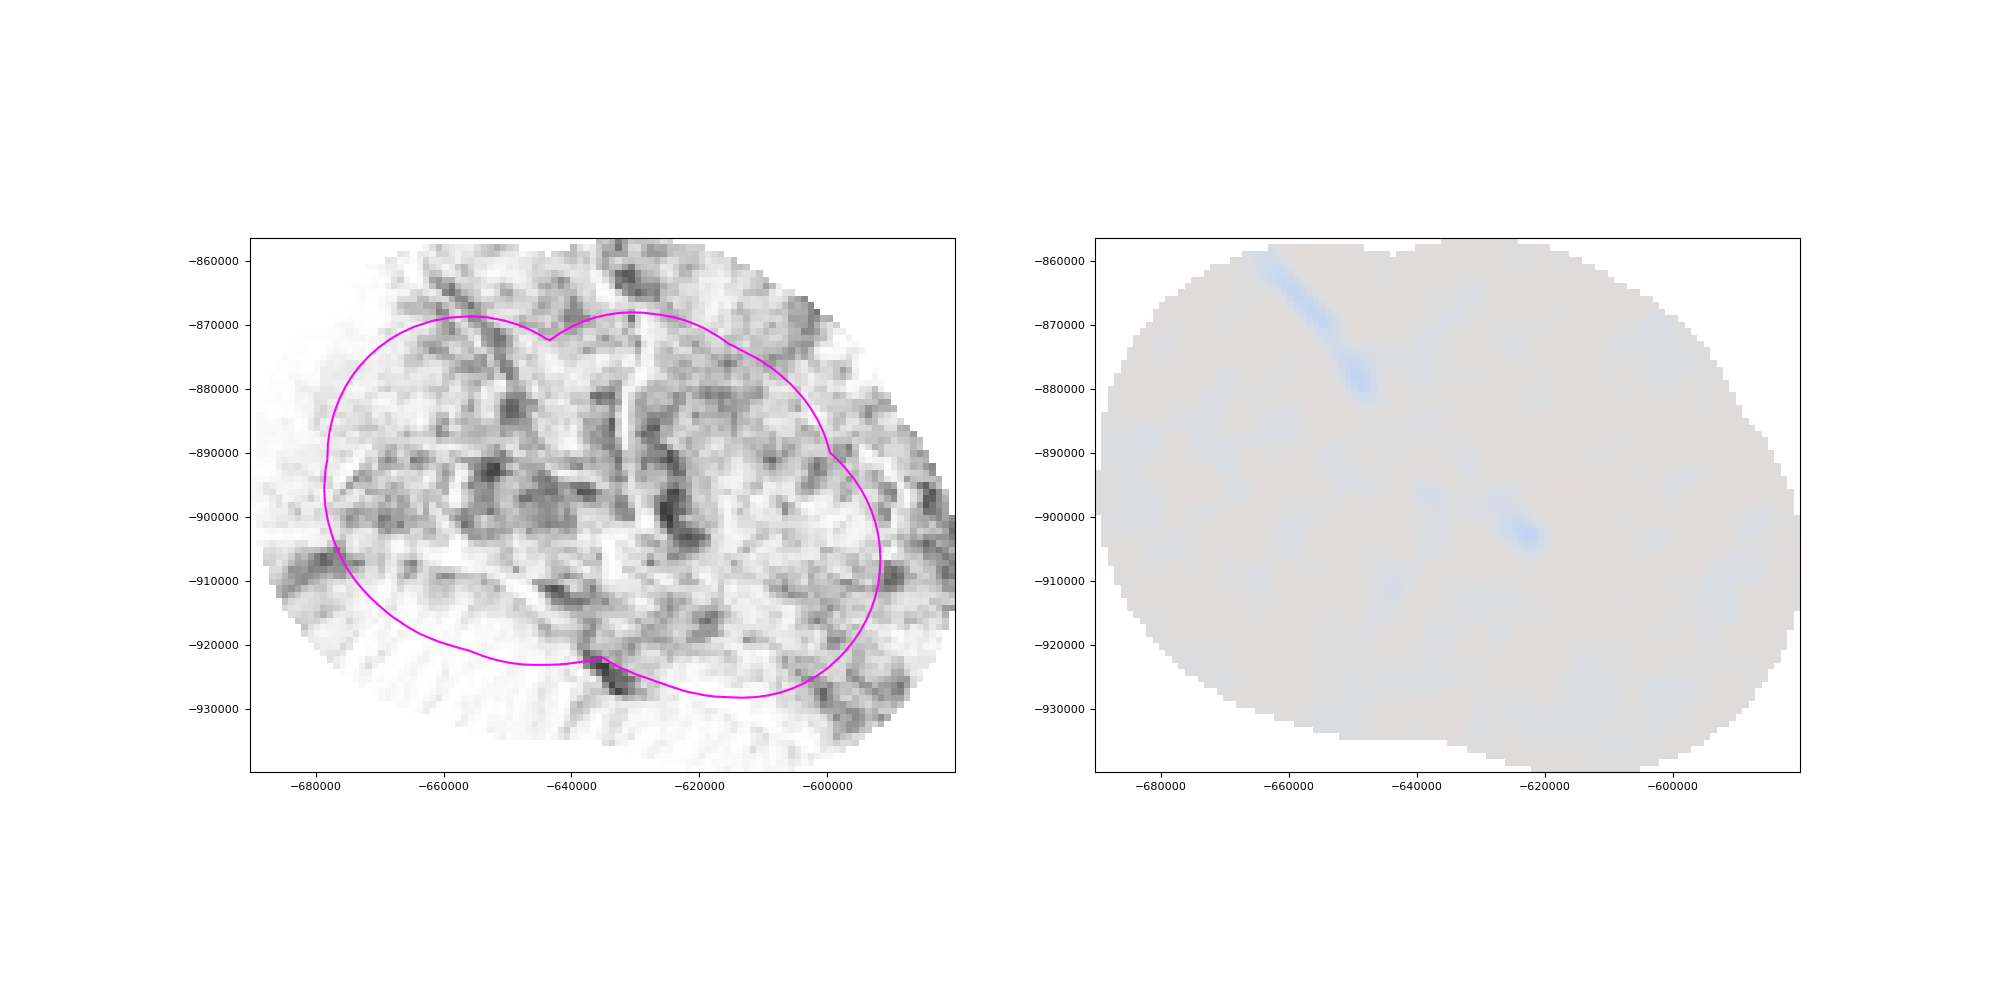

In [76]:
# Define your lake groups
lake_groups = [
    # ['Bindschadler_4', 'Bindschadler_5', 'Bindschadler_6'],
    ['Byrd_1', 'Byrd_2', 'Byrd_s2'],
    ['Byrd_s4', 'Byrd_s5', 'Byrd_s6', 'Byrd_s7', 'Byrd_s8'],
    ['Byrd_s5', 'Byrd_s6', 'Byrd_s7', 'Byrd_s8'],
    # ['Byrd_s14', 'Byrd_s14'],
    # ['David_1', 'David_s1'],
    # ['EAP_1', 'EAP_2', 'EAP_3', 'EAP_4', 'EAP_5'],
    # ['Foundation_2', 'Foundation_3'],
    # ['Foundation_4', 'Foundation_5'],
    # ['Foundation_7', 'Foundation_8'],
    # ['Foundation_9', 'Foundation_10'],
    # ['Foundation_7', 'Foundation_8', 'Foundation_9', 'Foundation_10'],
    # ['Foundation_7', 'Foundation_8', 'Foundation_9', 'Foundation_10', 'Foundation_11', 'Foundation_12', 'Foundation_13'],
    # ['Foundation_11', 'Foundation_12', 'Foundation_13'],
    ['Foundation_N1', 'Foundation_N2', 'Foundation_N3'],
    ['Foundation_N2', 'Foundation_N3'],
    ['JG_D1_a', 'JG_D1_b', 'JG_D2_a'],
    # ['JG_D1_a', 'JG_D1_b', 'JG_D2_a', 'JG_F1', 'JG_Combined_D2_b_E1', 'JG_Combined_E2_F2'],
    # ['Kamb_1', 'Kamb_2', 'Kamb_3', 'Kamb_4', 'Kamb_5'],
    ['Kamb_3', 'Kamb_4'],
    # ['Kamb_6', 'Kamb_7'],
    # ['Kamb_8', 'Kamb_9'],
    # ['Kamb_10', 'Kamb_10'],
    # ['M1', 'M2'],
    ['Mac1', 'Mac2'],
    # ['Mac1', 'Mac2', 'Mac3'],
    ['Mac4', 'Mac5'],
    ['LowerMercerSubglacialLake', 'MercerSubglacialLake'],
    # ['LowerConwaySubglacialLake', 'ConwaySubglacialLake', 'LowerMercerSubglacialLake', 'MercerSubglacialLake'],
    ['Rec4', 'Rec5', 'Rec6'],
    ['Rec5', 'Rec6'],
    ['Site_B', 'Site_C'],
    ['Slessor_4', 'Slessor_5'],
    ['Thw_70', 'Thw_124', 'Thw_142', 'Thw_170'],
    ['Thw_124', 'Thw_142', 'Thw_170'],
    ['Thw_124', 'Thw_142'],
    ['TL96', 'TL108', 'TL115', 'TL122'],
    ['TL108', 'TL115', 'TL122']
]

# # Reverse for processing backwards using a second server
# lake_groups.reverse()

# Process each group
for lake_group in lake_groups:
    
    # First find search extents and levels for the group
    # find_optimal_levels_group(stationary_lakes_gdf, lake_group)
        
    # Then finalize the evolving outlines using these parameters
    finalize_evolving_outlines_group(stationary_lakes_gdf, lake_group)

Next we address the singular lakes that are not near a lake neighbor but have finalized evolving outlines that appear flawed because some of the outlines are prematurely cut by the search extent selected. We address this by selecting the next most optimal level/within_area_multiple combination.

In [78]:
lakes_redux = [
    # 'Bindschadler_3',
    # 'Byrd_s2',
    # 'Byrd_s6',
    # 'Byrd_s7',
    # 'Cook_E2',
    # 'David_1',
    # 'David_s1',
    # 'Foundation_6',
    # 'Foundation_11',
    # 'Foundation_15',
    # 'Institute_E2',
    # 'Institute_W2',
    # 'JG_Combined_E2_F2',
    # 'JG_D1_a',
    # 'JG_D1_b',
    # 'JG_F1',
    # 'Kamb_3',
    # 'Kamb_4',
    # 'Kamb_9',
    # 'KT1',
    # 'Lake10',
    # 'Lake12',
    # 'Lake78',
    # 'LennoxKing_1',
    # 'LowerMercerSubglacialLake',
    # 'M1',
    # 'M2',
    # 'Mac3',
    # 'MercerSubglacialLake',
    'Ninnis_1',
    # 'R1',
    # 'R3',
    # 'Raymond_1',
    # 'Rec2',
    # 'Rutford_1',
    # 'Slessor_1',
    # 'TL108',
    # 'TL115',
    # 'Totten_2',
    # 'UpperSubglacialLakeConway',
    # 'V1',
    # 'Whillans_6',
    # 'Whillans_8',
    # 'WT',
    # 'Wilkes_2',
]

lake_grps_redux=[
    ['Slessor_4', 'Slessor_5'],
    ['Thw_70', 'Thw_124', 'Thw_142', 'Thw_170']
]

First we need to delete the data_counts/dh plots generated by the find_evolving_outlines function. We reviewed these and determined that outlines were prematurely cut by the search_extext, so we will use the next optimal within_area_multiple/level combination to see if it better characterizes the lake's activity.

In [63]:
# For each lake name in the list
for lake_name in lakes_redux:
    # Construct the full directory path
    lake_dir = os.path.join(OUTPUT_DIR, 'find_evolving_outlines', lake_name)
    
    # Check if directory exists before attempting to delete contents
    if os.path.exists(lake_dir):
        # Delete all contents in the directory
        for item in os.listdir(lake_dir):
            item_path = os.path.join(lake_dir, item)
            try:
                if os.path.isfile(item_path):
                    os.unlink(item_path)
                elif os.path.isdir(item_path):
                    shutil.rmtree(item_path)
            except Exception as e:
                print(f'Failed to delete {item_path}. Reason: {e}')
        print(f'Cleared directory contents of {lake_name}')
    else:
        print(f'Directory does not exist: {lake_dir}')

    # Clear the output of each index
    clear_output(wait=True)

Cleared directory contents of Thw_124_Thw_142_Thw_170


In [79]:
stationary_lakes_gdf_filtered = stationary_lakes_gdf[stationary_lakes_gdf['name'].isin(lakes_redux)]

for idx in range(len(stationary_lakes_gdf_filtered)):

    # Then finalize the evolving outlines using these parameters
    finalize_evolving_outlines(stationary_lakes_gdf_filtered.iloc[idx:idx+1], row_index=1)

Finalizing outlines for Ninnis_1
Using parameters from row 1:
area_multiple_search_extent                                                    2
level                                                                       0.54
within_percent                                                             100.0
dataset_dois                   doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...
Name: 0, dtype: object
Cleaning geometries for Ninnis_1...
Saved outlines to: output/lake_outlines/evolving_outlines/Ninnis_1.geojson
Starting plot for lake: Ninnis_1
Parameters: search_extent=2, level=0.54
Successfully saved plot to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods.ipynb/plot_evolving_outlines/plot_evolving_outlines_Ninnis_1_2x-search-extent_0.54m-level.png


In [ ]:
for idx in range(len(lake_grps_redux)):
    finalize_evolving_outlines_group(stationary_lakes_gdf, lake_grps_redux[idx], row_index=1)

In [ ]:
lakes_redux = [
    'Byrd_s2',
    # 'Cook_E2',
    'David_s1',
    'Foundation_11',
    'Foundation_15',
    'Institute_E2',
    'JG_Combined_E2_F2',
    'JG_D1_a',
    'JG_D1_b',
    'JG_F1',
    'Kamb_3',
    'Kamb_9',
    'KT1',
    'Lake10',
    'Lake78',
    'LennoxKing_1',
    'LowerMercerSubglacialLake',
    'M1',
    'Mac3',
    'Ninnis_1',
    'R1',
    'R3',
    'Raymond_1',
    'Slessor_1',
    'TL115',
    'V1',
    'Whillans_6',
    'Whillans_8',
    'Wilkes_2',
    'WT',
]

lake_grps_redux=[
    ['Slessor_4', 'Slessor_5'],
    ['Thw_70', 'Thw_124', 'Thw_142', 'Thw_170']
]

In [ ]:
# For each lake name in the list
for lake_name in lakes_redux:
    # Construct the full directory path
    lake_dir = os.path.join(OUTPUT_DIR, 'find_evolving_outlines', lake_name)
    
    # Check if directory exists before attempting to delete contents
    if os.path.exists(lake_dir):
        # Delete all contents in the directory
        for item in os.listdir(lake_dir):
            item_path = os.path.join(lake_dir, item)
            try:
                if os.path.isfile(item_path):
                    os.unlink(item_path)
                elif os.path.isdir(item_path):
                    shutil.rmtree(item_path)
            except Exception as e:
                print(f'Failed to delete {item_path}. Reason: {e}')
        print(f'Cleared directory contents of {lake_name}')
    else:
        print(f'Directory does not exist: {lake_dir}')

    # Clear the output of each index
    clear_output(wait=True)

In [ ]:
stationary_lakes_gdf_filtered = stationary_lakes_gdf[stationary_lakes_gdf['name'].isin(lakes_redux)]

for idx in range(len(stationary_lakes_gdf_filtered)):

    # Then finalize the evolving outlines using these parameters
    finalize_evolving_outlines(stationary_lakes_gdf_filtered.iloc[idx:idx+1], row_index=2)

# Final quality check

In [ ]:
# Create new lakes geodataframe that has the unary union of the evolving outlines for each lake

# List all folders in target directory
folder_path = OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines'

# Filter stationary_lakes_gdf to only include lakes with evolving outlines
stationary_lakes_gdf_filtered = filter_gdf_by_folder_contents(stationary_lakes_gdf, 
                                                              folder_path, 
                                                              exclude=False,
                                                              file_extension='csv')

# Copy stationary_lakes_gdf_filtered to create evolving_lakes_gdf that will contain 
# the unary unions of the evolving outlines for each lake as their geometry
union_evolving_lakes_gdf = stationary_lakes_gdf_filtered.copy(deep=True)

for idx, row in stationary_lakes_gdf_filtered.iterrows():
    # Select lake as pandas series
    lake_ps = stationary_lakes_gdf_filtered.loc[idx]

    # Perform unary union using function that returns as geoseries
    evolving_outlines_union_gs = find_evolving_outlines_unary_union(lake_ps)

    # Store polygon from geoseries in a geodataframe with CRS
    evolving_outlines_union_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:3031', geometry=[evolving_outlines_union_gs[0]])

    # Convert GeoDataFrame to EPSG:4326 CRS for geodesic area calculation
    evolving_outlines_union_gdf = evolving_outlines_union_gdf.to_crs('4326')

    # Replace stationary geometry with the union of evolving outlines at each lake
    if evolving_outlines_union_gs is not None:
        union_evolving_lakes_gdf.at[idx, 'geometry'] = evolving_outlines_union_gs[0]
        union_evolving_lakes_gdf.at[idx, 'area (m^2)'] = calculate_area(evolving_outlines_union_gdf['geometry'].iloc[0])

# Reproject GeoDataFrame to EPSG:3031
union_evolving_lakes_gdf = union_evolving_lakes_gdf.to_crs('3031')

In [ ]:
union_evolving_lakes_gdf

In [ ]:
# Create two new lakes geodataframe that have the unary union of 
# 1) the evolving outlines for each lake
# 2) the evolving outlines and the stationary outline for each lake

# List all folders in target directory
folder_path = '/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines'

# Filter stationary_lakes_gdf to only include lakes that have evolving outlines found at them
stationary_lakes_gdf_filtered = filter_gdf_by_folder_contents(stationary_lakes_gdf, folder_path, exclude=False)

# Copy stationary_lakes_gdf_filtered to create two new geodataframes
evolving_stationary_outlines_union_gdf = stationary_lakes_gdf_filtered.copy(deep=True)
evolving_outlines_union_gdf = stationary_lakes_gdf_filtered.copy(deep=True)

for idx, row in stationary_lakes_gdf_filtered.iterrows():
    # Select lake as pandas series
    lake_ps = stationary_lakes_gdf_filtered.loc[idx]

    # Perform unary union using function that returns as geoseries
    evolving_stationary_outlines_union_gs = find_evolving_outlines_union(lake_ps, incl_stationary=True)
    evolving_outlines_union_gs = find_evolving_outlines_union(lake_ps, incl_stationary=False)

    # Store polygon from geoseries in a geodataframe with CRS
    evolving_stationary_outlines_union_gdf_idx = gpd.GeoDataFrame(index=[0], crs='EPSG:3031', geometry=[evolving_stationary_outlines_union_gs[0]])
    evolving_outlines_union_gdf_idx = gpd.GeoDataFrame(index=[0], crs='EPSG:3031', geometry=[evolving_outlines_union_gs[0]])

    # Convert GeoDataFrame to EPSG:4326 CRS for geodesic area calculation
    evolving_stationary_outlines_union_gdf_idx = evolving_stationary_outlines_union_gdf_idx.to_crs('4326')
    evolving_outlines_union_gdf_idx = evolving_outlines_union_gdf_idx.to_crs('4326')

    # Replace stationary geometry with the union of evolving outlines at each lake
    if evolving_outlines_union_gs is not None:
        evolving_stationary_outlines_union_gdf.at[idx, 'geometry'] = evolving_outlines_union_gs[0]
        evolving_outlines_union_gdf.at[idx, 'geometry'] = evolving_stationary_outlines_union_gs[0]
        evolving_stationary_outlines_union_gdf.at[idx, 'area (m^2)'] = calculate_geodesic_area(evolving_stationary_outlines_union_gdf_idx['geometry'].iloc[0])
        evolving_outlines_union_gdf.at[idx, 'area (m^2)'] = calculate_geodesic_area(evolving_outlines_union_gdf_idx['geometry'].iloc[0])

# Reproject GeoDataFrame to EPSG:3031
evolving_stationary_outlines_union_gdf = evolving_stationary_outlines_union_gdf.to_crs('3031')
evolving_outlines_union_gdf = evolving_outlines_union_gdf.to_crs('3031')

In [ ]:
fig, ax = plt.subplots()
stationary_lakes_gdf.boundary.plot(ax=ax, color='red')
union_evolving_lakes_gdf.boundary.plot(ax=ax, color='blue')
union_evolving_stationary_lakes_gdf.boundary.plot(ax=ax, color='green')
Scripps_landice.boundary.plot(ax=ax, lw=0.5)
plt.show()

In [ ]:
# Plot evolving and stationary lakes comparison plots

# List all files in your target directory
folder_path = '/home/jovyan/1_evolving_Ant_subglacial_hydro/output/FigS1_lake_reexamination_methods.ipynb/plot_evolving_and_stationary_comparison'

# List all files in your target directory without their extensions
file_names_without_extension = [os.path.splitext(name)[0] for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]

# Filter the GeoDataFrame to only include rows where the 'name' is not in folders
stationary_lakes_gdf_filtered = stationary_lakes_gdf[~stationary_lakes_gdf['name'].isin(file_names_without_extension)]

# Now run loop on the filtered GeoDataFrame
for idx, row in stationary_lakes_gdf_filtered.iterrows():
    # plot_evolving_and_stationary_comparison(stationary_lakes_gdf_filtered.loc[idx:idx])
    plot_evolving_and_stationary_comparison(stationary_lakes_gdf_filtered.loc[idx])

# Troubleshooting

In [ ]:
# Foundation_5 has outlines during CS2 but geometric variables just during IS2
# Institute_W1 has strange gap in geometric variable calc's
# Nimrod_1 has CS2 era data despite partial coverage

# Spot check and export evolving outlines union lakes geodataframes

In [ ]:
fig, ax = plt.subplots()
stationary_lakes_gdf.boundary.plot(ax=ax, color='red')
union_evolving_lakes_gdf.boundary.plot(ax=ax, color='blue')
union_evolving_stationary_lakes_gdf.boundary.plot(ax=ax, color='green')
Scripps_landice.boundary.plot(ax=ax, lw=0.5)
plt.show()

In [ ]:
# Save to gdf
evolving_stationary_outlines_union_gdf.to_file('output/lake_outlines/evolving_stationary_outlines_union_gdf.geojson', driver='GeoJSON')
evolving_outlines_union_gdf.to_file('output/lake_outlines/evolving_outlines_union_gdf.geojson', driver='GeoJSON')

# Run geometric calculation and plotting functions on finalized evolving outlines

In [ ]:
# List all files in your target directory
folder_path = '/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines'

# List all files in your target directory without their extensions
file_names_without_extension = [os.path.splitext(name)[0] for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]

# Filter the GeoDataFrame to only include rows where the 'name' is not in folders
# stationary_lakes_gdf_filtered = stationary_lakes_gdf[~stationary_lakes_gdf['name'].isin(file_names_without_extension)]

# Filter stationary_lakes_gdf based on folder contents
stationary_lakes_gdf_filtered = filter_gdf_by_folder_contents(stationary_lakes_gdf, folder_path, exclude=False)

# Now run loop on the filtered GeoDataFrame
for idx in range(len(stationary_lakes_gdf_filtered)):

    # Isolate lake from stationary_lakes_gdf as geodataframe using slicing
    lake_gdf = stationary_lakes_gdf_filtered.loc[idx:idx]
    print('Working on', lake_gdf['name'].iloc[0])

    # Assign dataset; during CS2 era, assign based on SARIn coverage time period
    cs2_time_period = stationary_lakes_gdf['CS2_SARIn_time_period'][idx]
    if cs2_time_period == None:
        dataset1 = None
    elif cs2_time_period == '2013.75-2018.75':
        dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
    elif cs2_time_period == '2010.5-2018.75':
        dataset1 = CS2_Smith2017
    dataset2=ATL15_dh

    # Calc darea, dh, and dvol for evolving and stationary outlines and compare using bias (evolving-stationary) for each lake
    # compare_evolving_and_stationary_outlines(lake_ps=lake_ps, dataset1=dataset1, dataset2=dataset2)
    compare_evolving_union_and_stationary_outlines(stationary_lake_gdf=lake_ps, dataset1=dataset1, dataset2=dataset2, incl_stationary=True)
    compare_evolving_union_and_stationary_outlines(stationary_lake_gdf=lake_ps, dataset1=dataset1, dataset2=dataset2, incl_stationary=False)

    # Clear the output of each index
    clear_output(wait=True)

In [ ]:
len(stationary_lakes_gdf_filtered)

In [ ]:
len(file_names_without_extension)

In [ ]:
# List all files in your target directory
folder_path = '/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines'

# List all files in your target directory without their extensions
file_names_without_extension = [os.path.splitext(name)[0] for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]

# Filter the GeoDataFrame to only include rows where the 'name' is not in folders
stationary_lakes_gdf_filtered = stationary_lakes_gdf[~stationary_lakes_gdf['name'].isin(file_names_without_extension)]

# Now run loop on the filtered GeoDataFrame
for idx in range(len(stationary_lakes_gdf)):

    # Isolate lake from stationary_lakes_gdf as geodataframe using slicing
    lake_gdf = stationary_lakes_gdf.loc[idx:idx]
    print('Working on', lake_gdf['name'].iloc[0])

    # Assign dataset; during CS2 era, assign based on SARIn coverage time period
    cs2_time_period = stationary_lakes_gdf['CS2_SARIn_time_period'][idx]
    if cs2_time_period == None:
        dataset1 = None
    elif cs2_time_period == '2013.75-2018.75':
        dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
    elif cs2_time_period == '2010.5-2018.75':
        dataset1 = CS2_Smith2017
    dataset2=ATL15_dh

    # Plot the outlines in aggregate
    plot_evolving_outlines(lake_gdf=lake_gdf)

    # Clear the output of each index
    clear_output(wait=True)

In [ ]:
# List all files in your target directory
folder_path = '/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines'

# List all files in your target directory without their extensions
file_names_without_extension = [os.path.splitext(name)[0] for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))]

# Filter the GeoDataFrame to only include rows where the 'name' is not in folders
stationary_lakes_gdf_filtered = stationary_lakes_gdf[~stationary_lakes_gdf['name'].isin(file_names_without_extension)]

# Now run loop on the filtered GeoDataFrame
for idx in range(len(stationary_lakes_gdf)):

    # Isolate lake from stationary_lakes_gdf as geodataframe using slicing
    lake_gdf = stationary_lakes_gdf.loc[idx:idx]
    print('Working on', lake_gdf['name'].iloc[0])

    # Assign dataset; during CS2 era, assign based on SARIn coverage time period
    cs2_time_period = stationary_lakes_gdf['CS2_SARIn_time_period'][idx]
    if cs2_time_period == None:
        dataset1 = None
    elif cs2_time_period == '2013.75-2018.75':
        dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
    elif cs2_time_period == '2010.5-2018.75':
        dataset1 = CS2_Smith2017
    dataset2=ATL15_dh

    # Plot stationary and evolving outlines darea, dh, dvol comparison
    plot_evolving_and_stationary_comparison(lake_gdf=lake_gdf)

    # Clear the output of each index
    clear_output(wait=True)

In [ ]:
# Ensure all lakes complete
print(len(os.listdir('/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/find_evolving_outlines')))
print(len(os.listdir('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines')))
print(len(os.listdir('/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_evolving_outlines/')))
print(len(os.listdir('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/compare_evolving_and_stationary_outlines')))
print(len(os.listdir('/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_evolving_and_stationary_comparison/')))

In [ ]:
# Create a dataframe that combines all the evolving and stationary lake geometric calculations
# and bias comparisons into one dataframe for continentally integrated numbers

# Define your directory
directory = 'output/lake_outlines/compare_evolving_and_stationary_outlines'
dataframes_all_lakes = []
dataframes_CS2_IS2 = []
dataframes_IS2 = []

# List and read each CSV file
for file in os.listdir(directory):
    if file.endswith('.csv'):
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        
        # Check conditions to append to specific lists
        lake_name = os.path.splitext(file)[0]  # Remove '.csv' from filename to create the lake name
        lake_row = stationary_lakes_gdf[stationary_lakes_gdf['name'] == lake_name]
        if not lake_row.empty:
            dataframes_all_lakes.append(df)
            
            time_period = lake_row['CS2_SARIn_time_period'].values[0]
            if time_period in ['2010.5-2018.75', '2013.75-2018.75']:
                dataframes_CS2_IS2.append(df)
            elif pd.isna(time_period):
                dataframes_IS2.append(df)
            else:
                print('Cryosat-2 time period not one of expected values')

# Concatenate DataFrames in the list
combined_all_lakes_df = pd.concat(dataframes_all_lakes, ignore_index=True)
combined_CS2_IS2_df = pd.concat(dataframes_CS2_IS2, ignore_index=True)
combined_IS2_df = pd.concat(dataframes_IS2, ignore_index=True)

# Group by 'midcyc_datetime' to make spatially integrated along time axis
combined_all_lakes_df = combined_all_lakes_df.groupby('midcyc_datetime').sum().reset_index()
combined_CS2_IS2_df = combined_CS2_IS2_df.groupby('midcyc_datetime').sum().reset_index()
combined_IS2_df = combined_IS2_df.groupby('midcyc_datetime').sum().reset_index()

# For all lakes df, remove CryoSat-2 era since only some of the lakes have that coverage
# Ensure the midcyc_datetime column is in datetime format
combined_all_lakes_df['midcyc_datetime'] = pd.to_datetime(combined_all_lakes_df['midcyc_datetime'])

# Define the datetime when ICESat time series begins
threshold = pd.Timestamp('2018-11-16 14:15:00')

# Filter the DataFrame
combined_all_lakes_df_filtered = combined_all_lakes_df[combined_all_lakes_df['midcyc_datetime'] >= threshold]

# Reset index
combined_all_lakes_df_filtered = combined_all_lakes_df_filtered.reset_index(drop=True)

# Save the combined DataFrame to csv file
combined_all_lakes_df_filtered.to_csv('output/lake_outlines/compare_evolving_and_stationary_outlines/all_lakes_during_IS2_spatially_integrated.csv', index=False) 
combined_CS2_IS2_df.to_csv('output/lake_outlines/compare_evolving_and_stationary_outlines/all_CS2_IS2_lakes_spatially_integrated.csv', index=False) 
combined_IS2_df.to_csv('output/lake_outlines/compare_evolving_and_stationary_outlines/all_IS2_lakes_spatially_integrated.csv', index=False)

# Fig. S1

In [ ]:
# remaking fig
# -trellis plot
# -panel of cryotempoeolis gridded data (show that it is point data at many lakes);
# perhaps pick a lake at SARIn boundary to show that you didn't include those in the CS2 era analysis
# -data_count panel (use example of lake at boundary of CS2 SARIn coverage)
# -panel showing all 15 area multiple search extents
# -panels of pos and neg dh with contours created (and level listed)
# -aggregate plot of evolving outlines
# Add something along the lines of code below to illustrate lake area/outline:
# # Plot polygons in the GeoDataFrame
# gdf.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=1, label='Polygon Area')
# gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Polygon Boundary')

In [ ]:
# Import mid_cyc_dates
mid_cyc_dates = pd.read_csv('output/cycle_dates.csv', parse_dates=['cyc_start_dates', 'mid_cyc_dates', 'cyc_end_dates'])

In [ ]:
mid_cyc_dates

In [ ]:
# Explore Cryo-TEMPO-EOLIS

for i in range(len(CS2_SARIn_CryoTEMPO['time'])):
    fig, ax = plt.subplots(1,1)
    
    # Panel - CryoSat-2 SARIn boundary lake with Cryo-TEMPO-EOLIS data ---------------------------------------------
    lake_gdf = stationary_lakes_gdf[stationary_lakes_gdf['name'] == 'Rec2']
    
    # Define lake name and polygon
    lake_name = lake_gdf['name']
    lake_poly = lake_gdf['geometry'].iloc[0]
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    search_extent_poly = area_multiple_buffer(lake_poly, 2)
    
    # Establish x_min, x_max, y_min, y_max
    # x_min, y_min, x_max, y_max = search_extent_poly.iloc[0].geometry.bounds
    x_min, y_min, x_max, y_max = lake_poly.bounds
    x_buffer = abs(x_max-x_min)*0.3
    y_buffer = abs(y_max-y_min)*0.3
    
    # Subsetting dataset
    dataset1 = CS2_SARIn_CryoTEMPO
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    
    # Plot figure
    img = ax.imshow(dataset1_subset['elevation'][i,:,:], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer], 
        origin='lower', cmap='viridis')
    
    # Overlay published active lake outlines for visual comparison and grounding line
    S09_outlines_color = 'paleturquoise'
    stationary_lakes_gdf_color  = 'turquoise'
    # S09_outlines.boundary.plot(ax=ax, edgecolor=S09_outlines_color, linestyle=(0, (1, 3)), linewidth=2)
    S09_outlines.boundary.plot(ax=ax, edgecolor=S09_outlines_color, linestyle='solid', linewidth=2)
    # stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)          
    stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle='solid', linewidth=2)          
    
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)  
    
    # Label axes, set limits, and set title
    ax.set_xlabel('x [km]', size=15)
    ax.set_ylabel('y [km]', size=15) 
    ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    
    
    # Panel - data counts ---------------------------------------------
    
    # Panel - area multiple search extents ---------------------------------------------
    
    # Panel - CryoSat-2 era time slice with evolving outlines ---------------------------------------------
    
    # Panel - ICESat-2 era time slice with evolving outlines (opposite sign) ---------------------------------------------
    
    # Panel - aggregated evolving outlines ---------------------------------------------

    # Save and close plot
    plt.savefig(OUTPUT_DIR + '/temp/fig{}.png'.format(i),
        dpi=300, bbox_inches='tight')

    plt.close()

In [ ]:
for idx in range(len(CS2_SARIn_CryoTEMPO['time'])):
    # fig, ax = plt.subplots(3, 2, figsize=(15, 10), constrained_layout=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5), constrained_layout=True)
    
    # Panel - CryoSat-2 SARIn boundary lake with Cryo-TEMPO-EOLIS data ---------------------------------------------
    lake_gdf = stationary_lakes_gdf[stationary_lakes_gdf['name'] == 'Rec2']
    
    # Define lake name and polygon
    lake_name = lake_gdf['name']
    lake_poly = lake_gdf['geometry'].iloc[0]
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    search_extent_poly = area_multiple_buffer(lake_poly, 2)
    
    # Establish x_min, x_max, y_min, y_max
    # x_min, y_min, x_max, y_max = search_extent_poly.iloc[0].geometry.bounds
    x_min, y_min, x_max, y_max = lake_poly.bounds
    x_buffer = abs(x_max-x_min)*0.3
    y_buffer = abs(y_max-y_min)*0.3
    
    # Subsetting dataset
    dataset1 = CS2_SARIn_CryoTEMPO
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    
    # Plot CryoSat-2 SARIn mode masks
    gdf_SARIn_3_1.plot(ax=ax, edgecolor='k', facecolor='yellow', alpha=0.25)
    gdf_SARIn_3_1_3_6_diff.plot(ax=ax, edgecolor='k', facecolor='yellow', lw=1, alpha=0.25)
    
    # Plot elevation data
    # idx = 33  # Select timeslice to show
    img = ax.imshow(dataset1_subset['elevation'][idx+1,:,:]-dataset1_subset['elevation'][idx,:,:], 
        extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer], 
        origin='lower', cmap='RdBu', norm=colors.CenteredNorm(vcenter=0), zorder=1)
    
    # Overlay published active lake outlines for visual comparison and grounding line
    S09_outlines_color = 'paleturquoise'
    stationary_lakes_gdf_color = 'darkturquoise'
    # S09_outlines.boundary.plot(ax=ax, edgecolor=S09_outlines_color, linestyle=(0, (1, 3)), linewidth=2)
    S09_outlines.boundary.plot(ax=ax, edgecolor=S09_outlines_color, linestyle='solid', linewidth=2)
    # stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)          
    stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_gdf_color, linestyle='solid', linewidth=2)          
    
    # Plot inset map
    axIns = ax.inset_axes([0.61, 0.01, 0.5, 0.5]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.axis('off')
    gdf_SARIn_3_1.plot(ax=axIns, edgecolor='k', facecolor='yellow', alpha=0.25, zorder=3)
    gdf_SARIn_3_1_3_6_diff.plot(ax=axIns, edgecolor='k', facecolor='yellow', alpha=0.25, zorder=3)
    
    # Plot red star to indicate location
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)  
    
    # Label axes, set limits, and set title
    ax.set_xlabel('x [km]', size=12)
    ax.set_ylabel('y [km]', size=12) 
    ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    
    # Creating custom legend entries
    S09_line = plt.Line2D([], [], color=S09_outlines_color, linestyle='solid', linewidth=2)
    S18_line = plt.Line2D([], [], color=stationary_lakes_gdf_color, linestyle='solid', linewidth=2)
    CS2_SARIn_patch = mpatches.Patch(edgecolor='k', facecolor='yellow', alpha=0.25)
    
    # Plot colorbar
    axins = inset_axes(ax, width="100%", height="100%", loc='center right',
                       bbox_to_anchor=(1.01, 0, 0.02, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0)
    cbar = fig.colorbar(img, cax=axins)#, label='height change [m quarter${^-1}$]', orientation='vertical')
    cbar.ax.tick_params(labelsize=12)  # Increase font size of colorbar tick labels
    cbar.ax.set_ylabel('height change [m quarter$^{-1}$]', fontsize=14)  # Increase font size of colorbar label
    
    # Set a title for the axes
    # title_text = 'Height change from from {} to {}'.format(mid_cyc_dates['cyc_end_dates'][idx+1].astype('datetime64[D]').astype(str), mid_cyc_dates['cyc_start_dates'][idx].astype('datetime64[D]').astype(str))
    title_text = 'Height change from {} to {}'.format(mid_cyc_dates['cyc_start_dates'][idx].strftime('%Y-%m-%d'), mid_cyc_dates['cyc_start_dates'][idx+1].strftime('%Y-%m-%d'))
    ax.set_title(title_text, fontsize=16, pad=67)
    
    # Create legend
    ax.legend([S09_line, S18_line, CS2_SARIn_patch],
        ['Recovery_2 active lake stationary outline', 'Recovery_2 active lake redelineated', 'CryoSat-2 SARIn coverage'], 
        loc='upper center', bbox_to_anchor=(0.5, 1.28), fontsize=12)
    
    # Increase tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Panel - data counts ---------------------------------------------
    
    # Panel - area multiple search extents ---------------------------------------------
    
    # Panel - CryoSat-2 era time slice with evolving outlines ---------------------------------------------
    
    # Panel - ICESat-2 era time slice with evolving outlines (opposite sign) ---------------------------------------------
    
    # Panel - aggregated evolving outlines ---------------------------------------------
    
    
    # plt.show()
    # Save and close plot
    plt.savefig(OUTPUT_DIR + '/temp/fig{}.png'.format(idx),
        dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
# Do the same but for Ben's CS2 gridded data
for idx in range(len(CS2_Smith2017['time'])):
    # fig, ax = plt.subplots(3, 2, figsize=(15, 10), constrained_layout=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5), constrained_layout=True)
    
    # Panel - CryoSat-2 SARIn boundary lake with Cryo-TEMPO-EOLIS data ---------------------------------------------
    lake_gdf = stationary_lakes_gdf[stationary_lakes_gdf['name'] == 'Rec2']
    
    # Define lake name and polygon
    lake_name = lake_gdf['name']
    lake_poly = lake_gdf['geometry'].iloc[0]
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    search_extent_poly = area_multiple_buffer(lake_poly, 2)
    
    # Establish x_min, x_max, y_min, y_max
    # x_min, y_min, x_max, y_max = search_extent_poly.iloc[0].geometry.bounds
    x_min, y_min, x_max, y_max = lake_poly.bounds
    x_buffer = abs(x_max-x_min)*0.3
    y_buffer = abs(y_max-y_min)*0.3
    
    # Subsetting dataset
    dataset1 = CS2_Smith2017
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    dataset1_subset = dataset1_subset.where(dataset1_subset.data_count > 1, drop=True)
    
    # Plot CryoSat-2 SARIn mode masks
    gdf_SARIn_3_1.plot(ax=ax, edgecolor='k', facecolor='yellow', alpha=0.25)
    gdf_SARIn_3_1_3_6_diff.plot(ax=ax, edgecolor='k', facecolor='yellow', lw=1, alpha=0.25)
    
    # Plot elevation data
    # idx = 33  # Select timeslice to show
    img = ax.imshow(dataset1_subset['delta_h'][idx+1,:,:]-dataset1_subset['delta_h'][idx,:,:], 
        extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer], 
        origin='lower', cmap='RdBu', norm=colors.CenteredNorm(vcenter=0), zorder=1)
    
    # Overlay published active lake outlines for visual comparison and grounding line
    S09_outlines_color = 'paleturquoise'
    stationary_lakes_gdf_color = 'darkturquoise'
    # S09_outlines.boundary.plot(ax=ax, edgecolor=S09_outlines_color, linestyle=(0, (1, 3)), linewidth=2)
    S09_outlines.boundary.plot(ax=ax, edgecolor=S09_outlines_color, linestyle='solid', linewidth=2)
    # stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)          
    stationary_lakes_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_gdf_color, linestyle='solid', linewidth=2)          
    
    # Plot inset map
    axIns = ax.inset_axes([0.61, 0.01, 0.5, 0.5]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.axis('off')
    gdf_SARIn_3_1.plot(ax=axIns, edgecolor='k', facecolor='yellow', alpha=0.25, zorder=3)
    gdf_SARIn_3_1_3_6_diff.plot(ax=axIns, edgecolor='k', facecolor='yellow', alpha=0.25, zorder=3)
    
    # Plot red star to indicate location
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)  
    
    # Label axes, set limits, and set title
    ax.set_xlabel('x [km]', size=12)
    ax.set_ylabel('y [km]', size=12) 
    ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    
    # Creating custom legend entries
    S09_line = plt.Line2D([], [], color=S09_outlines_color, linestyle='solid', linewidth=2)
    S18_line = plt.Line2D([], [], color=stationary_lakes_gdf_color, linestyle='solid', linewidth=2)
    CS2_SARIn_patch = mpatches.Patch(edgecolor='k', facecolor='yellow', alpha=0.25)
    
    # Plot colorbar
    axins = inset_axes(ax, width="100%", height="100%", loc='center right',
                       bbox_to_anchor=(1.01, 0, 0.02, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0)
    cbar = fig.colorbar(img, cax=axins)#, label='height change [m quarter$^{-1}$]', orientation='vertical')
    cbar.ax.tick_params(labelsize=12)  # Increase font size of colorbar tick labels
    cbar.ax.set_ylabel('height change [m quarter$^{-1}$]', fontsize=14)  # Increase font size of colorbar label
    
    # Set a title for the axes
    # title_text = 'Height change from from {} to {}'.format(mid_cyc_dates['cyc_end_dates'][idx+1].astype('datetime64[D]').astype(str), mid_cyc_dates['cyc_start_dates'][idx].astype('datetime64[D]').astype(str))
    title_text = 'Height change from {} to {}'.format(mid_cyc_dates['cyc_start_dates'][idx].strftime('%Y-%m-%d'), mid_cyc_dates['cyc_start_dates'][idx+1].strftime('%Y-%m-%d'))
    ax.set_title(title_text, fontsize=16, pad=67)
    
    # Create legend
    ax.legend([S09_line, S18_line, CS2_SARIn_patch],
        ['Recovery_2 active lake stationary outline', 'Recovery_2 active lake redelineated', 'CryoSat-2 SARIn coverage'], 
        loc='upper center', bbox_to_anchor=(0.5, 1.28), fontsize=12)
    
    # Increase tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Panel - data counts ---------------------------------------------
    
    # Panel - area multiple search extents ---------------------------------------------
    
    # Panel - CryoSat-2 era time slice with evolving outlines ---------------------------------------------
    
    # Panel - ICESat-2 era time slice with evolving outlines (opposite sign) ---------------------------------------------
    
    # Panel - aggregated evolving outlines ---------------------------------------------
    
    
    # plt.show()
    # Save and close plot
    plt.savefig(OUTPUT_DIR + '/temp/fig{}.png'.format(idx),
        dpi=300, bbox_inches='tight')

In [ ]:
# Panel - area multiple search extents ---------------------------------------------

# Select lake to plot
lake_gdf = stationary_lakes_gdf[stationary_lakes_gdf['name'] == 'Slessor_23']

# Define lake name and polygon
lake_name = lake_gdf['name']
lake_poly = lake_gdf['geometry'].iloc[0]

# Create buffered polygons for various multiples of lake area to find which
# best emcompasses the height change signals at previously identified lakes
search_extent_poly = area_multiple_buffer(lake_poly, 15)

# Establish x_min, x_max, y_min, y_max
# x_min, y_min, x_max, y_max = search_extent_poly.iloc[0].geometry.bounds
x_min, y_min, x_max, y_max = search_extent_poly.bounds
x_buffer = abs(x_max-x_min)*0.1
y_buffer = abs(y_max-y_min)*0.1
mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)

# Create fig, ax
fig, ax = plt.subplots(figsize=(5,5))

# Plot stationary and evolving outlines onto MOA surface imagery
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
ax.imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

# Create lines for legend
S09_color = 'paleturquoise'
SF18_color  = 'turquoise'
stationary_lakes_color = 'darkturquoise'
Smith2009 = plt.Line2D([], [], color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
SiegfriedFricker2018 = plt.Line2D([], [], color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
stationary_lakes_line = plt.Line2D([], [], color=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)
search_extent_line = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)

# Overlay published active lake outlines for visual comparison and grounding line
S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle='solid', linewidth=2)
SF18_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle='solid', linewidth=2)
stationary_lakes_gdf_postSF18.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle=(0, (1, 1)), linewidth=2)          

# Change polar stereographic m to km
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.yaxis.set_major_formatter(ticks_y)  

# Label axes, set limits
ax.set_xlabel('x [km]', size=12)
ax.set_ylabel('y [km]', size=12) 
ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

# Plot inset map
axIns = ax.inset_axes([0, -0.02, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
axIns.axis('off')

# Plot red star to indicate location
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

# Plot within evaluation boundary and search extent
for i in range(2, 16):
    # Create and plot buffered polygon for area multiple within evaluation boundary
    within_evaluation_boundary = area_multiple_buffer(lake_poly, i)
    gpd.GeoDataFrame(geometry=[within_evaluation_boundary]).boundary.plot(ax=ax, edgecolor='dimgray', facecolor='none', linewidth=1)

# Create and plot  buffered polygon for area multiple search extent
within_evaluation_boundary = area_multiple_buffer(lake_poly, 25)
gpd.GeoDataFrame(geometry=[within_evaluation_boundary]).boundary.plot(ax=ax, edgecolor='dimgray', facecolor='none', linewidth=1)

plt.show()

In [ ]:
plt.close('all')